# Figure 3:  RNA and ATAC, P9855

Here we study the chromatin accessibility (ATAC peak heights), gene expression (mRNA counts), and a bit of protein abundance for experiment P9855.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    font = findfont(FontProperties(family=['sans-serif']))

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [6]:
import matplotlib.font_manager as fm
from matplotlib.font_manager import findfont, FontProperties

font = fm.FontProperties(
        family = 'Helvetica', fname = '/System/Library/Fonts/Helvetica.ttc')

In [7]:
plt.rcParams['font.sans-serif'] = 'Helvetica'

font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

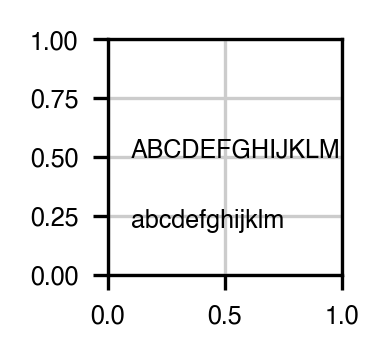

In [8]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

# Loading data

In [9]:
import anndata

adata = anndata.read_loom('../Data/Processed/P9855.loom')
adata.var_names = adata.var['gene_name']
adata.obs_names = adata.obs['obs_names']

prot_data = anndata.read_loom('../Data/Processed/P9855_protein.loom')
prot_data.var_names = prot_data.var['var_names']
prot_data.obs_names = prot_data.obs['obs_names']

ATAC_data = anndata.read_loom('../Data/Processed/P9855_ATAC.loom')
ATAC_data.var_names = ATAC_data.var['PeakID']
ATAC_data.obs_names = ATAC_data.obs['Sample_name']

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
adata

AnnData object with n_obs × n_vars = 70 × 9553
    obs: 'Clone_ID', 'Good clone', 'Number_Of_Cells', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'ENSG', 'F_pval', 'GC_content', 'TSS', 'chr', 'dir', 'end', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells_by_counts', 'pct_dropout_by_counts', 'start', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

In [11]:
prot_data

AnnData object with n_obs × n_vars = 24213 × 8
    obs: 'Clone_ID', 'Clone_Name_Well_ID', 'FSC-A', 'FSC-H', 'FSC-W', 'Numerical_ID', 'Plate', 'SSC-A', 'SSC-H', 'SSC-W', 'SampleID', 'obs_names'
    var: 'gene', 'var_names'

In [12]:
ATAC_data

AnnData object with n_obs × n_vars = 29 × 80599
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start'

## Insert small peak filter

Based on some undesirable noise among low peaks, we remove all peak intervals in which the highest peak is below 15.

In [13]:
good_peaks = ATAC_data.to_df().max() >= np.log1p(15)

In [14]:
ATAC_data = ATAC_data[:,good_peaks]
ATAC_data

View of AnnData object with n_obs × n_vars = 29 × 40608
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start'

In [15]:
ATACR_data = ATAC_data[ATAC_data.obs['Is_replicate'] == True, :]
ATACR_data

View of AnnData object with n_obs × n_vars = 12 × 40608
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start'

# Quick ATAC plotting tool

We create a quick exploratory tool for plotting ATAC peaks, focusing on clones with replicates, and the sister clones 5a/5b.  We assign a modified clone label, for coloring purposes.

In [16]:
clones_focus = ['1', '15', '22', '23', '8', '9', '5a', '5b']

def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip in clones_focus:
        return cl_strip #'Clone '+cl_strip[5:]
    else:
        return 'Other'

ATAC_data.obs['colorclone'] = ATAC_data.obs['ATAC_clone'].map(lambda cl : clone_rename(cl))


Trying to set attribute `.obs` of view, copying.


In [17]:
mm = 1 / 25.4
def ATAC_plot(peak):
    fig,ax = plt.subplots(1,1,figsize=(80*mm,20*mm), dpi=300)
    sns.set_style('whitegrid')
    setfontsize()
    peak_heights = np.exp(pd.DataFrame(ATAC_data.to_df()[peak])) - 1
    peak_heights.columns = ['height']
    peak_heights['parent'] = ATAC_data.obs.ATAC_clone.apply(lambda c : c.split('_')[0])
    peak_heights['hue'] = ATAC_data.obs.colorclone
    sns.scatterplot(x='parent', y='height', color='gray', data=peak_heights[peak_heights['hue'] == 'Other'], 
                    legend=False, ax=ax,s=20)
    
    sns.scatterplot(x='parent', y='height', hue='hue', edgecolor='k',
                    data=peak_heights[peak_heights['hue'] != 'Other'], 
                    legend=False, ax=ax, s=20, alpha=0.8)
    
    ax.set_ylabel('Peak height')
    ax.set_xlabel('Clone')
    ax.tick_params(axis='both', pad=-1)
    plt.suptitle('Heights (absolute) for {}'.format(peak), y=1.05, x=0.55)
    plt.show()

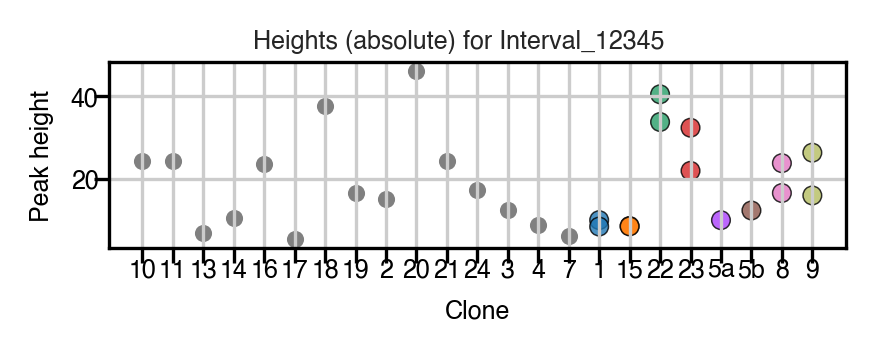

In [18]:
ATAC_plot('Interval_12345')

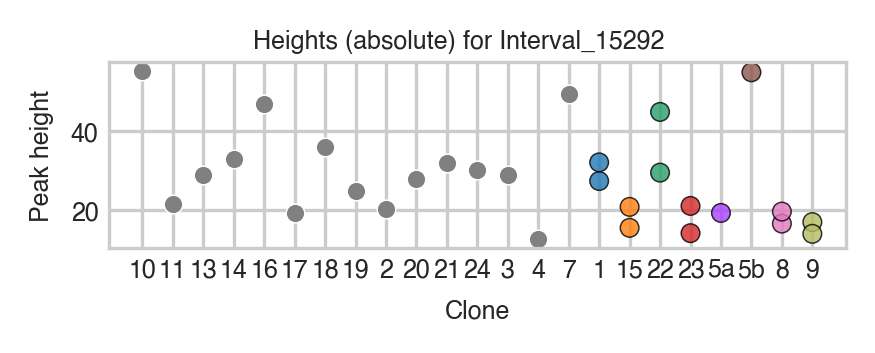

In [19]:
ATAC_plot('Interval_15292')

# Quick figure, IL2RG

By popular demand, here's a little figure related to IL2RG:  population and clonal expression.

In [20]:
IL2RG = adata.to_df()['IL2RG']
IL2RG

obs_names
P9855_2001    7.647796
P9855_2002    7.847446
P9855_2003    8.209406
P9855_2004    7.989888
P9855_2005    8.086321
                ...   
P9855_2078    7.710776
P9855_2079    7.536000
P9855_2080    7.653312
P9855_2081    7.993894
P9855_2082    8.372787
Name: IL2RG, Length: 70, dtype: float32

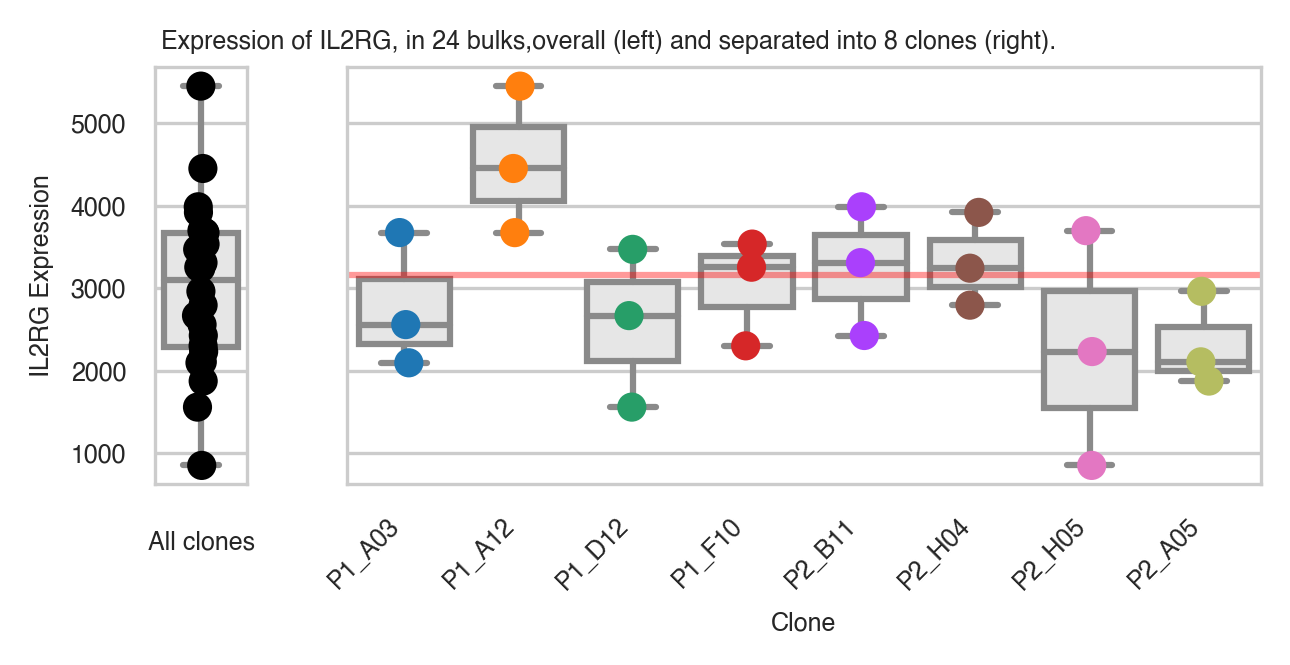

In [21]:
fig,ax = plt.subplots(1,2, sharey = True, figsize=(120*mm,45*mm), dpi=300, 
                      gridspec_kw = {'width_ratios':[1,10]})

allplot_df = pd.DataFrame(np.exp(IL2RG) - 1) # Remove log-normalization.
#allplot_df = pd.DataFrame(IL2RG) # Use log-normalized data?
allplot_df.columns=['IL2RG Expression']
allplot_df['Clone'] = adata.obs['Clone_ID']
allmean = allplot_df['IL2RG Expression'].median()

randclones = allplot_df['Clone'].value_counts()[:8].index
allplot_df = allplot_df[allplot_df['Clone'].isin(randclones)]

sns.boxplot(y='IL2RG Expression', color=(0.9,0.9,0.9,1), data = allplot_df, ax=ax[0], orient='v', whis=np.inf)
sns.stripplot(y='IL2RG Expression', color='black', data = allplot_df, 
              jitter=0.05, ax=ax[0], orient='v',s=7.0)

sns.boxplot(y='IL2RG Expression', x='Clone', color=(0.9,0.9,0.9,1), data = allplot_df, 
            ax=ax[1], orient='v', whis=np.inf)

sns.stripplot(y='IL2RG Expression', x='Clone', hue='Clone', data = allplot_df, 
              jitter=0.05, ax=ax[1], orient='v',s=7.0)

ax[0].set_xlabel('All clones')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha="right")
ax[1].axhline(allmean, color=(1,0,0,0.4))
ax[1].set_ylabel('')
ax[1].legend_.remove()

plt.suptitle('Expression of IL2RG, in {} bulks,'
             'overall (left) and separated into {} clones (right).'.format(len(allplot_df), len(allplot_df['Clone'].unique())))
plt.show()

# Panel:  UMAP Clustering based on ATAC peak heights

We cluster bulks by ATAC peaks using UMAP here.

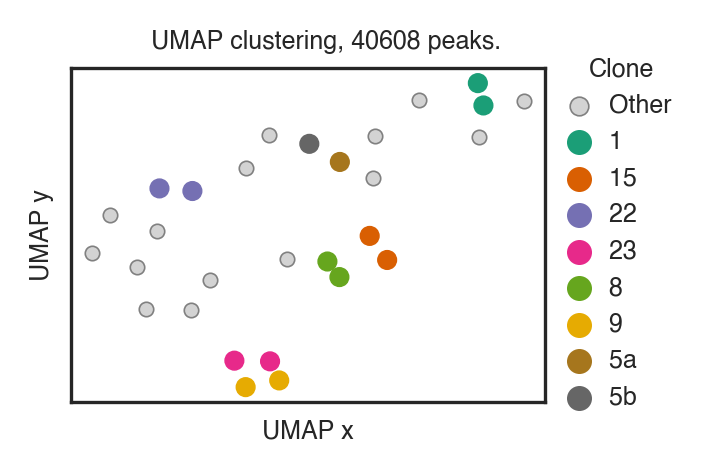

In [151]:
n_components = 10
n_neighbors = 5
min_dist = 0.25

mm = 1/25.4
figsize = (60*mm, 40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

X = ATAC_data.to_df().copy()
y = ATAC_data.obs['colorclone']

hue_order = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]
hue_order = ['  ' + hue for hue in hue_order]
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = '  ' + y
#display(cl_df)

sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == '  Other'], s=12, 
                color='lightgray', edgecolor='gray', linewidth=0.4, ax=ax, label='  Other')

sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, palette='Dark2',
                data = cl_df[cl_df['Clone'] != '  Other'], s=20, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])

lgnd = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.1), ncol=1, framealpha=0.0, title='Clone')

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [20]
for j in range(1,9):
    lgnd.legendHandles[j]._sizes = [25]

plt.suptitle("UMAP clustering, {} peaks.".format(len(X.T)), 
            x=0.6, y=1.0)

set_size(fig, figsize)
plt.savefig("Panels/UMAP.pdf", bbox_inches='tight')

plt.show()

## Varying the UMAP parameters

Now we vary the UMAP parameters through 27 different choices, and look at the resulting distance (in the UMAP plane) between clones, replicates, and the sister clones.

In [152]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform, pdist

n_comp_array = [5,10,20] # PCA components.  Can't be more than the number of samples!
n_neigh_array = [3,5,10]
min_dist_array = [0.1, 0.25, 0.5]


X = ATAC_data.to_df().copy()
y = ATAC_data.obs['colorclone']

clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]

num_try = 10
dist_dfs = {}

for n in range(num_try):
    j = 0
    dm = {}
    dist_df = pd.DataFrame(index=range(len(n_comp_array)*len(n_neigh_array)*len(min_dist_array)), 
                           columns=['n_components','n_neighbors','min_dist','rep_dist','sis_dist','nonrep_dist'])
    for n_components in n_comp_array:
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X) # Apply PCA with n_components components.
        for n_neighbors in n_neigh_array:
            for min_dist in min_dist_array:
                X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                                       random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from PCA components to 2-dimensions.

                cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
                cl_df.index = 'clone' + ATAC_data.obs['ATAC_clone']
                dm[j] = pd.DataFrame(distance_matrix(cl_df.values, cl_df.values), index=cl_df.index, columns=cl_df.index)
                rep_dist = np.array([dm[j].loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
                nonreps = [cl for cl in cl_df.index if cl.split('_')[0] not in 
                          ['clone'+num for num in clr_list]]
                dm_nonrep = dm[j].loc[nonreps][nonreps]
                nonrep_dist = dm_nonrep.values.flatten().mean()
                sis_dist = dm[j].loc['clone5a_R1','clone5b_R1']
                dist_df.loc[j] = {'n_components':n_components,
                                 'n_neighbors':n_neighbors,
                                 'min_dist':min_dist,
                                 'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                                 'sis_dist':sis_dist / nonrep_dist.mean(),
                                 'nonrep_dist':nonrep_dist}
                j += 1
    dist_dfs[n] = dist_df
    print('Iteration {} complete out of {}.'.format(n+1, num_try))
    
display(dist_dfs[0])


Iteration 1 complete out of 10.
Iteration 2 complete out of 10.
Iteration 3 complete out of 10.
Iteration 4 complete out of 10.
Iteration 5 complete out of 10.
Iteration 6 complete out of 10.
Iteration 7 complete out of 10.
Iteration 8 complete out of 10.
Iteration 9 complete out of 10.
Iteration 10 complete out of 10.


n_components n_neighbors min_dist  rep_dist  sis_dist nonrep_dist
0           5.0         3.0      0.1  0.039346  0.139789    9.970861
1           5.0         3.0     0.25  0.026163  0.927857   16.202861
2           5.0         3.0      0.5  0.065244  0.301556     9.60616
3           5.0         5.0      0.1  0.162631  0.257893    2.469169
4           5.0         5.0     0.25   0.17908  0.235463    2.955142
5           5.0         5.0      0.5  0.175264  0.234793    3.893531
6           5.0        10.0      0.1  0.196278   0.28953    1.935221
7           5.0        10.0     0.25  0.266656  0.237284    2.002474
8           5.0        10.0      0.5  0.317118  0.455734    2.157353
9          10.0         3.0      0.1  0.049351  0.082003    5.151282
10         10.0         3.0     0.25    0.0605  0.062704    7.095615
11         10.0         3.0      0.5   0.07569   0.09953    6.992275
12         10.0         5.0      0.1  0.118691  0.107737    2.548601
13         10.0         5.0     0.25  0.195783  0.202145    2.559455
14         10.0         5.0      0.5  0.218321  0.211884    3.127794
15         10.0        10.0      0.1  0.217414  0.302485    1.982842
16         10.0        10.0     0.25   0.32207  0.330014    1.768379
17         10.0        10.0      0.5  0.308352  0.339184    2.326813
18         20.0         3.0      0.1  0.153622  0.222036     2.13149
19         20.0         3.0     0.25  0.176161  0.401289    2.621402
20         20.0         3.0      0.5   0.20942  0.447996     2.92597
21         20.0         5.0      0.1  0.172259  0.904462    1.780127
22         20.0         5.0     0.25  0.246425  0.459053    1.892639
23         20.0         5.0      0.5  0.306914  0.584047    2.285327
24         20.0        10.0      0.1  0.295189  0.833728    1.511841
25         20.0        10.0     0.25  0.328879  0.650587    1.659047
26         20.0        10.0      0.5  0.363869  1.320265    2.089016

In [153]:
for col in dist_df.columns[:3]:
    dist_df[col] = dist_dfs[0][col]
for col in dist_df.columns[3:5]:
    dist_df[col] = pd.concat([dist_dfs[j][col] for j in range(num_try)], axis=1).mean(axis=1)
dist_df

n_components n_neighbors min_dist  rep_dist  sis_dist nonrep_dist
0           5.0         3.0      0.1  0.034789  0.714498    6.382632
1           5.0         3.0     0.25  0.038259  0.569313   15.313632
2           5.0         3.0      0.5  0.055361  0.390046    9.363237
3           5.0         5.0      0.1  0.089676  0.166097    4.883254
4           5.0         5.0     0.25  0.133954  0.183054    3.164924
5           5.0         5.0      0.5  0.196814  0.250598    2.941384
6           5.0        10.0      0.1  0.221414  0.314546    1.779344
7           5.0        10.0     0.25  0.272016  0.334623    1.802519
8           5.0        10.0      0.5  0.290067  0.388399    2.212538
9          10.0         3.0      0.1  0.057660  0.093602    7.964916
10         10.0         3.0     0.25  0.085851  0.123710    4.309736
11         10.0         3.0      0.5  0.128684  0.161298    5.162326
12         10.0         5.0      0.1  0.150115  0.200901    2.056264
13         10.0         5.0     0.25  0.190713  0.206134    2.233872
14         10.0         5.0      0.5  0.239228  0.262922    2.747708
15         10.0        10.0      0.1  0.256054  0.291496     1.48689
16         10.0        10.0     0.25  0.294480  0.336925    1.978073
17         10.0        10.0      0.5  0.327185  0.366578    2.461848
18         20.0         3.0      0.1  0.109689  0.267393    3.057717
19         20.0         3.0     0.25  0.164773  0.372994     2.83241
20         20.0         3.0      0.5  0.216413  0.478499    2.823668
21         20.0         5.0      0.1  0.181628  0.403242     2.22632
22         20.0         5.0     0.25  0.228462  0.413952    2.127562
23         20.0         5.0      0.5  0.282455  0.435052    2.230469
24         20.0        10.0      0.1  0.277137  0.928633    1.499604
25         20.0        10.0     0.25  0.318077  0.825877    1.575403
26         20.0        10.0      0.5  0.339279  0.817071    2.109068

In [154]:
print('The mean UMAP distance between replicate clones is '
      '{:0.1%} +/- {:0.1%} of the mean non-replicate distance.'.format(dist_df.rep_dist.mean(), dist_df.rep_dist.std()))

print('The mean UMAP distance between sister clones 5a/5b is '
      '{:0.1%} +/- {:0.1%} of the mean non-replicate distance.'.format(dist_df.sis_dist.mean(), dist_df.sis_dist.std()))

The mean UMAP distance between replicate clones is 19.2% +/- 9.4% of the mean non-replicate distance.
The mean UMAP distance between sister clones 5a/5b is 38.1% +/- 22.0% of the mean non-replicate distance.


In [155]:
ATAC_df = ATAC_data.to_df()
ATAC_df.index = 'clone'+ATAC_data.obs['ATAC_clone']
ATAC_df = ATAC_df.T

In [156]:
X = ATAC_df.T
pca = PCA(n_components=10)
X_PCA = pca.fit_transform(X)
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

dm_raw = pd.DataFrame(distance_matrix(X_PCA, X_PCA), index=X.index, columns=X.index)
rep_dist = np.array([dm_raw.loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
nonreps = [cl for cl in X.index if cl.split('_')[0] not in ['clone'+num for num in clr_list]]
dm_nonrep = dm_raw.loc[nonreps][nonreps]
nonrep_dist = dm_nonrep.values.flatten().mean()
sis_dist = dm_raw.loc['clone5a_R1','clone5b_R1']
dist_raw_df = pd.Series({'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                  'sis_dist':sis_dist / nonrep_dist.mean(),
                  'nonrep_dist':nonrep_dist})
display(dist_raw_df)

rep_dist        0.047642
sis_dist        0.511090
nonrep_dist    97.867765
dtype: float64

In [157]:
#X = ATAC_df.T
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

dm_raw = pd.DataFrame(distance_matrix(X.values, X.values), index=X.index, columns=X.index)
rep_dist = np.array([dm_raw.loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
nonreps = [cl for cl in X.index if cl.split('_')[0] not in ['clone'+num for num in clr_list]]
dm_nonrep = dm_raw.loc[nonreps][nonreps]
nonrep_dist = dm_nonrep.values.flatten().mean()
sis_dist = dm_raw.loc['clone5a_R1','clone5b_R1']
dist_raw_df = pd.Series({'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                  'sis_dist':sis_dist / nonrep_dist.mean(),
                  'nonrep_dist':nonrep_dist})
display(dist_raw_df)

rep_dist         0.510791
sis_dist         0.847184
nonrep_dist    134.593323
dtype: float64

In [158]:
dist_df

n_components n_neighbors min_dist  rep_dist  sis_dist nonrep_dist
0           5.0         3.0      0.1  0.034789  0.714498    6.382632
1           5.0         3.0     0.25  0.038259  0.569313   15.313632
2           5.0         3.0      0.5  0.055361  0.390046    9.363237
3           5.0         5.0      0.1  0.089676  0.166097    4.883254
4           5.0         5.0     0.25  0.133954  0.183054    3.164924
5           5.0         5.0      0.5  0.196814  0.250598    2.941384
6           5.0        10.0      0.1  0.221414  0.314546    1.779344
7           5.0        10.0     0.25  0.272016  0.334623    1.802519
8           5.0        10.0      0.5  0.290067  0.388399    2.212538
9          10.0         3.0      0.1  0.057660  0.093602    7.964916
10         10.0         3.0     0.25  0.085851  0.123710    4.309736
11         10.0         3.0      0.5  0.128684  0.161298    5.162326
12         10.0         5.0      0.1  0.150115  0.200901    2.056264
13         10.0         5.0     0.25  0.190713  0.206134    2.233872
14         10.0         5.0      0.5  0.239228  0.262922    2.747708
15         10.0        10.0      0.1  0.256054  0.291496     1.48689
16         10.0        10.0     0.25  0.294480  0.336925    1.978073
17         10.0        10.0      0.5  0.327185  0.366578    2.461848
18         20.0         3.0      0.1  0.109689  0.267393    3.057717
19         20.0         3.0     0.25  0.164773  0.372994     2.83241
20         20.0         3.0      0.5  0.216413  0.478499    2.823668
21         20.0         5.0      0.1  0.181628  0.403242     2.22632
22         20.0         5.0     0.25  0.228462  0.413952    2.127562
23         20.0         5.0      0.5  0.282455  0.435052    2.230469
24         20.0        10.0      0.1  0.277137  0.928633    1.499604
25         20.0        10.0     0.25  0.318077  0.825877    1.575403
26         20.0        10.0      0.5  0.339279  0.817071    2.109068

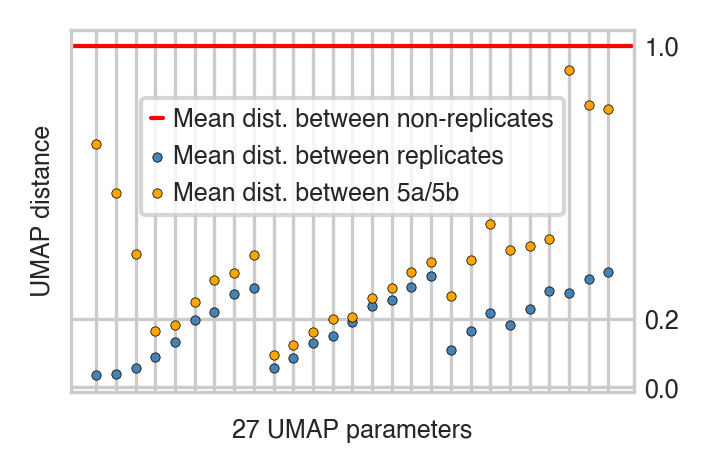

In [160]:
figsize=(60*mm,40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)

sns.set_style('whitegrid')
setfontsize()

plot_df = dist_df.copy()
plot_df['Distance between replicates'] = plot_df['rep_dist']
plot_df['Distance between 5a/5b'] = plot_df['sis_dist']

plot_df['Parameter'] = dist_df['n_components'].astype(int).astype(str)+', '
plot_df['Parameter'] += dist_df['n_neighbors'].astype(int).astype(str)+', '
plot_df['Parameter'] +=  dist_df['min_dist'].astype(str).apply(lambda s : s[1:])
sns.scatterplot(y = 'Distance between replicates', x='Parameter', data=plot_df, 
                s=5, edgecolor='k', color='steelblue', ax=ax, label='Mean dist. between replicates')
sns.scatterplot(y = 'Distance between 5a/5b', x='Parameter', data=plot_df, 
                s=5, edgecolor='k', color='orange', ax=ax, label='Mean dist. between 5a/5b')

ax.axhline(1.0, label='Mean dist. between non-replicates', color='red', linewidth=1)
ax.legend(bbox_to_anchor=(0.5, 0.65), loc='center')
ax.set_ylabel('UMAP distance')
ax.set_xticklabels([])
ax.set_xlabel('27 UMAP parameters')
ax.set_yticks([0,0.2,1])
ax.tick_params(axis='both', pad=-1)
ax.tick_params(axis='y', labelright=True, labelleft=False)

set_size(fig, figsize)
plt.savefig("Panels/UMAP_params.pdf", bbox_inches='tight')

plt.show()

#  Clonal peak variability

Here we look at clonal peak variability, among the replicate clones.  The replicate clones offer a method for simultaneous quality control and variability assessment.  We put the replicate peak heights into a dataframe first.

In [31]:
AR_df = ATACR_data.to_df()
AR_df.index = ATACR_data.obs.ATAC_clone
AR_df

PeakID      Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
ATAC_clone                                                                   
1_R1              2.220971        2.315422        2.116660        5.671244   
1_R2              2.574305        2.743844        2.183737        5.564601   
15_R1             2.335525        2.683983        2.465641        5.688357   
15_R2             2.405284        3.251001        2.472925        5.707511   
22_R1             2.244406        1.836056        1.836056        5.708737   
22_R2             3.193007        2.102691        2.843361        5.701477   
23_R1             1.966361        1.506567        1.684364        5.644652   
23_R2             2.089187        2.495113        2.207124        5.422726   
8_R1              2.349192        1.845438        2.404186        5.449306   
8_R2              2.764788        1.938780        2.645507        5.587162   
9_R1              2.610464        2.833161        2.774429        5.439472   
9_R2              1.911073        2.905863        2.621405        5.426267   

PeakID      Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
ATAC_clone                                                                  
1_R1              2.401717        3.377605        3.313264       4.745931   
1_R2              1.533994        3.179393        3.153849       5.019365   
15_R1             1.796163        3.665038        0.890413       5.179786   
15_R2             2.536280        3.984053        0.574085       5.185097   
22_R1             2.244406        3.383287        1.836056       5.176583   
22_R2             1.986456        3.479647        1.307133       4.987438   
23_R1             1.290173        3.610647        0.000000       4.964272   
23_R2             1.618351        3.594341        1.106046       5.158560   
8_R1              1.515987        3.879200        3.382059       5.243636   
8_R2              1.938780        3.833457        3.569858       5.121625   
9_R1              2.414239        3.765365        1.078167       5.125531   
9_R2              2.423591        3.834274        2.078779       5.169731   

PeakID      Interval_6501  Interval_68580  ...  Interval_69022  \
ATAC_clone                                 ...                   
1_R1             4.688817        5.477601  ...        4.004826   
1_R2             4.815708        5.461985  ...        4.348597   
15_R1            4.634396        5.577959  ...        4.017701   
15_R2            4.518895        5.676119  ...        4.421291   
22_R1            5.096018        5.234419  ...        4.300684   
22_R2            5.041146        5.476916  ...        3.938026   
23_R1            4.325634        5.529636  ...        4.162033   
23_R2            4.554307        5.487547  ...        4.341717   
8_R1             4.568126        5.484337  ...        4.294054   
8_R2             4.448444        5.469012  ...        4.169264   
9_R1             3.958736        5.456172  ...        4.144042   
9_R2             4.164550        5.402453  ...        4.112055   

PeakID      Interval_56910  Interval_27261  Interval_76540  Interval_57434  \
ATAC_clone                                                                   
1_R1              5.825352        2.315422        2.747701        4.865391   
1_R2              5.625410        2.311708        3.044600        5.019365   
15_R1             5.707617        2.402698        2.009906        5.031943   
15_R2             5.745415        2.405284        2.169631        5.136153   
22_R1             5.789331        1.836056        2.822287        5.108843   
22_R2             5.771048        2.206811        3.075744        5.206758   
23_R1             5.772682        1.966361        2.280140        5.057832   
23_R2             5.624217        2.408018        0.698727        5.021691   
8_R1              5.731441        2.456313        2.505857        5.077258   
8_R2              5.493785        2.020924   

This data contains 12 samples, with 2 bulks from each clone.  These 2 bulks are considered replicates (R1 and R2).

In [32]:
parents = ATACR_data.obs.ATAC_parent.unique()
parents

array(['1', '15', '22', '23', '8', '9'], dtype=object)

We examine the general distribution of replicate pairs, by "melting" the dataframe above.

In [33]:
AR_mins = pd.DataFrame(columns=AR_df.columns, index=parents)
AR_maxs = pd.DataFrame(columns=AR_df.columns, index=parents)
for cp in parents:
    AR_both = AR_df.loc[[cp+'_R1',cp+'_R2']]
    AR_mins.loc[cp] = AR_both.min()
    AR_maxs.loc[cp] = AR_both.max()

minmelt = AR_mins.melt()
mindiff_df = pd.DataFrame(minmelt.value, index=minmelt.index)
mindiff_df.columns = ['min_value']

mindiff_df['Diff'] = (AR_maxs - AR_mins).melt().value.astype(float)

val_max = mindiff_df.min_value.max() + 0.01
int_size = (val_max - 0.01) / 10
tuple_list = [(a+1e-10,a+int_size) for a in np.arange(0.01,val_max,int_size)]

bins = pd.IntervalIndex.from_tuples([(0,0.01)] + tuple_list, closed='left')
mindiff_df['Cut'] = pd.cut(mindiff_df.min_value, bins=bins)

bigdiffs = (mindiff_df.groupby('Cut').Diff).quantile(0.99).astype(float)
meddiffs = (mindiff_df.groupby('Cut').Diff).quantile(0.5).astype(float)

mindiff_df['meddiff'] = mindiff_df.Cut.map(meddiffs).astype(float)
mindiff_df['bigdiff'] = mindiff_df.Cut.map(bigdiffs).astype(float)
mindiff_df['reldiff'] = mindiff_df['Diff'] / mindiff_df['meddiff']
           
mindiff_df['badpeak'] = (mindiff_df.Diff > mindiff_df.bigdiff)

mindiff_df['PeakID'] = minmelt['PeakID']

mindiff_df

min_value      Diff                                       Cut  \
0       2.220971  0.353334   [1.976722536187036, 2.6322967147827145)   
1       2.335525  0.069759   [1.976722536187036, 2.6322967147827145)   
2       2.244406  0.948601   [1.976722536187036, 2.6322967147827145)   
3       1.966361  0.122825  [1.3211483574913574, 1.9767225360870362)   
4       2.349192  0.415596   [1.976722536187036, 2.6322967147827145)   
...          ...       ...                                       ...   
243643   1.41148  0.257812  [1.3211483574913574, 1.9767225360870362)   
243644  1.426249  0.780562  [1.3211483574913574, 1.9767225360870362)   
243645   1.83527  0.253916  [1.3211483574913574, 1.9767225360870362)   
243646   1.93878  0.783544  [1.3211483574913574, 1.9767225360870362)   
243647   1.84578  0.065293  [1.3211483574913574, 1.9767225360870362)   

         meddiff   bigdiff   reldiff  badpeak          PeakID  
0       0.244747  0.878883  1.443672    False  Interval_77062  
1       0.244747  0.878883  0.285024    False  Interval_77062  
2       0.244747  0.878883  3.875846     True  Interval_77062  
3       0.356118  1.163165  0.344901    False  Interval_77062  
4       0.244747  0.878883  1.698064    False  Interval_77062  
...          ...       ...       ...      ...             ...  
243643  0.356118  1.163165  0.723951    False  Interval_17712  
243644  0.356118  1.163165  2.191865    False  Interval_17712  
243645  0.356118  1.163165  0.713012    False  Interval_17712  
243646  0.356118  1.163165  2.200238    False  Interval_17712  
243647  0.356118  1.163165  0.183347    False  Interval_17712  

[243648 rows x 8 columns]

This produces about a half-million replicate-pair peak heights.  We organize each pair by the lowest peak height (among the two in the pair) and the difference in peak heights.

What we see is that replicate pairs (R1/R2) within a clone tend to have very close peak heights.  E.g., if the minimum peak height is 3, the maximum peak height is typically less than 3.5, and almost always less than 4.0.

We can use this for quality control, throwing out peaks in which a replicate pair exhibits distant peak heights.  We give each peak a "quality p-value" based on the most distant of the replicate pairs.  If the most distant of the replicate pairs is in the 99th percentile (in peak-height difference), then the quality p-value would be 0.01.  

In [34]:
mindiff_df

min_value      Diff                                       Cut  \
0       2.220971  0.353334   [1.976722536187036, 2.6322967147827145)   
1       2.335525  0.069759   [1.976722536187036, 2.6322967147827145)   
2       2.244406  0.948601   [1.976722536187036, 2.6322967147827145)   
3       1.966361  0.122825  [1.3211483574913574, 1.9767225360870362)   
4       2.349192  0.415596   [1.976722536187036, 2.6322967147827145)   
...          ...       ...                                       ...   
243643   1.41148  0.257812  [1.3211483574913574, 1.9767225360870362)   
243644  1.426249  0.780562  [1.3211483574913574, 1.9767225360870362)   
243645   1.83527  0.253916  [1.3211483574913574, 1.9767225360870362)   
243646   1.93878  0.783544  [1.3211483574913574, 1.9767225360870362)   
243647   1.84578  0.065293  [1.3211483574913574, 1.9767225360870362)   

         meddiff   bigdiff   reldiff  badpeak          PeakID  
0       0.244747  0.878883  1.443672    False  Interval_77062  
1       0.244747  0.878883  0.285024    False  Interval_77062  
2       0.244747  0.878883  3.875846     True  Interval_77062  
3       0.356118  1.163165  0.344901    False  Interval_77062  
4       0.244747  0.878883  1.698064    False  Interval_77062  
...          ...       ...       ...      ...             ...  
243643  0.356118  1.163165  0.723951    False  Interval_17712  
243644  0.356118  1.163165  2.191865    False  Interval_17712  
243645  0.356118  1.163165  0.713012    False  Interval_17712  
243646  0.356118  1.163165  2.200238    False  Interval_17712  
243647  0.356118  1.163165  0.183347    False  Interval_17712  

[243648 rows x 8 columns]

In [35]:
diff_df = {}
md_df = {}
ATAC_data.var['quality_p'] = 1.0
cuts = mindiff_df['Cut'].unique()

for cut in cuts:
    md_df[cut] = mindiff_df[mindiff_df['Cut'] == cut].copy()
    diff_df[cut] = md_df[cut].Diff.sort_values()
    md_df[cut]['ss'] = np.searchsorted(diff_df[cut], md_df[cut].Diff)
    num_samps = len(diff_df[cut])
    md_df[cut]['p_val'] = 1 - (md_df[cut]['ss'] / (1 + num_samps))
    qp_series = md_df[cut].groupby('PeakID').p_val.min()
    ATAC_data.var.loc[qp_series.index, 'quality_p'] = qp_series
    
ATAC_data.var

PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_77062  Interval_77062   9  115080094  ENSG00000119314      PTBP3   
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_33832  Interval_33832  19    1672563             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_48454  Interval_48454   3   27493603  ENSG00000033867     SLC4A7   
...                        ...  ..        ...              ...        ...   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_58433  Interval_58433   5   54298635  ENSG00000164283       ESM1   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   
Interval_17712  Interval_17712  12   96890243  ENSG00000188596   C12orf55   

                       itype          mid      start  quality_p  
PeakID                                                           
Interval_77062        intron  115079731.5  115079369   0.152552  
Interval_51938      Intergen  156852750.0  156852601   0.028703  
Interval_33832      Intergen    1672247.0    1671931   0.029762  
Interval_13433  promoter-TSS   82997180.5   82996620   0.010913  
Interval_48454        intron   27493042.5   27492482   0.673157  
...                      ...          ...        ...        ...  
Interval_28417  promoter-TSS   88729670.5   88728987   0.032045  
Interval_58433        intron   54298297.0   54297959   0.664901  
Interval_45676          exon   35310572.5   35310208   0.064673  
Interval_8387   promoter-TSS   33623619.5   33622581   0.067399  
Interval_17712        intron   96889859.5   96889476   0.062587  

[40608 rows x 9 columns]

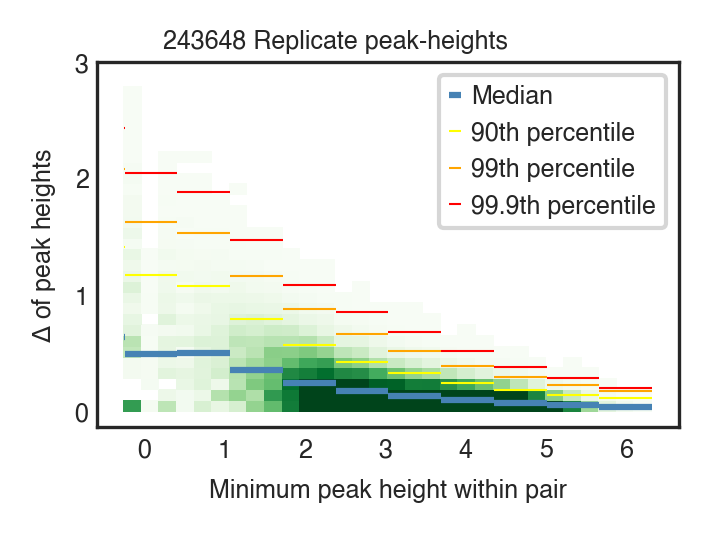

In [36]:
from matplotlib import collections  as mc

sns.set_style('white')
figsize=(60*mm, 45*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()
qcols = {0.5:'steelblue', 0.9:'yellow', 0.99:'orange', 0.999:'red'}
for quant in qcols.keys():
    diffs = mindiff_df.groupby('Cut').quantile(quant).Diff
    lines = [[(cut.left, diffs[cut]), (cut.right, diffs[cut])] for cut in cuts]
    if quant == 0.5:
        label = 'Median'
        lw = 1.5
    else:
        if quant < 0.999:
            label = '{:1.0f}th percentile'.format(quant*100)
        else:
            label = '{:1.1f}th percentile'.format(quant*100)
        lw = 0.5
    lc = mc.LineCollection(lines, linewidths=lw, color=qcols[quant], label=label)
    ax.add_collection(lc)
ax.legend()    

sns.histplot(x='min_value', y='Diff', data=mindiff_df, bins=30, pmax=0.5, 
             cmap='Greens', cbar=False)


plt.suptitle('{} Replicate peak-heights'.format(len(mindiff_df)))
ax.set_xlabel('Minimum peak height within pair')
ax.set_ylabel('$\Delta$ of peak heights')
ax.set_xticks([x + 0.25 for x in [0,1,2,3,4,5,6]])
ax.set_xticklabels(['0','1','2','3','4','5','6'], y=0.05)
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['0','1','2','3'], x=0.035)

set_size(fig, figsize)
plt.savefig("Panels/Diff_dist.pdf", bbox_inches='tight')

plt.show()

The "quality_p" column is very low (close to zero) when the peak height difference is very high when looking at one of the replicate pairs.  We might exclude those with quality_p < 0.1, for quality control purposes.

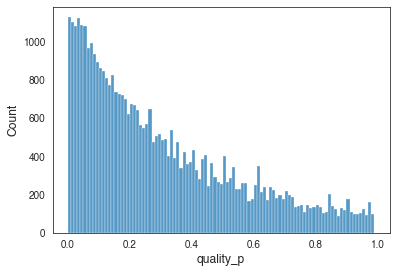

In [37]:
desetfontsize()
sns.histplot(ATAC_data.var.quality_p, bins=np.arange(0,1,0.01))
plt.show()

Note that the distribution of quality p-values is not flat (as one would expect for p-values), since we are taking the minimum p-value among 6 (one for each of the six replicate pairs).

We perform similar analysis to say whether a peak exhibits variability between replicate clones.  The following few cells just explain why the adjustment by 11 is appropriate, a multiple-comparison adjustment of sorts.

In [38]:
exp_array = np.random.exponential(1,10000) # A random array, to make a point.

In [39]:
diff = np.zeros(10000)
for j in range(10000):
    choices = np.random.choice(exp_array,2)
    diff[j] = choices.max() - choices.min()

In [40]:
diff_twelve = np.zeros(10000)
for j in range(10000):
    choices = np.random.choice(exp_array,12)
    diff_twelve[j] = choices.max() - choices.min()

In [41]:
pcut = 0.005

In [42]:
np.quantile(diff_twelve, 1 - (pcut*11)) # Adjust by 11!

5.170558152419968

In [43]:
np.quantile(diff, 1 - pcut) # Should match above, roughly.

5.269015814561615

In [44]:
ATACR_mins = ATACR_data.to_df().min()
ATACR_diffs = ATACR_data.to_df().max() - ATACR_mins

peak_mindiffs = pd.DataFrame(ATACR_mins, columns=['min_value'])
peak_mindiffs['Diff'] = ATACR_diffs
peak_mindiffs['Cut'] = pd.cut(peak_mindiffs.min_value, bins=bins)

p_df = {}

ATAC_data.var['clonal_p'] = 1.0

for cut in cuts:
    p_df[cut] = peak_mindiffs[peak_mindiffs['Cut'] == cut].copy()
    diff_df[cut] 
    p_df[cut]['ss'] = np.searchsorted(diff_df[cut], p_df[cut].Diff)
    num_samps = len(diff_df[cut])
    p_df[cut]['p_val'] = np.clip(11 * (1 - (p_df[cut]['ss'] / (1+num_samps))),0,1) 
    # 11 is the appropriate adjustment here.
    cp_series = p_df[cut].p_val
    ATAC_data.var.loc[cp_series.index, 'clonal_p'] = cp_series
    
ATAC_data.var


PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_77062  Interval_77062   9  115080094  ENSG00000119314      PTBP3   
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_33832  Interval_33832  19    1672563             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_48454  Interval_48454   3   27493603  ENSG00000033867     SLC4A7   
...                        ...  ..        ...              ...        ...   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_58433  Interval_58433   5   54298635  ENSG00000164283       ESM1   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   
Interval_17712  Interval_17712  12   96890243  ENSG00000188596   C12orf55   

                       itype          mid      start  quality_p  clonal_p  
PeakID                                                                     
Interval_77062        intron  115079731.5  115079369   0.152552  0.045662  
Interval_51938      Intergen  156852750.0  156852601   0.028703  0.000815  
Interval_33832      Intergen    1672247.0    1671931   0.029762  0.115377  
Interval_13433  promoter-TSS   82997180.5   82996620   0.010913  0.010109  
Interval_48454        intron   27493042.5   27492482   0.673157  0.540247  
...                      ...          ...        ...        ...       ...  
Interval_28417  promoter-TSS   88729670.5   88728987   0.032045  0.115768  
Interval_58433        intron   54298297.0   54297959   0.664901  0.145547  
Interval_45676          exon   35310572.5   35310208   0.064673  0.006693  
Interval_8387   promoter-TSS   33623619.5   33622581   0.067399  0.000257  
Interval_17712        intron   96889859.5   96889476   0.062587  0.136735  

[40608 rows x 10 columns]

In [45]:
ATAC_data.var['replicate_foldchange'] = np.exp(mindiff_df.groupby('PeakID').Diff.max())

In [46]:
ATAC_data.var['max_height'] = (np.exp(ATAC_data.to_df().max()) - 1)

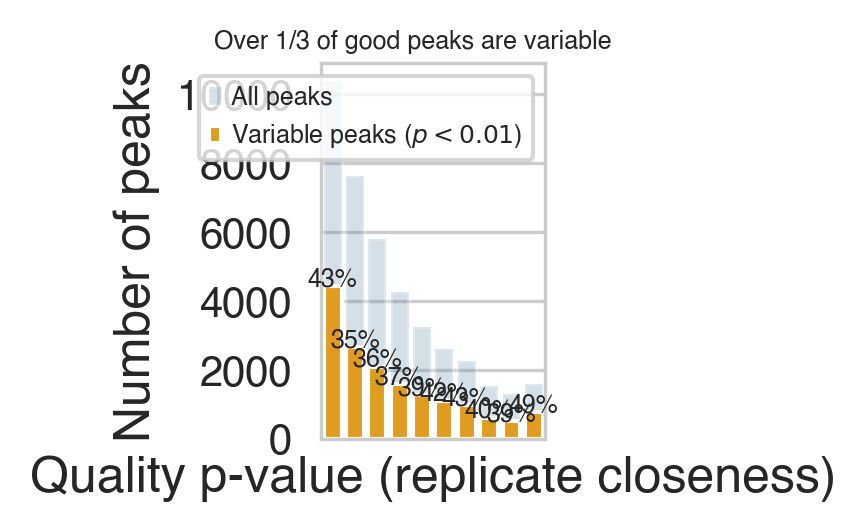

In [47]:
CQ_df = ATAC_data.var[['clonal_p','quality_p', 'max_height']]
qbins = np.arange(0,1.001,0.1)
qcuts = pd.cut(CQ_df.quality_p, qbins)
iindex = pd.IntervalIndex(qcuts.unique()) #.from_tuples([(x,x+1 - 1e-10) for x in np.arange(0,1,0.1)])
plot_df = pd.DataFrame(index = iindex)
plot_df['nsig'] = CQ_df.groupby(qcuts).apply(lambda x : (x < 0.01).sum()).clonal_p
plot_df['count'] = CQ_df.groupby(qcuts).count().clonal_p
plot_df['ratio'] = plot_df['nsig'] / plot_df['count']
plot_df['interval'] = plot_df.index#.apply(lambda x : x.left())
plot_df['mid'] = plot_df['interval'].apply(lambda x : x.mid)
plot_df = plot_df.sort_values(by='mid')

sns.set_style('whitegrid')
figsize=(60*mm, 45*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

sns.barplot(x='mid', y='count', data=plot_df, color='steelblue', alpha=0.25, ax=ax, label='All peaks')
sns.barplot(x='mid', y='nsig', data=plot_df, color='orange', label='Variable peaks ($p<0.01$)',ax=ax)
#for row in plot_df:
#    ax.text(row['interval'], row['nsig'], 'Hello')
for j in range(len(plot_df)):
    nsigj = plot_df.iloc[j]['nsig']
    ratioj = plot_df.iloc[j]['ratio']
    ax.text(j,nsigj,'{:1.0%}'.format(ratioj), ha='center')

ax.set_xticks([])
ax.set_xticklabels([]) #plot_df['interval'])
ax.legend()
plt.xticks(rotation=45)

ax.set_xlabel('Quality p-value (replicate closeness)')
ax.set_ylabel('Number of peaks')
plt.suptitle('Over 1/3 of good peaks are variable')

set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks.pdf", bbox_inches='tight')
plt.show()

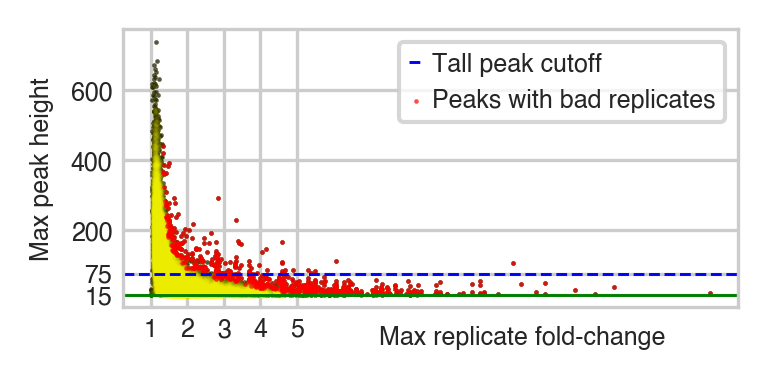

In [48]:
plot_df = ATAC_data.var[['replicate_foldchange','max_height']].copy()
figsize = (65*mm, 32*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()


#fc_line = pd.DataFrame(columns=['fc','ph'])
#fc_line['fc'] = np.linspace(1.2,6,50)
#fc_line['ph'] = -80 + 100 / (np.log(fc_line['fc']))
#sns.lineplot(x='fc',y='ph', data=fc_line, color='green', linewidth=0.7)

bigspread = plot_df.sort_values(by='max_height').rolling(500).quantile(0.98)['replicate_foldchange']
plot_df['outlier'] = (plot_df.sort_values(by='max_height')['replicate_foldchange'] > bigspread)

sns.scatterplot(x='replicate_foldchange', y='max_height', data=plot_df, s=1.0, color='k', edgecolor=None, alpha=0.7)
sns.scatterplot(x='replicate_foldchange', y='max_height', data=plot_df, s=2.0, color='yellow', edgecolor=None, alpha=0.05)
sns.scatterplot(x='replicate_foldchange', y='max_height', data=plot_df[plot_df['outlier']], 
                color='red', s=1.0, edgecolor=None, alpha=0.7, label='Peaks with bad replicates')

ax.axhline(15, color='green', linewidth=0.7, linestyle='-')
ax.axhline(75, color='blue', linewidth=0.7, linestyle='--', label='Tall peak cutoff')

ax.legend()
ax.set_yticks([15,75,200,400,600])
ax.set_xticks([1,2,3,4,5])

ax.tick_params(axis='both', pad=-1)

ax.set_xlabel('Max replicate fold-change', x=0.65, labelpad=-4)
ax.set_ylabel('Max peak height')

set_size(fig, figsize)
plt.savefig("Panels/PeakHeightDiff.pdf", bbox_inches='tight')
plt.show()

In [49]:
plot_df['outlier'].sum()

750

In [50]:
ATAC_data.var['good_peak'] = ~plot_df['outlier']

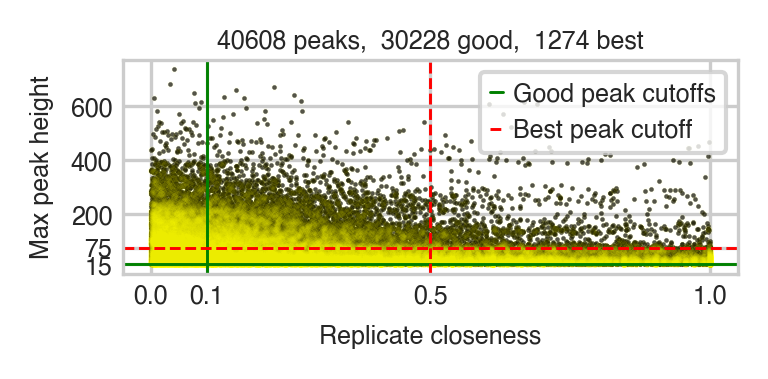

In [51]:
figsize = (65*mm, 32*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.scatterplot(x='quality_p', y='max_height', data=CQ_df, s=1.0, color='k', edgecolor=None, alpha=0.7)
sns.scatterplot(x='quality_p', y='max_height', data=CQ_df, s=2.0, color='yellow', edgecolor=None, alpha=0.05)

q_cutoff = 0.5
h_cutoff = 75
best_peaks = CQ_df[(CQ_df['quality_p'] > q_cutoff) & (CQ_df['max_height'] > h_cutoff)].index

good_peaks = CQ_df[(CQ_df['quality_p'] > 0.1) & (CQ_df['max_height'] > 15)].index

ax.axhline(15, color='green', linewidth=0.7, linestyle='-', label='Good peak cutoffs')
ax.axvline(0.1, color='green', linewidth=0.7, linestyle='-')

ax.axhline(75, color='red', linewidth=0.7, linestyle='--', label='Best peak cutoff')
ax.axvline(q_cutoff, color='red', linewidth=0.7, linestyle='--')

ax.legend()
ax.set_yticks([15,75,200,400,600])
ax.set_xticks([0,0.1,0.5,1.0])

ax.tick_params(axis='both', pad=-1)

ax.set_xlabel('Replicate closeness')
ax.set_ylabel('Max peak height')

#ax.text(0.8, 500, '{} best peaks'.format(len(best_peaks)), ha='center')

plt.suptitle('{} peaks,  {} good,  {} best'.format(len(CQ_df), len(good_peaks), len(best_peaks)),x=0.57, y=1.02)

set_size(fig, figsize)
plt.savefig("Panels/PeakQuality.pdf", bbox_inches='tight')
plt.show()

In [52]:
CQ_df.loc[best_peaks].sort_values(by='quality_p')

clonal_p  quality_p  max_height
PeakID                                         
Interval_14435  0.000399   0.500236  274.752838
Interval_38792  0.315768   0.500381  239.337738
Interval_52656  0.245908   0.500490  233.199524
Interval_77046  0.002226   0.500737  106.823257
Interval_61742  0.000309   0.501026  100.358063
...                  ...        ...         ...
Interval_48516  0.001747   1.000000   78.901146
Interval_24124  0.001747   1.000000   77.107956
Interval_79837  0.001747   1.000000   80.484787
Interval_67000  0.001747   1.000000   80.827042
Interval_10835  0.001747   1.000000   99.624023

[1274 rows x 3 columns]

In [54]:
mindiff_df['clone'] = pd.Series((mindiff_df.index).astype(int)).mod(6)
mindiff_df.groupby('clone').badpeak.sum()

clone
0    314
1    324
2    921
3    755
4     95
5     26
Name: badpeak, dtype: int64

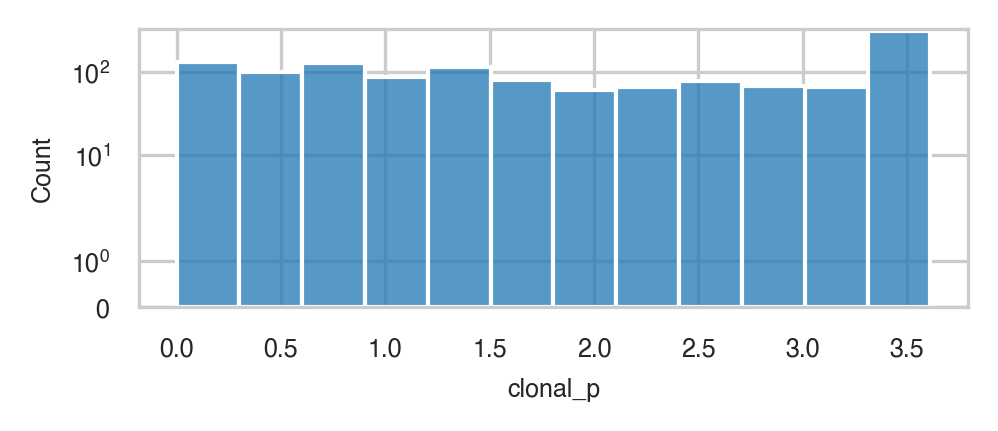

In [55]:
fig,ax = plt.subplots(1,1,figsize=(90*mm, 30*mm), dpi=300)
peaks_logp = -np.log10(CQ_df.loc[best_peaks].clonal_p)
sns.histplot(peaks_logp, ax=ax)
plt.yscale('symlog')
plt.show()

In [56]:
ATACR_data.var.itype.value_counts()

intron          15515
promoter-TSS    12372
Intergen         8433
exon             2276
TTS              2012
Name: itype, dtype: int64

In [57]:
itypes = ['Intergen','intron','promoter-TSS','exon','TTS']

In [58]:
CQ_df['itype'] = ATACR_data.var.itype
CQ_df['good_peak'] = ATAC_data.var['good_peak']
CQ_df

<ipython-input-58-3f1f9c2f0bfb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CQ_df['itype'] = ATACR_data.var.itype
<ipython-input-58-3f1f9c2f0bfb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CQ_df['good_peak'] = ATAC_data.var['good_peak']


clonal_p  quality_p  max_height         itype  good_peak
PeakID                                                                  
Interval_77062  0.045662   0.152552   23.361561        intron       True
Interval_51938  0.000815   0.028703   30.484528      Intergen       True
Interval_33832  0.115377   0.029762   16.173389      Intergen       True
Interval_13433  0.010109   0.010913  301.374023  promoter-TSS       True
Interval_48454  0.540247   0.673157   21.518496        intron       True
...                  ...        ...         ...           ...        ...
Interval_28417  0.115768   0.032045  136.937500  promoter-TSS       True
Interval_58433  0.145547   0.664901   24.210867        intron       True
Interval_45676  0.006693   0.064673   34.971249          exon       True
Interval_8387   0.000257   0.067399  118.396477  promoter-TSS       True
Interval_17712  0.136735   0.062587   16.138868        intron       True

[40608 rows x 5 columns]

Taking 39858 peaks out of 40608, based on quality cutoff of 0.1


itype  total  clonal  perc clonal
Intergen          Intergen   8268    3597     0.435051
intron              Intron  15201    6451     0.424380
promoter-TSS  Promoter-TSS  12190    3778     0.309926
exon                  Exon   2228     809     0.363106
TTS                    TTS   1971     759     0.385084

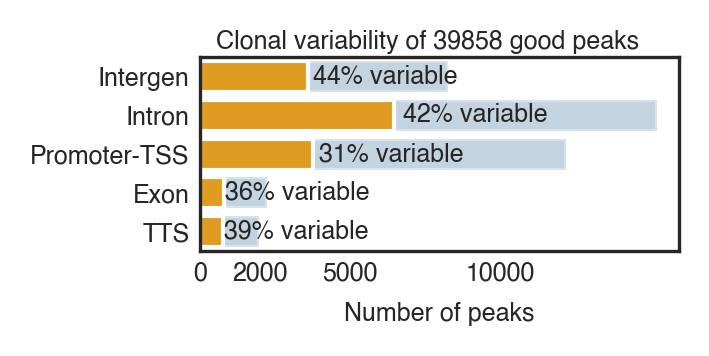

In [59]:
CQ_df_good = CQ_df[CQ_df.good_peak]
print('Taking {} peaks out of {}, based on quality cutoff of 0.1'.format(len(CQ_df_good), len(CQ_df)))
plot_df_totals = CQ_df_good.itype.value_counts()
plot_df_clonal = CQ_df_good[CQ_df_good.clonal_p < 0.01].itype.value_counts()

plot_df = pd.DataFrame(index = plot_df_totals.index)
plot_df['itype'] = [s[0].upper() + s[1:] for s in plot_df.index]
plot_df['total'] = plot_df_totals
plot_df['clonal'] = plot_df_clonal
plot_df['perc clonal'] = plot_df['clonal'] / plot_df['total']
plot_df = plot_df.loc[itypes]
display(plot_df)

sns.set_style('white')
figsize=(60*mm, 30*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)

setfontsize()

sns.barplot(y='itype', x='total', data=plot_df, 
            color='steelblue', edgecolor=None, alpha=0.35, ax=ax, label='Num. peaks',
            orient='h')
sns.barplot(y='itype', x='clonal', data=plot_df, 
                color='orange', label='Variable peaks ($p<0.01$)',
                orient='h', ax=ax)

for j in range(len(plot_df)):
    nsigj = plot_df.iloc[j]['clonal']
    ratioj = plot_df.iloc[j]['perc clonal']
    ax.text(nsigj*1.05,j,'{:1.0%} variable'.format(ratioj), ha='left', va='center')
        
ax.set_xlabel('Number of peaks')
ax.set_ylabel('')
ax.set_xticks([0,2000,5000,10000])
ax.tick_params(axis='both', pad=-1)
plt.suptitle('Clonal variability of {} good peaks'.format(plot_df.total.sum()), y=1.02, x=0.55)
set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks.pdf", bbox_inches='tight')
plt.show()

Taking 13007 best peaks out of 40608


itype  total  clonal  perc clonal
Intergen          Intergen   1263     730     0.577989
intron              Intron   2807    1423     0.506947
promoter-TSS  Promoter-TSS   7738    2213     0.285991
exon                  Exon    826     260     0.314770
TTS                    TTS    373     169     0.453083

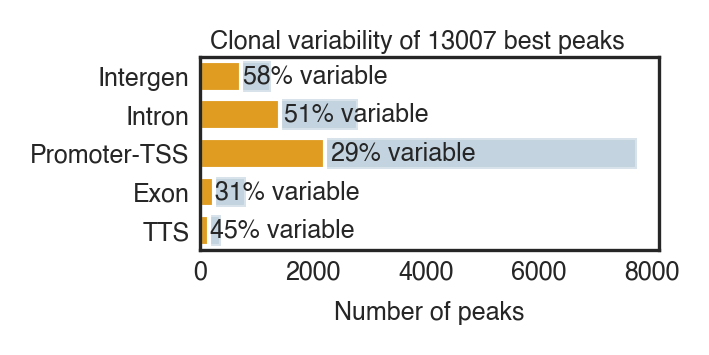

In [60]:
CQ_df_good = CQ_df.loc[CQ_df.good_peak & (CQ_df['max_height'] > 75)].sort_values(by='itype')
print('Taking {} best peaks out of {}'.format(len(CQ_df_good), len(CQ_df)))
plot_df_totals = CQ_df_good.itype.value_counts()
plot_df_clonal = CQ_df_good[CQ_df_good.clonal_p < 0.01].itype.value_counts()

plot_df = pd.DataFrame(index = plot_df_totals.index)
plot_df['itype'] = [s[0].upper() + s[1:] for s in plot_df.index]
plot_df['total'] = plot_df_totals
plot_df['clonal'] = plot_df_clonal
plot_df['perc clonal'] = plot_df['clonal'] / plot_df['total']
plot_df = plot_df.loc[itypes]
display(plot_df)

sns.set_style('white')
figsize=(60*mm, 30*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)

setfontsize()

sns.barplot(y='itype', x='total', data=plot_df, 
            color='steelblue', edgecolor=None, alpha=0.35, ax=ax, label='Num. peaks',
            orient='h')
sns.barplot(y='itype', x='clonal', data=plot_df, 
                color='orange', label='Variable peaks ($p<0.01$)',
                orient='h', ax=ax)

for j in range(len(plot_df)):
    nsigj = plot_df.iloc[j]['clonal']
    ratioj = plot_df.iloc[j]['perc clonal']
    ax.text(nsigj*1.05,j,'{:1.0%} variable'.format(ratioj), ha='left', va='center')
        
ax.set_xlabel('Number of peaks')
ax.set_ylabel('')
#ax.set_xticks([0,2000,5000,10000])
ax.tick_params(axis='both', pad=-1)
plt.suptitle('Clonal variability of {} best peaks'.format(plot_df.total.sum()), y=1.02, x=0.55)
set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks.pdf", bbox_inches='tight')
plt.show()

# Clonal peaks near clonal genes

In [61]:
good_peaks = ATAC_data.var[ATAC_data.var.good_peak].index
len(good_peaks)

39858

In [62]:

ATAC_genes = ATAC_data.var.loc[good_peaks].in_gene.unique() # Look only at genes with peaks annotated
ATAC_genes = [gene for gene in ATAC_genes if gene in adata.var_names] # Look only at genes in gene expression matrix

adata.var['Expressed'] = ((adata.to_df() > np.log1p(10)).sum() > 3) # Look only at expressed genes.
ATAC_genes = [gene for gene in ATAC_genes if adata.var.Expressed[gene]] # Look only at expressed genes.

len(ATAC_genes)

7937

In [63]:
len(good_peaks)

39858

In [64]:
pg_clonal_df = pd.DataFrame(index=ATAC_genes)
pg_clonal_df['Nearby peak variability'] = CQ_df.loc[good_peaks].groupby(ATAC_data.var.in_gene)['clonal_p'].min()
pg_clonal_df['Gene clonality'] = adata.var.loc[ATAC_genes].F_pval
display(pg_clonal_df)

Nearby peak variability  Gene clonality
PTBP3                   0.045662        0.997113
CCDC90B                 0.010109        0.000002
SLC4A7                  0.005134        0.532685
ZFP90                   0.018765        0.041443
ILF2                    0.000798        0.082583
...                          ...             ...
MTF1                    0.008733        0.339665
RRP8                    0.010778        0.744328
AASDH                   0.287523        0.636600
MSMO1                   0.002527        0.018782
MVD                     0.115768        0.987022

[7937 rows x 2 columns]

In [65]:
for g_cut in [1, 0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]:
    g_df = pg_clonal_df[pg_clonal_df['Gene clonality'] <= g_cut]['Nearby peak variability']
    num_withclonalpeaks = (g_df < 0.01).sum()
    num_total = len(g_df)
    print('Among {} genes with clonality p < {}, '
          '{:1.2%} have a clonally variable peak nearby.'.format(num_total, g_cut, num_withclonalpeaks / num_total))


Among 7937 genes with clonality p < 1, 44.69% have a clonally variable peak nearby.
Among 1604 genes with clonality p < 0.05, 47.01% have a clonally variable peak nearby.
Among 743 genes with clonality p < 0.01, 52.22% have a clonally variable peak nearby.
Among 319 genes with clonality p < 0.001, 57.05% have a clonally variable peak nearby.
Among 152 genes with clonality p < 0.0001, 61.18% have a clonally variable peak nearby.
Among 77 genes with clonality p < 1e-05, 64.94% have a clonally variable peak nearby.
Among 56 genes with clonality p < 1e-06, 69.64% have a clonally variable peak nearby.
Among 41 genes with clonality p < 1e-07, 65.85% have a clonally variable peak nearby.
Among 23 genes with clonality p < 1e-08, 60.87% have a clonally variable peak nearby.
Among 16 genes with clonality p < 1e-09, 62.50% have a clonally variable peak nearby.


In [66]:
gene_peaks = [peak for peak in good_peaks if ATAC_data.var.in_gene[peak] in adata.var_names]
gene_peaks = [peak for peak in gene_peaks if adata.var.Expressed[ATAC_data.var.in_gene[peak]]]

len(gene_peaks) # peaks which are annotated to an expressed gene.

18617

In [67]:
CQG_df = CQ_df.loc[gene_peaks].copy()
CQG_df['gene'] = ATAC_data.var.in_gene
CQG_df['gene_clonality'] = 1.0
for peak in CQG_df.index:
    gene = CQG_df.loc[peak, 'gene']
    CQG_df.loc[peak, 'gene_clonality'] = adata.var.loc[gene, 'F_pval']
CQG_df

clonal_p  quality_p  max_height         itype  good_peak  \
PeakID                                                                     
Interval_77062  0.045662   0.152552   23.361561        intron       True   
Interval_13433  0.010109   0.010913  301.374023  promoter-TSS       True   
Interval_48454  0.540247   0.673157   21.518496        intron       True   
Interval_27763  0.024386   0.107762   55.443855  promoter-TSS       True   
Interval_4280   0.000798   0.016621  189.036224  promoter-TSS       True   
...                  ...        ...         ...           ...        ...   
Interval_33873  0.405540   0.149024   88.259521        intron       True   
Interval_56910  0.002527   0.006778  337.950592  promoter-TSS       True   
Interval_28417  0.115768   0.032045  136.937500  promoter-TSS       True   
Interval_45676  0.006693   0.064673   34.971249          exon       True   
Interval_8387   0.000257   0.067399  118.396477  promoter-TSS       True   

                     gene  gene_clonality  
PeakID                                     
Interval_77062      PTBP3        0.997113  
Interval_13433    CCDC90B        0.000002  
Interval_48454     SLC4A7        0.532685  
Interval_27763      ZFP90        0.041443  
Interval_4280        ILF2        0.082583  
...                   ...             ...  
Interval_33873      MOB3A        0.024728  
Interval_56910      MSMO1        0.018782  
Interval_28417        MVD        0.987022  
Interval_45676  LINC00649        0.138642  
Interval_8387        NRP1        0.148086  

[18617 rows x 7 columns]

In [68]:
CQG_df.to_csv('Peaks_Genes_Clonalityscores.csv')

## Check for batch effects in best peaks

In [69]:
ATAC_good = ATAC_data[:, good_peaks]
ATAC_good_z = (ATAC_good.to_df() - ATAC_good.to_df().mean()) / ATAC_good.to_df().std()
ATAC_good_z = ATAC_good_z[ATAC_good_z.columns.sort_values()]
ATAC_good_zsum = pd.DataFrame(ATAC_good_z.sum(axis=1))
ATAC_good_zsum.columns = ['zsum']
ATAC_good_zsum['z_adj'] = ATAC_good_zsum['zsum'] / ATAC_good_z.shape[1]
ATAC_good_zsum['clone'] = ATAC_data.obs.ATAC_clone
ATAC_good_zsum['cell_number'] = ATAC_good.obs['Cell Number']
ATAC_good_zsum

zsum     z_adj  clone  cell_number
Sample_name                                           
P9855_2085    569.856934  0.014297   1_R1       1000.0
P9855_2093   1747.734863  0.043849   1_R2       1000.0
P9855_2092  -1717.620850 -0.043094  10_R1        350.0
P9855_2097  -4047.461914 -0.101547  11_R1        269.0
P9855_2099  -1140.467041 -0.028613  13_R1        500.0
P9855_2100  -1353.730469 -0.033964  14_R1        500.0
P9855_2101    189.816223  0.004762  15_R1       1000.0
P9855_2102    225.720337  0.005663  15_R2       1000.0
P9855_2103  -1938.710938 -0.048640  16_R1        700.0
P9855_2106  -1273.306152 -0.031946  17_R1       1000.0
P9855_2105   1018.047119  0.025542  18_R1       1000.0
P9855_2107   1615.850708  0.040540  19_R1       1000.0
P9855_2086    231.026398  0.005796   2_R1        705.0
P9855_2108    523.711670  0.013139  20_R1        918.0
P9855_2109   1082.190552  0.027151  21_R1       1000.0
P9855_2110    585.635986  0.014693  22_R1       1000.0
P9855_2111    746.553101  0.018730  22_R2       1000.0
P9855_2104    465.051208  0.011668  23_R1       1000.0
P9855_2112    346.600159  0.008696  23_R2       1000.0
P9855_2113  -1895.470703 -0.047556  24_R1       1000.0
P9855_2094  -1757.519043 -0.044095   3_R1        506.0
P9855_2087   -203.645264 -0.005109   4_R1        410.0
P9855_2098    799.581543  0.020061  5a_R1        500.0
P9855_2095   1015.153320  0.025469  5b_R1       1000.0
P9855_2088   -314.402435 -0.007888   7_R1       1000.0
P9855_2089    660.235291  0.016565   8_R1       1000.0
P9855_2090    529.176514  0.013277   8_R2       1000.0
P9855_2091   1773.454468  0.044494   9_R1       1000.0
P9855_2096   1517.012085  0.038060   9_R2       1000.0

# Panel:  Peak heatmap

1000 peaks with p < 0.00024451508213430007


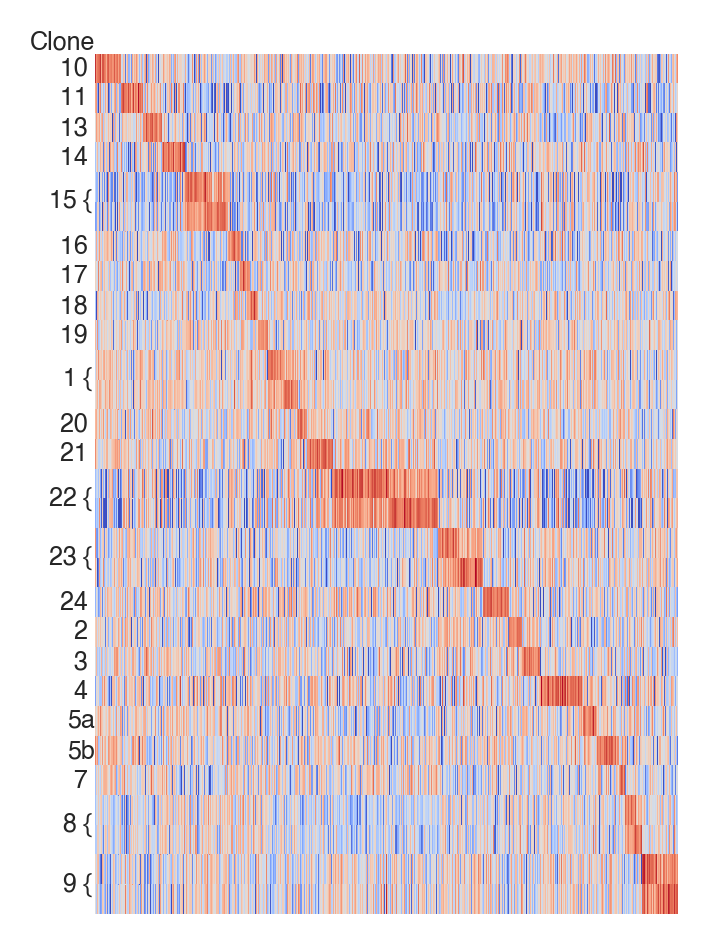

In [70]:
var_peaks = ATAC_good.var.clonal_p.sort_values()[:1000]
print('{} peaks with p < {}'.format(len(var_peaks), var_peaks.max()))
var_peaks = var_peaks.index
plot_df = ATAC_good.to_df()[var_peaks].copy()

plot_df.index = ATAC_good.obs.ATAC_clone
plot_df.sort_index(inplace=True)

plot_df = (plot_df - plot_df.mean()) / plot_df.std()

#display(plot_df.idxmax().sort_values())

var_peaks = plot_df.idxmax().sort_values().index
plot_df = plot_df[var_peaks]

figsize=(60*mm, 80*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.heatmap(plot_df, vmin=-2.5, vmax=2.5, cmap='coolwarm', 
            xticklabels=False, yticklabels=False,
            cbar=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
for y,clone in [(11,1), (5,15), (15,22), (17,23), (26,8), (28,9)]:
    ax.text(-5,y,str(clone) + ' {', va='center', ha='right', fontsize=6)
    
for j,clone in enumerate(plot_df.index):
    par = clone.split('_')[0]
    if par not in ['1','15','22','23','8','9','5a','5b']:
        ax.text(-0.1,j+0.5,par + ' ', va='center', ha='right', fontsize=6)
    
ax.text(-0.1,22.5,'5a', va='center', ha='right', fontsize=6)
ax.text(-0.1,23.5,'5b', va='center', ha='right', fontsize = 6)


ax.text(0.5,0,'Clone', va='bottom', ha='right', fontsize=6)
#plt.suptitle('{} clonal peaks, {} samples'.format(len(var_peaks), len(plot_df)), y=0.95)
set_size(fig, figsize)
plt.savefig("Panels/PeakHeatmap.pdf", bbox_inches='tight')

plt.show()

In [71]:
len(best_peaks)

1274

In [72]:
var_peaks = best_peaks

plot_df = ATAC_good.to_df()[var_peaks].copy()

plot_df.index = ATAC_good.obs.ATAC_clone
plot_df.sort_index(inplace=True)

plot_df = (plot_df - plot_df.mean()) / plot_df.std()

#display(plot_df.idxmax().sort_values())

var_peaks = plot_df.idxmax().sort_values().index
plot_df = plot_df[var_peaks]

figsize=(60*mm, 80*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.heatmap(plot_df, vmin=-2.5, vmax=2.5, cmap='coolwarm', 
            xticklabels=False, yticklabels=False,
            cbar=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
for y,clone in [(11,1), (5,15), (15,22), (17,23), (26,8), (28,9)]:
    ax.text(-5,y,str(clone) + ' {', va='center', ha='right', fontsize=6)
    
for j,clone in enumerate(plot_df.index):
    par = clone.split('_')[0]
    if par not in ['1','15','22','23','8','9','5a','5b']:
        ax.text(-0.1,j+0.5,par + ' ', va='center', ha='right', fontsize=6)
    
ax.text(-0.1,22.5,'5a', va='center', ha='right', fontsize=6)
ax.text(-0.1,23.5,'5b', va='center', ha='right', fontsize = 6)


ax.text(0.5,0,'Clone', va='bottom', ha='right', fontsize=6)
plt.suptitle('')
# plt.suptitle('{} best peaks, {} samples'.format(len(var_peaks), len(plot_df)), y=0.95)
set_size(fig, figsize)
plt.savefig("Panels/PeakBestHeatmap.pdf", bbox_inches='tight')

plt.show()

KeyError: "['Interval_5341', 'Interval_32384', 'Interval_79403', 'Interval_59631', 'Interval_14044', 'Interval_50641', 'Interval_3116', 'Interval_69657', 'Interval_68802', 'Interval_60333', 'Interval_27076', 'Interval_40239', 'Interval_6067', 'Interval_52681', 'Interval_3682', 'Interval_34606', 'Interval_6486', 'Interval_11700', 'Interval_31907', 'Interval_42324', 'Interval_60165', 'Interval_26733', 'Interval_37574', 'Interval_42183', 'Interval_28945', 'Interval_66558', 'Interval_64666', 'Interval_36827', 'Interval_1170', 'Interval_77883', 'Interval_35291', 'Interval_67786', 'Interval_80133', 'Interval_20915', 'Interval_30416', 'Interval_18623', 'Interval_15046', 'Interval_70882', 'Interval_6418', 'Interval_10694', 'Interval_36196', 'Interval_7420', 'Interval_47526', 'Interval_20845', 'Interval_79491', 'Interval_25658', 'Interval_36454'] not in index"

Here are the genes near the most clonal peaks, in order.

In [ ]:
var_peaks = ATAC_good.var.clonal_p.sort_values()[:1000].index

near_genes = ATACR_data.var.loc[plot_df.columns].in_gene
near_genes = near_genes[near_genes != 'nan']
near_genes = near_genes[near_genes.isin(adata.var_names)]
near_genes = near_genes.values
near_genes

# Peak-gene correlations

Now we create a giant correlation matrix -- one for each chromosome -- between gene expression (clonal average) and peak height (clonal average), for all genes and peaks on that chromosome.  We only use the "good clones" (16 out of 24 clones) found in preprocessing, when computing these correlations.  We also restrict to "good" peaks, where replicates have close peak heights.

In [ ]:
genes = adata.var_names
genes

In [73]:
ATAC_good

View of AnnData object with n_obs × n_vars = 29 × 39858
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence', 'colorclone'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start', 'quality_p', 'clonal_p', 'replicate_foldchange', 'max_height', 'good_peak'

In [74]:
peaks = ATAC_data.var_names
peaks

Index(['Interval_77062', 'Interval_51938', 'Interval_33832', 'Interval_13433',
       'Interval_48454', 'Interval_27763', 'Interval_53540', 'Interval_4280',
       'Interval_6501', 'Interval_68580',
       ...
       'Interval_69022', 'Interval_56910', 'Interval_27261', 'Interval_76540',
       'Interval_57434', 'Interval_28417', 'Interval_58433', 'Interval_45676',
       'Interval_8387', 'Interval_17712'],
      dtype='object', name='PeakID', length=40608)

In [75]:
chromes = [str(j) for j in range(1,23)] + ['X','Y']
print(chromes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']


For each of the good clones, we create dataframes of the clonal averages for gene expression and peak height.

In [76]:
test_clones = adata.obs[adata.obs['Good clone'] == True].Clone_ID.unique()
test_clones = [clone for clone in test_clones if clone in ATAC_data.obs.Clone_ID.unique()]

pd_peak = ATAC_data[ATAC_data.obs['Clone_ID'].isin(test_clones)]
pd_gene = adata[adata.obs['Clone_ID'].isin(test_clones)]

gene_clonal = pd_gene.to_df().groupby(pd_gene.obs.Clone_ID).mean()
peak_clonal = pd_peak.to_df().groupby(pd_peak.obs.Clone_ID).mean()

In [77]:
gene_clonal

gene_name  MTND2P28  hsa-mir-6723  MTATP6P1  RP11-206L10.9  LINC01128  \
Clone_ID                                                                
P1_A03     3.230169      2.079046  5.749669       0.000000   0.000000   
P1_A05     2.709148      1.453811  5.383322       0.000000   0.000000   
P1_A08     3.050509      1.614846  5.801980       0.000000   0.000000   
P1_A12     3.035853      1.859284  5.475892       0.887302   0.958630   
P1_B10     3.112417      2.253648  5.691962       0.000000   0.902409   
P1_C11     2.745569      1.978039  5.837260       0.000000   0.000000   
P1_D09     2.575861      1.505550  5.739470       0.948192   1.076902   
P1_F10     2.922449      1.693547  5.865429       0.000000   0.000000   
P1_H01     3.106876      1.949256  5.824675       0.000000   0.000000   
P1_H10     2.250069      1.485239  5.613591       0.000000   0.000000   
P2_A04     3.237091      1.334472  5.566094       0.957045   0.000000   
P2_B11     3.307103      2.163680  5.705452       1.188340   0.000000   
P2_G01     3.005000      0.545083  4.770329       0.000000   0.000000   
P2_G09     2.708898      1.455621  5.396387       0.000000   1.132141   
P2_H04     2.315471      1.711872  5.294865       0.351379   0.000000   
P2_H05     2.047147      0.479275  4.363872       0.000000   0.000000   

gene_name     NOC2L     ISG15  RP11-465B22.3  TNFRSF18   TNFRSF4  ...  \
Clone_ID                                                          ...   
P1_A03     2.308283  7.334683       0.000000  3.254865  1.157134  ...   
P1_A05     2.970573  6.024615       0.000000  4.569802  1.087413  ...   
P1_A08     0.000000  7.358630       0.000000  5.370294  1.082879  ...   
P1_A12     2.351700  6.635680       0.000000  5.170679  0.412726  ...   
P1_B10     2.168520  6.953883       1.071905  5.509768  0.000000  ...   
P1_C11     2.254454  4.855477       0.000000  3.198215  0.000000  ...   
P1_D09     1.631425  5.360824       3.277528  4.126095  2.221344  ...   
P1_F10     2.471754  6.654633       1.307794  3.869681  1.221896  ...   
P1_H01     2.190555  6.236783       0.000000  3.081303  0.337937  ...   
P1_H10     3.127002  5.592022       0.000000  4.690275  0.942922  ...   
P2_A04     1.419956  5.599187       0.000000  3.480796  0.000000  ...   
P2_B11     2.022410  5.456667       0.000000  1.635330  1.342189  ...   
P2_G01     1.528105  8.190660       0.000000  0.885717  0.000000  ...   
P2_G09     0.000000  6.837132       0.000000  4.499185  0.000000  ...   
P2_H04     0.000000  5.778849       0.000000  3.573749  0.000000  ...   
P2_H05     0.000000  5.500018       0.000000  0.172438  0.147221  ...   

gene_name      F8-1  FUNDC2-1   BRCC3-1    VBP1-1  RAB39B-1   TMLHE-1  \
Clone_ID                                                                
P1_A03     0.000000  2.843147  2.523289  3.442465  0.000000  0.000000   
P1_A05     0.000000  3.934277  3.737265  4.640422  0.000000  1.077093   
P1_A08     1.002046  4.011677  2.558638  4.284044  0.000000  2.961611   
P1_A12     0.224331  4.294168  2.767888  4.635580  0.864102  3.820885   
P1_B10     0.000000  2.429938  0.000000  2.663473  0.772005  3.728553   
P1_C11     0.000000  2.998382  1.462838  3.882571  0.891281  1.206362   
P1_D09     0.548206  3.907003  3.097841  4.354332  0.685584  1.847692   
P1_F10     1.232553  1.618218  3.844646  4.177619  0.901349  0.000000   
P1_H01     0.000000  2.998327  2.415796  4.209680  0.000000  1.493295   
P1_H10     0.000000  2.596592  1.918516  4.173988  0.000000  0.761494   
P2_A04     0.000000  3.139159  0.000000  2.827251  0.000000  2.954389   
P2_B11     0.000000  3.682788  2.343420  4.453341  0.000000  4.217452   
P2_G01     0.000000  1.196341  1.552464  0.000000  0.000000  1.926167   
P2_G09     0.000000  3.030712  1.711892  4.846723  2.136081  0.000000   
P2_H04     0.000000  2.841082  0.465016  2.514537  1.168372  0.000000   
P2_H05     0.000000  4.360162  0.000000  0.000000  1.405290  0.000000   

gene_name     VAMP7     SRIP3  AC010970.2  RNA5-8SP6  


In [78]:
peak_clonal

PeakID    Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
Clone_ID                                                                   
P1_A03          2.397638        2.529633        2.150198        5.617923   
P1_A05          2.717578        1.972389        2.088377        5.437860   
P1_A08          2.928915        2.287843        1.691356        5.560565   
P1_A12          2.225148        2.426444        2.426444        5.683740   
P1_B10          2.987230        1.853198        2.670728        5.436592   
P1_C11          2.751107        2.591159        1.970270        5.644123   
P1_D09          2.464640        3.449496        2.299183        5.493403   
P1_F10          2.149178        2.824024        2.065458        5.619921   
P1_H01          2.556990        1.892109        2.524847        5.518234   
P1_H10          2.260768        2.869512        2.697917        5.432869   
P2_A04          2.370404        2.967492        2.469283        5.697934   
P2_B11          2.246812        0.000000        2.714423        5.558466   
P2_G01          1.948509        2.775430        2.623850        5.629741   
P2_G09          2.707259        2.128885        1.243721        5.444118   
P2_H04          2.718706        1.969373        2.339709        5.705107   
P2_H05          2.027774        2.000840        1.945744        5.533689   

PeakID    Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
Clone_ID                                                                  
P1_A03          1.967855        3.278499        3.233557       4.882648   
P1_A05          0.633384        3.517708        2.451669       5.108484   
P1_A08          2.287843        3.709698        3.762476       5.194549   
P1_A12          1.119627        3.585825        3.326052       5.100070   
P1_B10          2.205004        3.504991        3.114438       5.243369   
P1_C11          1.856460        3.638525        3.083403       5.247215   
P1_D09          3.114337        3.700081        3.607240       5.154146   
P1_F10          1.974084        3.443976        3.507894       5.158548   
P1_H01          1.727383        3.856328        3.475958       5.182631   
P1_H10          2.418915        3.799819        1.578473       5.147631   
P2_A04          2.166221        3.824545        0.732249       5.182442   
P2_B11          2.246812        4.033247        3.964330       5.195662   
P2_G01          1.707229        3.436920        2.986031       5.123996   
P2_G09          1.243721        3.869145        2.991982       5.031900   
P2_H04          2.115431        3.431467        1.571595       5.082010   
P2_H05          1.454262        3.602494        0.553023       5.061416   

PeakID    Interval_6501  Interval_68580  ...  Interval_69022  Interval_56910  \
Clone_ID                                 ...                                   
P1_A03         4.752263        5.469793  ...        4.176711        5.725381   
P1_A05         4.493093        5.533124  ...        4.421364        5.751973   
P1_A08         4.519068        5.543390  ...        3.949484        5.814805   
P1_A12         4.740612        5.524294  ...        4.205272        5.802704   
P1_B10         4.985421        5.780162  ...        4.261869        5.647071   
P1_C11         4.287120        5.610814  ...        4.035187        5.825854   
P1_D09         4.445949        5.408775  ...        4.487143        5.763301   
P1_F10         4.699069        5.427788  ...        4.216893        5.746419   
P1_H01         4.508285        5.476674  ...        4.231659        5.612613   
P1_H10         4.061644        5.429313  ...        4.128048        5.493102   
P2_A04         4.576645        5.627039  ...        4.219496        5.726516   
P2_B11         4.471122        5.540189  ...        4.345335        5.734086   
P2_G01         4.585413        5.571364  ...        4.251483        5.548196   
P2_G09         4.856232        5.418911  ...        4.402289        5.577108   


The following function creates the giant correlation matrix.

In [79]:
def pg_corr(chrome, method='pearson'):
    pd_peak = peak_clonal.loc[:,ATAC_data.var.chr == chrome]
    pd_gene = gene_clonal.loc[:,adata.var.chr == chrome]
    
    print('Making corr. matrix for chromosome {} with {} peaks and {} genes.'.format(
        chrome, pd_peak.shape[1], pd_gene.shape[1]))

    A = pd_peak
    E = pd_gene
    
    if method == 'spearman':
        A = A.rank()
        E = E.rank()
    Az = (A - A.mean())
    Ez = (E - E.mean())
    C = Az.T.dot(Ez).div(len(A)).div(Ez.std(ddof=0)).div(Az.std(ddof=0), axis=0)
    return C.sort_index()

It will take just a few seconds to make the correlation matrices for every chromosome.

In [80]:
pg_corrs = {}
for chrome in chromes:
    pg_corrs[chrome] = pg_corr(chrome).fillna(0)

Making corr. matrix for chromosome 1 with 3887 peaks and 1009 genes.
Making corr. matrix for chromosome 2 with 3265 peaks and 667 genes.
Making corr. matrix for chromosome 3 with 2558 peaks and 569 genes.
Making corr. matrix for chromosome 4 with 1574 peaks and 348 genes.
Making corr. matrix for chromosome 5 with 2005 peaks and 444 genes.
Making corr. matrix for chromosome 6 with 2556 peaks and 509 genes.
Making corr. matrix for chromosome 7 with 1977 peaks and 444 genes.
Making corr. matrix for chromosome 8 with 1623 peaks and 304 genes.
Making corr. matrix for chromosome 9 with 1624 peaks and 362 genes.
Making corr. matrix for chromosome 10 with 1849 peaks and 367 genes.
Making corr. matrix for chromosome 11 with 1995 peaks and 526 genes.
Making corr. matrix for chromosome 12 with 2103 peaks and 540 genes.
Making corr. matrix for chromosome 13 with 893 peaks and 174 genes.
Making corr. matrix for chromosome 14 with 1392 peaks and 323 genes.
Making corr. matrix for chromosome 15 with 

# Looking at correlations within windows.

We look at peaks within a window around each gene.  For a close-up look, we consider peaks within 50kb upstream of the TSS, together with the region between the gene start and end sites.  (We add a little 5kb wiggle-room too.)  For a broader look, we look at peaks within 500kb of the TSS.  The following function finds the peaks within such windows around a given gene.

In [81]:
def peaks_near(gene, window=50000, tol = 5000.0, method='TSSUp'):
    gene_chrome = adata.var.chr[gene]
    gene_TSS = adata.var.TSS[gene]
    gene_start = adata.var.start[gene]
    gene_end = adata.var.end[gene]
    gene_dir = adata.var.dir[gene]

    p_df = ATAC_good.var[ATAC_good.var.chr == gene_chrome]
    dist_peak_TSS = gene_dir * (gene_TSS - p_df.mid)
    if method == 'TSSCenter':
        p_range = abs(dist_peak_TSS) < window
    elif method == 'TSSUp':
        up_range = (dist_peak_TSS < window) & (dist_peak_TSS >= -tol)
        in_range = (p_df.mid > gene_start - tol) & (p_df.mid < gene_end + tol)
        p_range = up_range | in_range
    else:
        print('Method unknown.')
        return None
    p_df = p_df[p_range]
    return p_df.index

The following function adds up the coefficients of determination for all peaks within a window around a gene. 

In [82]:
def total_corr_near(gene, window=500000):
    pn = peaks_near(gene, window, method='TSSCenter')
    gene_chrome = adata.var.chr[gene]
    R_list = pg_corrs[gene_chrome][gene][pn]
    R_sq_list_pos = R_list.clip(0,1)**2
    R_sq_list_neg = R_list.clip(-1,0)**2
    R_sq_list = R_list**2
    loc_list = ATAC_good.var.loc[pn].mid - adata.var.TSS[gene]
    tcn_df = pd.DataFrame(index=pn)
    tcn_df['R_sq'] = R_sq_list
    tcn_df['R_sq_pos'] = R_sq_list_pos
    tcn_df['R_sq_neg'] = R_sq_list_neg
    tcn_df['relative_loc'] = loc_list
    tcn_df['loc_bin'] = pd.cut(loc_list, bins=np.arange(-500000,500001,5000))
    return tcn_df.drop('relative_loc', axis=1).groupby('loc_bin').sum()

In [83]:
tcn = total_corr_near('GNLY')
tcn

R_sq  R_sq_pos  R_sq_neg
loc_bin                                         
(-500000, -495000]  0.010342       0.0  0.010342
(-495000, -490000]  0.000000       0.0  0.000000
(-490000, -485000]  0.000000       0.0  0.000000
(-485000, -480000]  0.000000       0.0  0.000000
(-480000, -475000]  0.000000       0.0  0.000000
...                      ...       ...       ...
(475000, 480000]    0.000000       0.0  0.000000
(480000, 485000]    0.000000       0.0  0.000000
(485000, 490000]    0.000000       0.0  0.000000
(490000, 495000]    0.000000       0.0  0.000000
(495000, 500000]    0.000000       0.0  0.000000

[200 rows x 3 columns]

We add up the peak-correlations within a 500000bp window around every gene.  This will take a minute or two.

In [82]:
TSS_intervals = tcn.index
genes_chrome = [gene for gene in genes if adata.var.chr[gene] in chromes]

TSS_plot = pd.DataFrame(index = TSS_intervals, columns=genes_chrome)
TSS_pos_plot = pd.DataFrame(index = TSS_intervals, columns=genes_chrome)
TSS_neg_plot = pd.DataFrame(index = TSS_intervals, columns=genes_chrome)

for j,gene in enumerate(genes_chrome):
    if j%1000 == 0:
        print('{} genes complete'.format(j))
    tcn = total_corr_near(gene)
    TSS_plot[gene] = tcn.R_sq
    TSS_pos_plot[gene] = tcn.R_sq_pos
    TSS_neg_plot[gene] = tcn.R_sq_neg

0 genes complete
1000 genes complete
2000 genes complete
3000 genes complete
4000 genes complete
5000 genes complete
6000 genes complete
7000 genes complete
8000 genes complete
9000 genes complete


## Panel:  Total R^2 for peak~gene within 500kb of TSS.

In [83]:
plot_df = pd.DataFrame(TSS_plot.sum(axis=1), columns=['Total R^2'])
plot_df['x'] = np.arange(-500000,500000, 5000) + 2500
plot_df['Pos R^2'] = TSS_pos_plot.sum(axis=1)
plot_df['Neg R^2'] = TSS_neg_plot.sum(axis=1)

plot_df.head()

Total R^2       x    Pos R^2    Neg R^2
loc_bin                                                    
(-500000, -495000]  61.942884 -497500  26.148194  35.794690
(-495000, -490000]  60.585883 -492500  30.157003  30.428879
(-490000, -485000]  65.135348 -487500  31.886166  33.249182
(-485000, -480000]  63.027914 -482500  30.803029  32.224885
(-480000, -475000]  61.104490 -477500  24.940838  36.163652

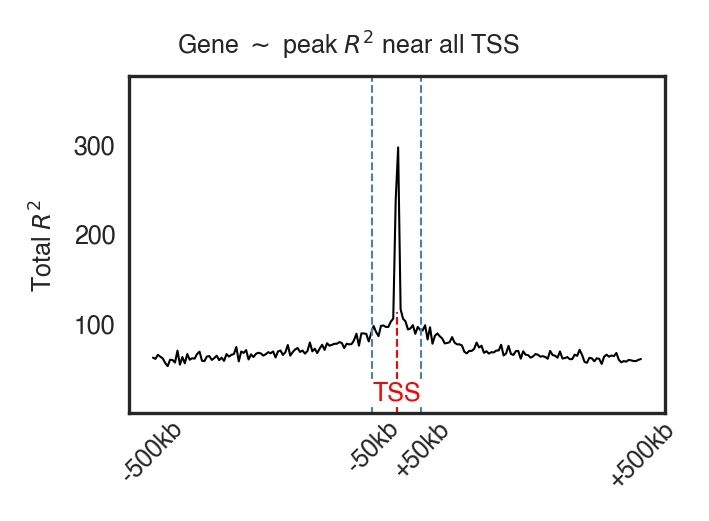

In [84]:

sns.set_style('white')
figsize=(60*mm, 40*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

sns.lineplot(x='x', y='Total R^2', data=plot_df,  color='k', linewidth=0.5, ax=ax)
#sns.lineplot(x='x', y='Pos R^2', data=plot_df,  color='darkgreen', linewidth=0.5, ax=ax)
#sns.lineplot(x='x', y='Neg R^2', data=plot_df,  color='darkred', linewidth=0.5, ax=ax)

ax.set_ylim(0,375)
ax.axvline(0,color='red', linestyle='--', ymax=0.3, linewidth=0.5)
ax.set_xticks([-500000,-50000,50000,500000])
ax.set_xticklabels(['-500kb','-50kb','+50kb','+500kb'], rotation=45, y=0.08)
ax.set_yticks([100,200,300])
ax.set_yticklabels([100,200,300], x=0.03)
ax.text(0,15,'TSS',color='red', ha='center', bbox={'facecolor':'white',  'pad':0})
ax.axvline(50000,color='steelblue',linestyle='--',linewidth=0.5)
ax.axvline(-50000,color='steelblue',linestyle='--',linewidth=0.5)
ax.set_xlabel('')
ax.set_ylabel('Total $R^2$')
set_size(fig, figsize)
plt.savefig("Panels/R2_near_TSS.pdf", bbox_inches='tight')
plt.suptitle('Gene $\sim$ peak $R^2$ near all TSS', y=1.02)
plt.show()

## Computation of background R^2 values

For each gene, we look at the R^2 values for correlations with all peaks on the same chromosome.  This gives a sense of "background noise" to filter out.  It's probably best to leave off the Y-chromosome, since we have so few genes there!

In [84]:
pg_corrs['Y']

Empty DataFrame
Columns: [SRIP3, AC010970.2, RNA5-8SP6]
Index: []

We use the 95th percentile of all R^2 values with peaks on the same gene, as a cutoff for "significant correlation".  For example, here are those 95th percentiles for genes on chromosome 2.  

In [85]:
(pg_corrs['2']**2).quantile(0.95).sort_values()

gene_name
AC027612.6     0.153872
SRSF7          0.164976
ADI1           0.165275
EXOC6B         0.167080
ASXL2          0.168675
                 ...   
FAM49A         0.351521
LINC00954      0.363019
FAM228B        0.372761
AC073046.25    0.386603
FARP2          0.408369
Name: 0.95, Length: 667, dtype: float64

In [86]:
R2_sigs = pd.Series(index=adata.var_names, dtype=np.float64)
for chrome in chromes:
    if chrome != 'Y':
        chrome_genes = pg_corrs[chrome].columns
        R2_sigs.loc[chrome_genes] = (pg_corrs[chrome]**2).quantile(0.95)
display(R2_sigs.sort_values())

gene_name
SSU72            0.133806
AC074138.3       0.134020
SPIRE1           0.135146
ATG9B            0.137953
CTD-2035E11.3    0.139729
                   ...   
MT-TT                 NaN
MT-TP                 NaN
SRIP3                 NaN
AC010970.2            NaN
RNA5-8SP6             NaN
Length: 9553, dtype: float64

In [87]:
R2_sigs.describe()

count    9517.000000
mean        0.248924
std         0.044604
min         0.133806
25%         0.217594
50%         0.243375
75%         0.274635
max         0.464761
dtype: float64

So on average, we view a R^2 value above 0.25 as statistically significant.  But this value fluctuated from one gene to another.  The number could be as low as 0.12 or as high as 0.47 in extreme cases.

# Areas of concentrated clonal peaks

In [88]:
clonal_roll = {}

for chrome in chromes:
    pc_df = ATAC_data.var[ATAC_data.var['chr'] == chrome][['mid','quality_p','clonal_p']].copy()
    pc_df = pc_df[pc_df.quality_p > 0.1] # Only high-quality peaks.
    pc_df = pc_df.sort_values(by='mid')
    pc_df['log_clonal'] = -np.log10(pc_df['clonal_p'])
    clonal_roll[chrome] = pd.DataFrame(pc_df.rolling(window=30, on='mid')['log_clonal'].sum().dropna())
    clonal_roll[chrome].columns = ['c_score']
    clonal_roll[chrome]['mid'] = pc_df['mid']
    print('On chromosome {}, look around the following intervals for clonal peaks.'.format(chrome))
    display(clonal_roll[chrome].sort_values(by='c_score')[-2:])
    hrule()

On chromosome 1, look around the following intervals for clonal peaks.


c_score          mid
PeakID                               
Interval_5092  73.080916  173520218.0
Interval_5088  74.019438  173403299.0

On chromosome 2, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_36727  74.107568    7058024.0
Interval_40524  74.206293  149326354.0

On chromosome 3, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_50965  73.564514  122399143.0
Interval_50962  74.689165  122328979.5

On chromosome 4, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_53597  71.979235  10589491.5
Interval_53615  72.279258  11430344.5

On chromosome 5, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_60289  63.759998  131563546.5
Interval_60334  63.816599  132024325.5

On chromosome 6, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_66792  72.039921  158957808.5
Interval_66794  72.562980  158986073.0

On chromosome 7, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_68435  73.734109  38402630.5
Interval_68434  74.086112  38398381.0

On chromosome 8, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_73913  69.749217  116601355.5
Interval_73911  70.050247  116588887.5

On chromosome 9, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_75990  72.434025  73107122.5
Interval_75988  73.587352  73034667.5

On chromosome 10, look around the following intervals for clonal peaks.


c_score         mid
PeakID                              
Interval_8660  74.249830  50462746.5
Interval_8661  74.572217  50480812.5

On chromosome 11, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_14046  76.105415  111445483.0
Interval_14044  76.415231  111411495.5

On chromosome 12, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_17628  70.056531  95043961.5
Interval_17632  70.782986  95156530.0

On chromosome 13, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_20944  62.970322  114897316.0
Interval_20859  63.286673  111956753.5

On chromosome 14, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_21105  80.420337  22686746.0
Interval_21106  80.721367  22689899.0

On chromosome 15, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_24905  65.304999  70964726.5
Interval_24900  65.783283  70820808.5

On chromosome 16, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_26384  71.197281  11357959.0
Interval_26373  72.451635  11318840.0

On chromosome 17, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_30804  70.143898  55532788.5
Interval_30780  70.313468  55011714.5

On chromosome 18, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_33525  71.063825  72045750.0
Interval_33484  72.043211  67862158.5

On chromosome 19, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_36476  80.544205  55553641.5
Interval_36480  81.768655  55592843.0

On chromosome 20, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_43681  72.320481  13228343.0
Interval_43684  73.238104  13619596.0

On chromosome 21, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_45463  68.777265  26835099.5
Interval_45462  70.272514  26829522.0

On chromosome 22, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_46517  70.154332  24093363.0
Interval_46515  70.840311  24047310.5

On chromosome X, look around the following intervals for clonal peaks.


c_score        mid
PeakID                              
Interval_78256  81.287657  9534401.0
Interval_78250  81.922419  9431196.5

On chromosome Y, look around the following intervals for clonal peaks.


Empty DataFrame
Columns: [c_score, mid]
Index: []

# Peak gene correlations, close to each gene

We perform principal component regression to study the effect of peak heights (all peaks within a window) on gene expression.  Our window includes the whole start-end length of the gene, plus 50kb upstream of the TSS.


In [89]:
promoters = ATAC_data.var[ATAC_data.var.itype == 'promoter-TSS'].groupby('in_ensg')['PeakID'].unique()
num_promoters = ATAC_data.var[ATAC_data.var.itype == 'promoter-TSS'].groupby('in_ensg')['PeakID'].nunique()

In [90]:
def peak_corrmatrix(peaklist):
    pc_df = peak_clonal[peaklist]
    return pc_df.corr()

In [91]:
def PCR_analysis(gene, peaklist=None, window=50000, theta = 0.05, verbose=False):
    if not peaklist:
        peaklist = peaks_near(gene, window=window)
    else:
        peaklist = peaklist
        
    out_df = pd.DataFrame(np.eye(len(peaklist)), index = peaklist, columns = peaklist)
    
    chrome = adata.var.chr[gene]
    corr_with_gene = pg_corrs[chrome][gene][peaklist]
    max_peaks = max(0,len(peak_clonal) - 1) # Cannot use too many peaks!
    cwg_sq = corr_with_gene**2
    cwg_sq = cwg_sq.sort_values(ascending=False)[:max_peaks]
    sel_peaks = cwg_sq[cwg_sq > theta].index
    
    cwg = corr_with_gene[sel_peaks]
    
    #print(sel_peaks)
    out_df = out_df.loc[sel_peaks]
    
    # display(out_df)
    
    peak_corrs = peak_corrmatrix(sel_peaks)
    
    #display(peak_corrs)
    #display(corr_with_gene**2)
    C = peak_corrs
    #C = C.multiply(corr_with_gene)
    #C = C.multiply(corr_with_gene, axis=0)
    eigens = np.linalg.eigh(C) #[0]
    #display(C)
    evals = eigens[0]
    evecs = eigens[1]
    #print(evecs)
    realpeaks = peak_clonal[sel_peaks]
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    #display(normpeaks)
    eigenpeaks = pd.DataFrame(np.dot(normpeaks, evecs), index=normpeaks.index)
    eig_cols = ['Eigenpeak {}'.format(str(j)) for j in range(len(sel_peaks))]
    out_df[eig_cols] = evecs
    eigenpeaks.columns = eig_cols
    if verbose: 
        display(eigenpeaks)
        display(eigenpeaks.corr())
    out_df.loc['{}_R'.format(gene), peaklist] = corr_with_gene
    out_df.loc['{}_Rsq'.format(gene), peaklist] = corr_with_gene**2
    
    gene_ensg = adata.var.loc[gene].ENSG
    if gene_ensg in promoters.index:
        prom_list = promoters[gene_ensg]
    else:
        prom_list = []
        
    out_df.loc[gene+'_promoter', peaklist] = peaklist.isin(prom_list)
    
    out_df.loc['{}_R'.format(gene), eig_cols] = (eigenpeaks).corrwith(gene_clonal[gene])
    out_df.loc['{}_Rsq'.format(gene), eig_cols] = out_df.loc['{}_R'.format(gene), eig_cols]**2
    
    return out_df

We carry out a brief analysis of all (non-mito) genes here.  It will take a minute or two.

In [92]:
PCR_ans = {}
for j,gene in enumerate(adata.var_names.unique()):
    if j == 100:
        print('100 genes complete')
    if j%500 == 0:
        print('{} genes completed'.format(j))
    if adata.var.chr[gene] != 'MT': # No Mito genes in ATAC data.
        PCR_ans[gene] = PCR_analysis(gene)

0 genes completed
100 genes complete
500 genes completed
1000 genes completed
1500 genes completed
2000 genes completed
2500 genes completed
3000 genes completed
3500 genes completed
4000 genes completed
4500 genes completed
5000 genes completed
5500 genes completed
6000 genes completed
6500 genes completed
7000 genes completed
7500 genes completed
8000 genes completed
8500 genes completed
9000 genes completed
9500 genes completed


In [93]:
PCR_ans['GNLY']

PeakID         Interval_38953 Interval_38958 Interval_38960 Interval_38952  \
PeakID                                                                       
Interval_38960            0.0            0.0            1.0            0.0   
Interval_38959            0.0            0.0            0.0            0.0   
Interval_38958            0.0            1.0            0.0            0.0   
Interval_38952            0.0            0.0            0.0            1.0   
Interval_38957            0.0            0.0            0.0            0.0   
Interval_38956            0.0            0.0            0.0            0.0   
GNLY_R               0.099204       0.517133       0.793981       0.500971   
GNLY_Rsq             0.009841       0.267427       0.630406       0.250972   
GNLY_promoter           False          False           True          False   

PeakID         Interval_38956 Interval_38959 Interval_38957 Interval_38955  \
PeakID                                                                       
Interval_38960            0.0            0.0            0.0            0.0   
Interval_38959            0.0            1.0            0.0            0.0   
Interval_38958            0.0            0.0            0.0            0.0   
Interval_38952            0.0            0.0            0.0            0.0   
Interval_38957            0.0            0.0            1.0            0.0   
Interval_38956            1.0            0.0            0.0            0.0   
GNLY_R               0.276248        0.64894       0.459197       0.088834   
GNLY_Rsq             0.076313       0.421123       0.210862       0.007891   
GNLY_promoter           False           True          False          False   

PeakID          Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  Eigenpeak 3  \
PeakID                                                               
Interval_38960    -0.726467     0.280111     0.300090    -0.026507   
Interval_38959     0.634537     0.243315     0.343777    -0.353387   
Interval_38958     0.064572     0.296224    -0.859422     0.027616   
Interval_38952     0.255125     0.116566     0.218498     0.756143   
Interval_38957    -0.011676    -0.689656    -0.042492    -0.333825   
Interval_38956     0.014638    -0.534204    -0.060094     0.436418   
GNLY_R            -0.012533     0.193016     0.108960     0.113863   
GNLY_Rsq           0.000157     0.037255     0.011872     0.012965   
GNLY_promoter           NaN          NaN          NaN          NaN   

PeakID          Eigenpeak 4  Eigenpeak 5  
PeakID                                    
Interval_38960     0.047652    -0.548413  
Interval_38959     0.232703    -0.490862  
Interval_38958    -0.037113    -0.409068  
Interval_38952    -0.494964    -0.238413  
Interval_38957    -0.510166    -0.388232  
Interval_38956     0.661016    -0.288786  
GNLY_R            -0.125338    -0.817323  
GNLY_Rsq           0.015710     0.668017  
GNLY_promoter           NaN          NaN

We can hunt for *repressor* peaks by looking for very negative R values as below.

In [94]:
for gene in PCR_ans.keys():
    PCR_df = PCR_ans[gene]
    int_cols = [col for col in PCR_df.columns if col[:5] == 'Inter']
    R_vals = PCR_df.loc[gene+'_R', int_cols]
    if R_vals.min() < -0.8:
        display(PCR_df)

PeakID         Interval_7914 Interval_7913 Interval_7915 Interval_7916  \
PeakID                                                                   
Interval_7915            0.0           0.0           1.0           0.0   
Interval_7914            1.0           0.0           0.0           0.0   
Interval_7913            0.0           1.0           0.0           0.0   
PTPLA_R             0.414438     -0.368511     -0.824421     -0.107367   
PTPLA_Rsq           0.171759        0.1358      0.679671      0.011528   
PTPLA_promoter         False          True         False         False   

PeakID          Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  
PeakID                                                 
Interval_7915      0.668010     0.091402     0.738518  
Interval_7914      0.589642     0.540411    -0.600232  
Interval_7913     -0.453965     0.836422     0.307106  
PTPLA_R           -0.248589    -0.150364    -0.777197  
PTPLA_Rsq          0.061796     0.022609     0.604035  
PTPLA_promoter          NaN          NaN          NaN

PeakID          Interval_9301 Interval_9293 Interval_9298 Interval_9296  \
PeakID                                                                    
Interval_9299             0.0           0.0           0.0           0.0   
Interval_9294             0.0           0.0           0.0           0.0   
Interval_9292             0.0           0.0           0.0           0.0   
Interval_9296             0.0           0.0           0.0           1.0   
Interval_9298             0.0           0.0           1.0           0.0   
Interval_9297             0.0           0.0           0.0           0.0   
Interval_9290             0.0           0.0           0.0           0.0   
CAMK2G_R            -0.116808      0.112943     -0.326675      -0.33708   
CAMK2G_Rsq           0.013644      0.012756      0.106717      0.113623   
CAMK2G_promoter         False         False         False         False   

PeakID          Interval_9295 Interval_9297 Interval_9292 Interval_9290  \
PeakID                                                                    
Interval_9299             0.0           0.0           0.0           0.0   
Interval_9294             0.0           0.0           0.0           0.0   
Interval_9292             0.0           0.0           1.0           0.0   
Interval_9296             0.0           0.0           0.0           0.0   
Interval_9298             0.0           0.0           0.0           0.0   
Interval_9297             0.0           1.0           0.0           0.0   
Interval_9290             0.0           0.0           0.0           1.0   
CAMK2G_R             0.164377     -0.258985     -0.368984      0.249511   
CAMK2G_Rsq            0.02702      0.067073      0.136149      0.062256   
CAMK2G_promoter         False         False         False         False   

PeakID          Interval_9299 Interval_9294 Interval_9291  Eigenpeak 0  \
PeakID                                                                   
Interval_9299             1.0           0.0           0.0    -0.728863   
Interval_9294             0.0           1.0           0.0     0.512322   
Interval_9292             0.0           0.0           0.0     0.243176   
Interval_9296             0.0           0.0           0.0    -0.021982   
Interval_9298             0.0           0.0           0.0     0.369408   
Interval_9297             0.0           0.0           0.0    -0.028164   
Interval_9290             0.0           0.0           0.0    -0.097010   
CAMK2G_R            -0.831283     -0.545174      0.001604     0.263497   
CAMK2G_Rsq           0.691031      0.297215      0.000003     0.069430   
CAMK2G_promoter         False          True         False          NaN   

PeakID           Eigenpeak 1  Eigenpeak 2  Eigenpeak 3  Eigenpeak 4  \
PeakID                                                                
Interval_9299      -0.041583     0.241196    -0.035341     0.118206   
Interval_9294      -0.214520     0.120125     0.552111     0.333509   
Interval_9292       0.693941     0.054283    -0.076881    -0.180659   
Interval_9296       0.116357    -0.770621     0.066249    -0.350167   
Interval_9298      -0.071020     0.323634    -0.685859    -0.142673   
Interval_9297      -0.129470     0.405700     0.388910    -0.813688   
Interval_9290       0.659812     0.247506     0.248940     0.192615   
CAMK2G_R            0.160677    -0.254319    -0.092628     0.191574   
CAMK2G_Rsq          0.025817     0.064678     0.008580     0.036700   
CAMK2G_promoter          NaN          NaN          NaN          NaN   

PeakID           Eigenpeak 5  Eigenpeak 6  
PeakID                                     
Interval_9299       0.125180    -0.614786  
Interval_9294       0.012868    -0.510741  
Interval_9292       0.607600    -0.220539  
Interval_9296      -0.302274    -0.416827  
Interval_9298      -0.358097    -0.367101  
Interval_9297      -0.066582     0.008951  
Interval_9290      -0.625260     0.062897  
CAMK2G_R           -0.182045     0.769504  
CAMK2G_Rsq      

PeakID         Interval_18478 Interval_18474 Interval_18476 Interval_18479  \
PeakID                                                                       
Interval_18475            0.0            0.0            0.0            0.0   
Interval_18471            0.0            0.0            0.0            0.0   
Interval_18473            0.0            0.0            0.0            0.0   
Interval_18478            1.0            0.0            0.0            0.0   
Interval_18468            0.0            0.0            0.0            0.0   
Interval_18477            0.0            0.0            0.0            0.0   
Interval_18476            0.0            0.0            1.0            0.0   
Interval_18479            0.0            0.0            0.0            1.0   
Interval_18469            0.0            0.0            0.0            0.0   
Interval_18472            0.0            0.0            0.0            0.0   
Interval_18474            0.0            1.0            0.0            0.0   
RHOF_R              -0.652424        0.27937      -0.386091      -0.382163   
RHOF_Rsq             0.425657       0.078048       0.149066       0.146048   
RHOF_promoter           False           True          False          False   

PeakID         Interval_18477 Interval_18470 Interval_18469 Interval_18468  \
PeakID                                                                       
Interval_18475            0.0            0.0            0.0            0.0   
Interval_18471            0.0            0.0            0.0            0.0   
Interval_18473            0.0            0.0            0.0            0.0   
Interval_18478            0.0            0.0            0.0            0.0   
Interval_18468            0.0            0.0            0.0            1.0   
Interval_18477            1.0            0.0            0.0            0.0   
Interval_18476            0.0            0.0            0.0            0.0   
Interval_18479            0.0            0.0            0.0            0.0   
Interval_18469            0.0            0.0            1.0            0.0   
Interval_18472            0.0            0.0            0.0            0.0   
Interval_18474            0.0            0.0            0.0            0.0   
RHOF_R              -0.509394      -0.089245      -0.334739        0.52164   
RHOF_Rsq             0.259482       0.007965        0.11205       0.272108   
RHOF_promoter           False          False          False          False   

PeakID         Interval_18473 Interval_18471  ... Eigenpeak 1 Eigenpeak 2  \
PeakID                                        ...                           
Interval_18475            0.0            0.0  ...    0.609263    0.359598   
Interval_18471            0.0            1.0  ...   -0.201583    0.307150   
Interval_18473            1.0            0.0  ...   -0.277985    0.409528   
Interval_18478            0.0            0.0  ...    0.119620   -0.450045   
Interval_18468            0.0            0.0  ...    0.456580   -0.065971   
Interval_18477            0.0            0.0  ...   -0.230249   -0.181749   
Interval_18476            0.0            0.0  ...   -0.224612   -0.391520   
Interval_18479            0.0            0.0  ...    0.187860   -0.057136   
Interval_18469            0.0            0.0  ...   -0.151934   -0.170578   
Interval_18472            0.0            0.0  ...    0.312937   -0.111171   
Interval_18474            0.0            0.0  ...   -0.168353    0.413160   
RHOF_R               -0.65462      -0.659346  ...    0.032415   -0.142127   
RHOF_Rsq             0.428527       0.434737  ...    0.001051    0.020200   
RHOF_promoter            True          False  ...         NaN         NaN   

PeakID          Eigenpeak 3  Eigenpeak 4  Eigenpeak 5  Eigenpeak 6  \
PeakID                                                               
Interval_18475    -0.122201     0.064829    -0.365432     0.028794   
Interval_18471    -0.072314     0.139936     0.726103    -0

PeakID         Interval_30034 Interval_30040 Interval_30036 Interval_30035  \
PeakID                                                                       
Interval_30040            0.0            1.0            0.0            0.0   
Interval_30035            0.0            0.0            0.0            1.0   
Interval_30037            0.0            0.0            0.0            0.0   
Interval_30036            0.0            0.0            1.0            0.0   
WIPF2_R             -0.109659      -0.800048       -0.37155       -0.53906   
WIPF2_Rsq            0.012025       0.640077       0.138049       0.290585   
WIPF2_promoter          False          False          False          False   

PeakID         Interval_30037 Interval_30039  Eigenpeak 0  Eigenpeak 1  \
PeakID                                                                   
Interval_30040            0.0            0.0     0.767945     0.042050   
Interval_30035            0.0            0.0    -0.292259    -0.732975   
Interval_30037            1.0            0.0    -0.318416     0.675706   
Interval_30036            0.0            0.0    -0.472712     0.066330   
WIPF2_R             -0.440815      -0.121055    -0.209190     0.048574   
WIPF2_Rsq            0.194317       0.014654     0.043761     0.002359   
WIPF2_promoter           True          False          NaN          NaN   

PeakID          Eigenpeak 2  Eigenpeak 3  
PeakID                                    
Interval_30040     0.190594    -0.610055  
Interval_30035    -0.326382    -0.520391  
Interval_30037    -0.445570    -0.493457  
Interval_30036     0.811552    -0.336938  
WIPF2_R           -0.080120     0.813944  
WIPF2_Rsq          0.006419     0.662506  
WIPF2_promoter          NaN          NaN

PeakID            Interval_34572 Interval_34574 Interval_34573 Interval_34576  \
PeakID                                                                          
Interval_34566               0.0            0.0            0.0            0.0   
Interval_34575               0.0            0.0            0.0            0.0   
Interval_34574               0.0            1.0            0.0            0.0   
Interval_34565               0.0            0.0            0.0            0.0   
Interval_34572               1.0            0.0            0.0            0.0   
Interval_34573               0.0            0.0            1.0            0.0   
Interval_34569               0.0            0.0            0.0            0.0   
Interval_34567               0.0            0.0            0.0            0.0   
Interval_34571               0.0            0.0            0.0            0.0   
RNASEH2A_R             -0.550181      -0.623448      -0.397372       0.172514   
RNASEH2A_Rsq            0.302699       0.388688       0.157904       0.029761   
RNASEH2A_promoter          False          False          False          False   

PeakID            Interval_34569 Interval_34567 Interval_34566 Interval_34568  \
PeakID                                                                          
Interval_34566               0.0            0.0            1.0            0.0   
Interval_34575               0.0            0.0            0.0            0.0   
Interval_34574               0.0            0.0            0.0            0.0   
Interval_34565               0.0            0.0            0.0            0.0   
Interval_34572               0.0            0.0            0.0            0.0   
Interval_34573               0.0            0.0            0.0            0.0   
Interval_34569               1.0            0.0            0.0            0.0   
Interval_34567               0.0            1.0            0.0            0.0   
Interval_34571               0.0            0.0            0.0            0.0   
RNASEH2A_R             -0.291998      -0.284087      -0.804167      -0.057347   
RNASEH2A_Rsq            0.085263       0.080705       0.646684       0.003289   
RNASEH2A_promoter          False          False          False          False   

PeakID            Interval_34577 Interval_34575  ... Interval_34570  \
PeakID                                           ...                  
Interval_34566               0.0            0.0  ...            0.0   
Interval_34575               0.0            1.0  ...            0.0   
Interval_34574               0.0            0.0  ...            0.0   
Interval_34565               0.0            0.0  ...            0.0   
Interval_34572               0.0            0.0  ...            0.0   
Interval_34573               0.0            0.0  ...            0.0   
Interval_34569               0.0            0.0  ...            0.0   
Interval_34567               0.0            0.0  ...            0.0   
Interval_34571               0.0            0.0  ...            0.0   
RNASEH2A_R              0.155082       -0.62663  ...       0.190988   
RNASEH2A_Rsq            0.024051       0.392665  ...       0.036476   
RNASEH2A_promoter           True          False  ...          False   

PeakID            Eigenpeak 0 Eigenpeak 1  Eigenpeak 2  Eigenpeak 3  \
PeakID                                                                
Interval_34566      -0.079002   -0.020776    -0.469089     0.295259   
Interval_34575       0.355967    0.502889    -0.047594     0.073339   
Interval_34574      -0.738688   -0.140660     0.035359     0.043411   
Interval_34565       0.463636   -0.372683     0.123644    -0.382492   
Interval_34572      -0.150719    0.329899     0.466679    -0.443324   
Interval_34573       0.237876    0.045240    -0.110792     0.436983   
Interval_34569       0.127280   -0.644857    -0.013497    -0.046240   
Interval_34567       0.006962    0.236495    -0.541432    -0.430795   
Interval_34571       0.10

PeakID          Interval_50647 Interval_50642 Interval_50648 Interval_50650  \
PeakID                                                                        
Interval_50643             0.0            0.0            0.0            0.0   
Interval_50639             0.0            0.0            0.0            0.0   
Interval_50647             1.0            0.0            0.0            0.0   
Interval_50650             0.0            0.0            0.0            1.0   
Interval_50651             0.0            0.0            0.0            0.0   
PHLDB2_R              0.454412      -0.035742       0.071037       0.355467   
PHLDB2_Rsq             0.20649       0.001278       0.005046       0.126357   
PHLDB2_promoter          False          False          False          False   

PeakID          Interval_50651 Interval_50639 Interval_50638 Interval_50649  \
PeakID                                                                        
Interval_50643             0.0            0.0            0.0            0.0   
Interval_50639             0.0            1.0            0.0            0.0   
Interval_50647             0.0            0.0            0.0            0.0   
Interval_50650             0.0            0.0            0.0            0.0   
Interval_50651             1.0            0.0            0.0            0.0   
PHLDB2_R              0.310527      -0.484621      -0.047474        0.08548   
PHLDB2_Rsq            0.096427       0.234857       0.002254       0.007307   
PHLDB2_promoter          False          False          False          False   

PeakID          Interval_50643 Interval_50637  Eigenpeak 0  Eigenpeak 1  \
PeakID                                                                    
Interval_50643             1.0            0.0     0.611180     0.228107   
Interval_50639             0.0            0.0    -0.270456     0.602582   
Interval_50647             0.0            0.0    -0.241400     0.524889   
Interval_50650             0.0            0.0     0.407054     0.542444   
Interval_50651             0.0            0.0     0.573886    -0.122914   
PHLDB2_R             -0.822109       -0.18667    -0.339124    -0.132073   
PHLDB2_Rsq            0.675863       0.034846     0.115005     0.017443   
PHLDB2_promoter          False          False          NaN          NaN   

PeakID           Eigenpeak 2  Eigenpeak 3  Eigenpeak 4  
PeakID                                                  
Interval_50643      0.491629    -0.056855     0.574016  
Interval_50639     -0.484127     0.294880     0.492357  
Interval_50647      0.590288     0.376155    -0.419863  
Interval_50650     -0.305153    -0.505360    -0.437669  
Interval_50651     -0.286990     0.716193    -0.245461  
PHLDB2_R           -0.105612     0.098831    -0.788806  
PHLDB2_Rsq          0.011154     0.009767     0.622214  
PHLDB2_promoter          NaN          NaN          NaN

PeakID          Interval_62672 Interval_62661 Interval_62671 Interval_62657  \
PeakID                                                                        
Interval_62680             0.0            0.0            0.0            0.0   
Interval_62671             0.0            0.0            1.0            0.0   
Interval_62668             0.0            0.0            0.0            0.0   
Interval_62679             0.0            0.0            0.0            0.0   
Interval_62676             0.0            0.0            0.0            0.0   
Interval_62678             0.0            0.0            0.0            0.0   
Interval_62666             0.0            0.0            0.0            0.0   
Interval_62669             0.0            0.0            0.0            0.0   
FAM65B_R              0.142548       0.075706       0.452142       -0.04674   
FAM65B_Rsq             0.02032       0.005731       0.204432       0.002185   
FAM65B_promoter          False           True          False          False   

PeakID          Interval_62673 Interval_62668 Interval_62667 Interval_62664  \
PeakID                                                                        
Interval_62680             0.0            0.0            0.0            0.0   
Interval_62671             0.0            0.0            0.0            0.0   
Interval_62668             0.0            1.0            0.0            0.0   
Interval_62679             0.0            0.0            0.0            0.0   
Interval_62676             0.0            0.0            0.0            0.0   
Interval_62678             0.0            0.0            0.0            0.0   
Interval_62666             0.0            0.0            0.0            0.0   
Interval_62669             0.0            0.0            0.0            0.0   
FAM65B_R             -0.102844       0.447132       0.208032      -0.077491   
FAM65B_Rsq            0.010577       0.199927       0.043277       0.006005   
FAM65B_promoter          False          False           True          False   

PeakID          Interval_62654 Interval_62669  ... Interval_62678  \
PeakID                                         ...                  
Interval_62680             0.0            0.0  ...            0.0   
Interval_62671             0.0            0.0  ...            0.0   
Interval_62668             0.0            0.0  ...            0.0   
Interval_62679             0.0            0.0  ...            0.0   
Interval_62676             0.0            0.0  ...            0.0   
Interval_62678             0.0            0.0  ...            1.0   
Interval_62666             0.0            0.0  ...            0.0   
Interval_62669             0.0            1.0  ...            0.0   
FAM65B_R              0.182379       0.230485  ...      -0.277194   
FAM65B_Rsq            0.033262       0.053124  ...       0.076836   
FAM65B_promoter          False          False  ...          False   

PeakID          Interval_62679 Eigenpeak 0 Eigenpeak 1 Eigenpeak 2  \
PeakID                                                               
Interval_62680             0.0    0.227559   -0.385120    0.308775   
Interval_62671             0.0   -0.078671   -0.614139   -0.315748   
Interval_62668             0.0    0.671356    0.198559   -0.026240   
Interval_62679             1.0   -0.063008    0.465430   -0.526052   
Interval_62676             0.0    0.091146   -0.462073   -0.306035   
Interval_62678             0.0   -0.196195    0.064603    0.297740   
Interval_62666             0.0    0.134191    0.020146    0.566904   
Interval_62669             0.0   -0.650024    0.019335    0.154453   
FAM65B_R             -0.445607    0.023826    0.161360    0.054894   
FAM65B_Rsq            0.198566    0.000568    0.026037    0.003013   
FAM65B_promoter          False         NaN         NaN         NaN   

PeakID           Eigenpeak 3  Eigenpeak 4  Eigenpeak 5  Eigenpeak 6  \
PeakID                                                          

PeakID          Interval_69610 Interval_69611 Interval_69615 Interval_69613  \
PeakID                                                                        
Interval_69611             0.0            1.0            0.0            0.0   
Interval_69614             0.0            0.0            0.0            0.0   
Interval_69613             0.0            0.0            0.0            1.0   
PMS2P1_R             -0.002053      -0.807427       0.161383      -0.266749   
PMS2P1_Rsq            0.000004       0.651938       0.026044       0.071155   
PMS2P1_promoter          False          False          False          False   

PeakID          Interval_69612 Interval_69614  Eigenpeak 0  Eigenpeak 1  \
PeakID                                                                    
Interval_69611             0.0            0.0     0.718879    -0.014654   
Interval_69614             0.0            1.0     0.547623     0.627741   
Interval_69613             0.0            0.0    -0.428161     0.778284   
PMS2P1_R             -0.204034        0.36336    -0.420666     0.033018   
PMS2P1_Rsq             0.04163        0.13203     0.176960     0.001090   
PMS2P1_promoter          False          False          NaN          NaN   

PeakID           Eigenpeak 2  
PeakID                        
Interval_69611     -0.694981  
Interval_69614      0.553218  
Interval_69613     -0.459295  
PMS2P1_R            0.691210  
PMS2P1_Rsq          0.477772  
PMS2P1_promoter          NaN

## Panel:  Principal Component Regression -- summary.

We create a dataframe summarizing our PCR analysis, and make a plot of the peaks found.

In [95]:
PCR_summary = pd.DataFrame(index = PCR_ans.keys(), 
                           columns=['promoter_R_sq', 'num_eig'])

i = 0
for gene in PCR_ans.keys():
    i += 1
    if i%1000 == 0:
        print('{} genes processed.'.format(i))
    PCR_df = PCR_ans[gene]
    
    intcols = [col for col in PCR_df.columns if col[:5] == 'Inter']
    PCR_summary.loc[gene,'num_peaks'] = len(intcols)
    
    eigencols = [col for col in PCR_df.columns if col[:3] == 'Eig']
    promcols = (PCR_df.loc[gene+'_promoter'] == True)
    promcols = promcols[promcols].index
    #print(promcols)
    if len(promcols) > 0:
        #print(PCR_df.loc[gene+'_Rsq',promcols].max())
        PCR_summary.loc[gene, 'promoter_R_sq'] = PCR_df.loc[gene+'_Rsq',promcols].max()
    else:
        PCR_summary.loc[gene, 'promoter_R_sq'] = 0
    R2_int = PCR_df.loc[gene+'_Rsq',intcols]
    R2_cutoff = R2_sigs[gene]
    PCR_summary.loc[gene, 'num_sigpeaks'] = (R2_int > R2_cutoff).sum()
    if len(eigencols) > 0:
        R2_eig = PCR_df.loc[gene+'_Rsq',eigencols]
        num_eig = (R2_eig > R2_cutoff).sum()
        PCR_summary.loc[gene,'num_eig'] = num_eig
        eig_R_sq = R2_eig.sort_values(ascending=False)
        for j in range(len(eigencols)):
            PCR_summary.loc[gene, 'eigen{}_R_sq'.format(j)] = eig_R_sq[j]
    else:
        PCR_summary.loc[gene,'num_eig'] = 0
    #print(PCR_summary.loc[gene])

1000 genes processed.
2000 genes processed.
3000 genes processed.
4000 genes processed.
5000 genes processed.
6000 genes processed.
7000 genes processed.
8000 genes processed.
9000 genes processed.


In [96]:
PCR_summary

promoter_R_sq num_eig  num_peaks  num_sigpeaks  eigen0_R_sq  \
MTND2P28                  0       0        0.0           0.0          NaN   
hsa-mir-6723              0       0        0.0           0.0          NaN   
MTATP6P1                  0       0        0.0           0.0          NaN   
RP11-206L10.9      0.011958       0        1.0           0.0          NaN   
LINC01128           0.15224       0        2.0           0.0     0.152240   
...                     ...     ...        ...           ...          ...   
TMLHE-1                   0       0        1.0           0.0     0.087745   
VAMP7              0.000048       0        1.0           0.0          NaN   
SRIP3                     0       0        0.0           0.0          NaN   
AC010970.2                0       0        0.0           0.0          NaN   
RNA5-8SP6                 0       0        0.0           0.0          NaN   

               eigen1_R_sq  eigen2_R_sq  eigen3_R_sq  eigen4_R_sq  \
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
MTATP6P1               NaN          NaN          NaN          NaN   
RP11-206L10.9          NaN          NaN          NaN          NaN   
LINC01128              NaN          NaN          NaN          NaN   
...                    ...          ...          ...          ...   
TMLHE-1                NaN          NaN          NaN          NaN   
VAMP7                  NaN          NaN          NaN          NaN   
SRIP3                  NaN          NaN          NaN          NaN   
AC010970.2             NaN          NaN          NaN          NaN   
RNA5-8SP6              NaN          NaN          NaN          NaN   

               eigen5_R_sq  eigen6_R_sq  eigen7_R_sq  eigen8_R_sq  \
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
MTATP6P1               NaN          NaN          NaN          NaN   
RP11-206L10.9          NaN          NaN          NaN          NaN   
LINC01128              NaN          NaN          NaN          NaN   
...                    ...          ...          ...          ...   
TMLHE-1                NaN          NaN          NaN          NaN   
VAMP7                  NaN          NaN          NaN          NaN   
SRIP3                  NaN          NaN          NaN          NaN   
AC010970.2             NaN          NaN          NaN          NaN   
RNA5-8SP6              NaN          NaN          NaN          NaN   

               eigen9_R_sq  eigen10_R_sq  eigen11_R_sq  eigen12_R_sq  \
MTND2P28               NaN           NaN           NaN           NaN   
hsa-mir-6723           NaN           NaN           NaN           NaN   
MTATP6P1               NaN           NaN           NaN           NaN   
RP11-206L10.9          NaN           NaN           NaN           NaN   
LINC01128              NaN           NaN           NaN           NaN   
...                    ...           ...           ...           ...   
TMLHE-1                NaN           NaN           NaN           NaN   
VAMP7                  NaN           NaN           NaN           NaN   
SRIP3                  NaN           NaN           NaN           NaN   
AC010970.2             NaN           NaN           NaN           NaN   
RNA5-8SP6              NaN           NaN           NaN           NaN   

               eigen13_R_sq  eigen14_R_sq  
MTND2P28                NaN           NaN  
hsa-mir-6723            NaN           NaN  
MTATP6P1                NaN           NaN  
RP11-206L10.9           NaN           NaN  
LINC01128               NaN           NaN  
...                     ...           ...  
TMLHE-1                 NaN           NaN  
VAMP7                   NaN           NaN  
SRIP3                   NaN           NaN  
AC010970.2              NaN           NaN  
RNA5-8SP6               NaN           NaN  

[9520 rows x 19 columns]

In [97]:
genes_with_peaks = PCR_summary[PCR_summary.num_sigpeaks > 0].index
len(genes_with_peaks)

2017

In [98]:
(adata.var.loc[genes_with_peaks].F_pval < 0.01).sum()

275

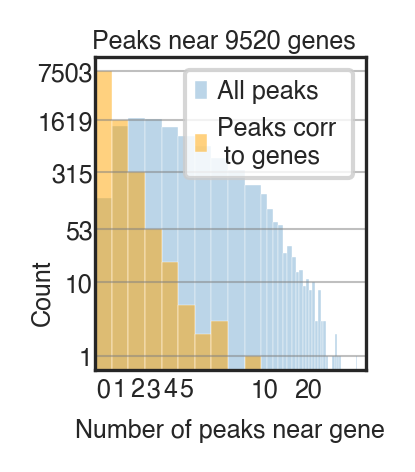

In [99]:
plot_genes = adata.var.index
plot_genes = [gene for gene in plot_genes if gene in PCR_summary.index]

sns.set_style('white')
figsize=(35*mm, 40*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()


gwp_count = (PCR_summary.num_sigpeaks > 0).sum().astype(int)
p_count = (PCR_summary.num_sigpeaks).sum().astype(int)

bins=np.arange(0,75,1)
sns.histplot(PCR_summary.loc[plot_genes,'num_peaks'], bins=bins, ax=ax, alpha=0.3, label='All peaks')
sns.histplot(PCR_summary.loc[plot_genes,'num_sigpeaks'], bins=bins, ax=ax, color='orange', 
             label='Peaks corr \n to genes', alpha=0.5) #, \
  #           label='Peaks correlated to gene \n ({} peaks corr. to {} genes total.)'.format(p_count, gwp_count))
#sns.histplot(PCR_summary.loc[plot_genes,'num_eig'], bins=bins, ax=ax, color='darkgreen', label='Eigenpeaks correlated to gene')
ax.legend()
plt.yscale('log')
plt.xscale('symlog',linthresh=10.0)
xt = [0,1,2,3,4,5,10,20]
ax.set_xticks([x + 0.5 for x in xt])
ax.set_xticklabels([0,1,2,3,4,5,10,20], y=0.07)

y0 = (PCR_summary.num_sigpeaks == 0).sum()
y1 = (PCR_summary.num_sigpeaks == 1).sum()
y2 = (PCR_summary.num_sigpeaks == 2).sum()
y3 = (PCR_summary.num_sigpeaks == 3).sum()

ax.set_yticks([1,10,y0,y1,y2,y3])
ax.set_yticklabels(['1','10',y0,y1,y2,y3], x=0.03)

for y in [1,10,y0,y1,y2,y3]:
    ax.axhline(y,linewidth=0.5, color='gray', alpha=0.5)
    
ax.set_xlim(0,50)
ax.set_xlabel('Number of peaks near gene')
ax.set_ylabel('Count', labelpad=-4, y=0.25)
ax.tick_params(axis='y', pad=-1)
plt.suptitle('Peaks near {} genes'.format(len(PCR_summary.loc[plot_genes])),x=0.55)

set_size(fig, figsize)
plt.savefig("Panels/PCR_Peaks.pdf", bbox_inches='tight')
plt.show()

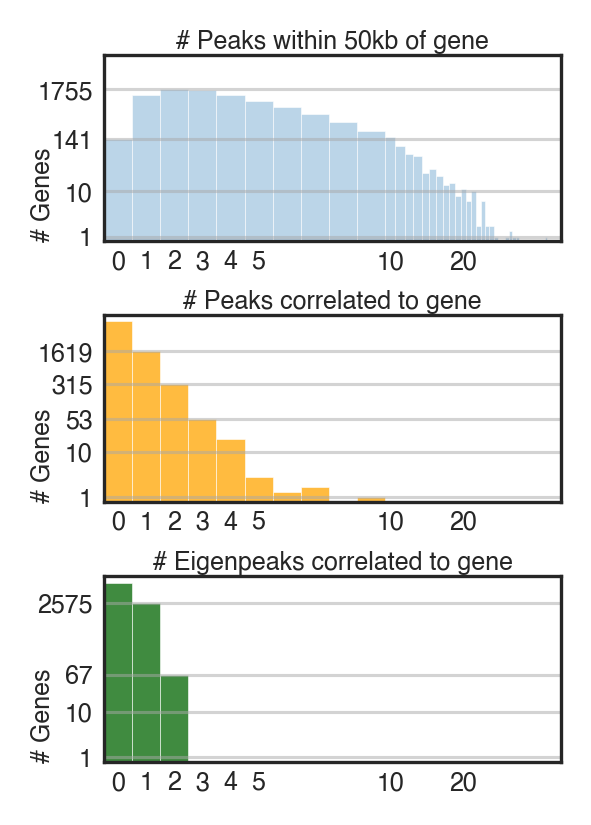

In [150]:
plot_genes = adata.var.index
plot_genes = [gene for gene in plot_genes if gene in PCR_summary.index]

sns.set_style('white')
figsize=(50*mm, 70*mm)
fig, ax = plt.subplots(3,1,figsize=figsize, dpi=300, sharey=False, sharex=False,
                      gridspec_kw={'hspace':0.4})
setfontsize()


gwp_count = (PCR_summary.num_sigpeaks > 0).sum().astype(int)
p_count = (PCR_summary.num_sigpeaks).sum().astype(int)

bins=np.arange(0,75,1)

sns.histplot(PCR_summary.loc[plot_genes,'num_peaks'], bins=bins, alpha=0.3, label='All peaks', ax=ax[0])

sns.histplot(PCR_summary.loc[plot_genes,'num_sigpeaks'], bins=bins, color='orange', 
             label='Peaks corr \n to genes', ax=ax[1]) 
  #           label='Peaks correlated to gene \n ({} peaks corr. to {} genes total.)'.format(p_count, gwp_count))
sns.histplot(PCR_summary.loc[plot_genes,'num_eig'], bins=bins, color='darkgreen', 
             label='Eigenpeaks corr to genes', ax=ax[2])

#ax.legend()
plt.yscale('log')


xt = [0,1,2,3,4,5,10,20]

yt = {}
yt[0] = [1,10] + [(PCR_summary.num_peaks == j).sum() for j in [0,2]]
yt[1] = [1,10] + [(PCR_summary.num_sigpeaks == j).sum() for j in [1,2,3]]
yt[2] = [1,10] + [(PCR_summary.num_eig == j).sum() for j in [1,2]]


#ax[0].set_yticks([1,10,y0,y1,y2,y3])
#ax[0].set_yticklabels(['1','10',y0,y1,y2,y3], x=0.03)

#for y in [1,10,y0,y1,y2,y3]:
#    ax[0].axhline(y,linewidth=0.5, color='gray', alpha=0.5)
    
ax[0].set_title('# Peaks within 50kb of gene', y=0.9)
ax[1].set_title('# Peaks correlated to gene', y=0.9)
ax[2].set_title('# Eigenpeaks correlated to gene', y=0.9)

for j in range(3):
    ax[j].tick_params(axis='y', pad=-0.75)
    ax[j].tick_params(axis='x', pad=0)
    ax[j].set_ylabel('# Genes', labelpad=-4, y=0.25)

    ax[j].set_xlim(0,50)
    ax[j].set_ylim(0.1,10000)
    ax[j].set_xscale('symlog',linthresh=10.0)
    ax[j].set_yscale('symlog', linthresh=10.0)
    ax[j].set_xticks([x + 0.5 for x in xt])
    ax[j].set_xticklabels([0,1,2,3,4,5,10,20], y=0.03)
    ax[j].set_xlabel('')
    for y in yt[j]:
        ax[j].axhline(y,linewidth=0.75, alpha=0.5, color='darkgray')
    ax[j].set_yticks(yt[j])
    ax[j].set_yticklabels([str(y) for y in yt[j]])

# ax[2].set_xlabel('# Peaks')
#plt.suptitle('Peaks near {} genes'.format(len(PCR_summary.loc[plot_genes])),x=0.55)

set_size(fig, figsize)
plt.savefig("Panels/PCR_Analysis_Peaks.pdf", bbox_inches='tight')
plt.show()

In [131]:
PCR_summary.head()

promoter_R_sq num_eig  num_peaks  num_sigpeaks  eigen0_R_sq  \
MTND2P28                  0       0        0.0           0.0          NaN   
hsa-mir-6723              0       0        0.0           0.0          NaN   
MTATP6P1                  0       0        0.0           0.0          NaN   
RP11-206L10.9      0.011958       0        1.0           0.0          NaN   
LINC01128           0.15224       0        2.0           0.0      0.15224   

               eigen1_R_sq  eigen2_R_sq  eigen3_R_sq  eigen4_R_sq  \
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
MTATP6P1               NaN          NaN          NaN          NaN   
RP11-206L10.9          NaN          NaN          NaN          NaN   
LINC01128              NaN          NaN          NaN          NaN   

               eigen5_R_sq  eigen6_R_sq  eigen7_R_sq  eigen8_R_sq  \
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
MTATP6P1               NaN          NaN          NaN          NaN   
RP11-206L10.9          NaN          NaN          NaN          NaN   
LINC01128              NaN          NaN          NaN          NaN   

               eigen9_R_sq  eigen10_R_sq  eigen11_R_sq  eigen12_R_sq  \
MTND2P28               NaN           NaN           NaN           NaN   
hsa-mir-6723           NaN           NaN           NaN           NaN   
MTATP6P1               NaN           NaN           NaN           NaN   
RP11-206L10.9          NaN           NaN           NaN           NaN   
LINC01128              NaN           NaN           NaN           NaN   

               eigen13_R_sq  eigen14_R_sq  
MTND2P28                NaN           NaN  
hsa-mir-6723            NaN           NaN  
MTATP6P1                NaN           NaN  
RP11-206L10.9           NaN           NaN  
LINC01128               NaN           NaN

In [100]:
PCR_summary.to_csv('PCR_summary.csv')

# Multiomics plots

In [101]:
pg_clones = list(peak_clonal.index)

In [102]:
prot_clonal = prot_data.to_df().groupby(prot_data.obs.Clone_ID).mean()
prot_clonal = prot_clonal.loc[pg_clones]
prot_clonal

var_names    CD57 FITC  A2 YF DEXTRA APC        CD8 A7  CD62L BV670  \
Clone_ID                                                              
P1_A03      902.903320      27506.250000   8444.175781  -208.290939   
P1_A05      803.705139      19328.957031   7142.438965   -32.177135   
P1_A08      576.234619      19552.335938   7188.782227   -37.302555   
P1_A12      413.486084      15468.637695   4991.385742   -77.271622   
P1_B10       42.948910      14563.261719   8508.237305   -55.116821   
P1_C11     1643.779175      23151.318359  10985.375000   -18.524429   
P1_D09     1441.065430      17640.460938   6325.950684   567.863037   
P1_F10      203.625443      16097.100586   7561.971680   -58.249008   
P1_H01     1690.622925      14977.458984   6277.771973     4.625610   
P1_H10     1068.334717      26251.025391   8835.803711    71.106735   
P2_A04     1749.253052      22271.263672   7926.547363  -162.400391   
P2_B11      905.793823      22156.519531   8163.387695  -191.425201   
P2_G01     2321.262451      29470.908203   9826.098633  -157.706314   
P2_G09      638.899292      22724.232422   8776.172852   -93.520004   
P2_H04      247.371338      35838.644531   9158.025391  -105.397858   
P2_H05     3864.262207      17620.658203   9249.083984    34.258526   

var_names    PD1 BV711  CD27 BV786      CD94 PE      CD3 PC5  
Clone_ID                                                      
P1_A03     1376.424927  -97.778107  2359.556641  2292.757568  
P1_A05      903.623413  -68.900253   393.199371  2615.705322  
P1_A08     1303.275879  -41.017300  7642.252441  2269.702393  
P1_A12      994.417175  -49.785648   279.779022  1625.113037  
P1_B10     2128.482666   22.142307  1226.074707  2014.063965  
P1_C11     1235.683594  -62.457111  2831.641602  2888.821533  
P1_D09     2455.682129  -83.398872    60.759659  2319.213623  
P1_F10     1241.386597  -57.741810  1476.108765  1676.395996  
P1_H01     1099.460083  -65.979813  1879.674072  1961.431641  
P1_H10      555.246704  -97.844833   154.407333  2497.243896  
P2_A04      741.104126  -83.873314    62.666954  2209.680908  
P2_B11      828.401001 -106.923340  2057.955078  2286.909668  
P2_G01     1150.331055  -97.822929   288.096466  2334.123291  
P2_G09     1495.582153 -101.572876  7028.983398  2695.924805  
P2_H04      810.228943   25.330467   145.109039  2907.352783  
P2_H05      702.913269  -84.052254    63.130737  1906.631836

In [103]:
gene_clonal

gene_name  MTND2P28  hsa-mir-6723  MTATP6P1  RP11-206L10.9  LINC01128  \
Clone_ID                                                                
P1_A03     3.230169      2.079046  5.749669       0.000000   0.000000   
P1_A05     2.709148      1.453811  5.383322       0.000000   0.000000   
P1_A08     3.050509      1.614846  5.801980       0.000000   0.000000   
P1_A12     3.035853      1.859284  5.475892       0.887302   0.958630   
P1_B10     3.112417      2.253648  5.691962       0.000000   0.902409   
P1_C11     2.745569      1.978039  5.837260       0.000000   0.000000   
P1_D09     2.575861      1.505550  5.739470       0.948192   1.076902   
P1_F10     2.922449      1.693547  5.865429       0.000000   0.000000   
P1_H01     3.106876      1.949256  5.824675       0.000000   0.000000   
P1_H10     2.250069      1.485239  5.613591       0.000000   0.000000   
P2_A04     3.237091      1.334472  5.566094       0.957045   0.000000   
P2_B11     3.307103      2.163680  5.705452       1.188340   0.000000   
P2_G01     3.005000      0.545083  4.770329       0.000000   0.000000   
P2_G09     2.708898      1.455621  5.396387       0.000000   1.132141   
P2_H04     2.315471      1.711872  5.294865       0.351379   0.000000   
P2_H05     2.047147      0.479275  4.363872       0.000000   0.000000   

gene_name     NOC2L     ISG15  RP11-465B22.3  TNFRSF18   TNFRSF4  ...  \
Clone_ID                                                          ...   
P1_A03     2.308283  7.334683       0.000000  3.254865  1.157134  ...   
P1_A05     2.970573  6.024615       0.000000  4.569802  1.087413  ...   
P1_A08     0.000000  7.358630       0.000000  5.370294  1.082879  ...   
P1_A12     2.351700  6.635680       0.000000  5.170679  0.412726  ...   
P1_B10     2.168520  6.953883       1.071905  5.509768  0.000000  ...   
P1_C11     2.254454  4.855477       0.000000  3.198215  0.000000  ...   
P1_D09     1.631425  5.360824       3.277528  4.126095  2.221344  ...   
P1_F10     2.471754  6.654633       1.307794  3.869681  1.221896  ...   
P1_H01     2.190555  6.236783       0.000000  3.081303  0.337937  ...   
P1_H10     3.127002  5.592022       0.000000  4.690275  0.942922  ...   
P2_A04     1.419956  5.599187       0.000000  3.480796  0.000000  ...   
P2_B11     2.022410  5.456667       0.000000  1.635330  1.342189  ...   
P2_G01     1.528105  8.190660       0.000000  0.885717  0.000000  ...   
P2_G09     0.000000  6.837132       0.000000  4.499185  0.000000  ...   
P2_H04     0.000000  5.778849       0.000000  3.573749  0.000000  ...   
P2_H05     0.000000  5.500018       0.000000  0.172438  0.147221  ...   

gene_name      F8-1  FUNDC2-1   BRCC3-1    VBP1-1  RAB39B-1   TMLHE-1  \
Clone_ID                                                                
P1_A03     0.000000  2.843147  2.523289  3.442465  0.000000  0.000000   
P1_A05     0.000000  3.934277  3.737265  4.640422  0.000000  1.077093   
P1_A08     1.002046  4.011677  2.558638  4.284044  0.000000  2.961611   
P1_A12     0.224331  4.294168  2.767888  4.635580  0.864102  3.820885   
P1_B10     0.000000  2.429938  0.000000  2.663473  0.772005  3.728553   
P1_C11     0.000000  2.998382  1.462838  3.882571  0.891281  1.206362   
P1_D09     0.548206  3.907003  3.097841  4.354332  0.685584  1.847692   
P1_F10     1.232553  1.618218  3.844646  4.177619  0.901349  0.000000   
P1_H01     0.000000  2.998327  2.415796  4.209680  0.000000  1.493295   
P1_H10     0.000000  2.596592  1.918516  4.173988  0.000000  0.761494   
P2_A04     0.000000  3.139159  0.000000  2.827251  0.000000  2.954389   
P2_B11     0.000000  3.682788  2.343420  4.453341  0.000000  4.217452   
P2_G01     0.000000  1.196341  1.552464  0.000000  0.000000  1.926167   
P2_G09     0.000000  3.030712  1.711892  4.846723  2.136081  0.000000   
P2_H04     0.000000  2.841082  0.465016  2.514537  1.168372  0.000000   
P2_H05     0.000000  4.360162  0.000000  0.000000  1.405290  0.000000   

gene_name     VAMP7     SRIP3  AC010970.2  RNA5-8SP6  


In [104]:
peak_clonal

PeakID    Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
Clone_ID                                                                   
P1_A03          2.397638        2.529633        2.150198        5.617923   
P1_A05          2.717578        1.972389        2.088377        5.437860   
P1_A08          2.928915        2.287843        1.691356        5.560565   
P1_A12          2.225148        2.426444        2.426444        5.683740   
P1_B10          2.987230        1.853198        2.670728        5.436592   
P1_C11          2.751107        2.591159        1.970270        5.644123   
P1_D09          2.464640        3.449496        2.299183        5.493403   
P1_F10          2.149178        2.824024        2.065458        5.619921   
P1_H01          2.556990        1.892109        2.524847        5.518234   
P1_H10          2.260768        2.869512        2.697917        5.432869   
P2_A04          2.370404        2.967492        2.469283        5.697934   
P2_B11          2.246812        0.000000        2.714423        5.558466   
P2_G01          1.948509        2.775430        2.623850        5.629741   
P2_G09          2.707259        2.128885        1.243721        5.444118   
P2_H04          2.718706        1.969373        2.339709        5.705107   
P2_H05          2.027774        2.000840        1.945744        5.533689   

PeakID    Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
Clone_ID                                                                  
P1_A03          1.967855        3.278499        3.233557       4.882648   
P1_A05          0.633384        3.517708        2.451669       5.108484   
P1_A08          2.287843        3.709698        3.762476       5.194549   
P1_A12          1.119627        3.585825        3.326052       5.100070   
P1_B10          2.205004        3.504991        3.114438       5.243369   
P1_C11          1.856460        3.638525        3.083403       5.247215   
P1_D09          3.114337        3.700081        3.607240       5.154146   
P1_F10          1.974084        3.443976        3.507894       5.158548   
P1_H01          1.727383        3.856328        3.475958       5.182631   
P1_H10          2.418915        3.799819        1.578473       5.147631   
P2_A04          2.166221        3.824545        0.732249       5.182442   
P2_B11          2.246812        4.033247        3.964330       5.195662   
P2_G01          1.707229        3.436920        2.986031       5.123996   
P2_G09          1.243721        3.869145        2.991982       5.031900   
P2_H04          2.115431        3.431467        1.571595       5.082010   
P2_H05          1.454262        3.602494        0.553023       5.061416   

PeakID    Interval_6501  Interval_68580  ...  Interval_69022  Interval_56910  \
Clone_ID                                 ...                                   
P1_A03         4.752263        5.469793  ...        4.176711        5.725381   
P1_A05         4.493093        5.533124  ...        4.421364        5.751973   
P1_A08         4.519068        5.543390  ...        3.949484        5.814805   
P1_A12         4.740612        5.524294  ...        4.205272        5.802704   
P1_B10         4.985421        5.780162  ...        4.261869        5.647071   
P1_C11         4.287120        5.610814  ...        4.035187        5.825854   
P1_D09         4.445949        5.408775  ...        4.487143        5.763301   
P1_F10         4.699069        5.427788  ...        4.216893        5.746419   
P1_H01         4.508285        5.476674  ...        4.231659        5.612613   
P1_H10         4.061644        5.429313  ...        4.128048        5.493102   
P2_A04         4.576645        5.627039  ...        4.219496        5.726516   
P2_B11         4.471122        5.540189  ...        4.345335        5.734086   
P2_G01         4.585413        5.571364  ...        4.251483        5.548196   
P2_G09         4.856232        5.418911  ...        4.402289        5.577108   


In [351]:
from matplotlib.ticker import FormatStrFormatter

def pgplot(gene, protein = None, eigen = False, order='eig', cutoff=0.2, window=50000, file_annot = '',
          hide_legend=False, side_legend=False, cust_size = None, plain=False):
    sns.set_style('white')
    setfontsize()
    if protein or eigen:
        num_rows = 3
        hr = [2,1,1]
    else:
        num_rows = 2
        hr=[2,1]

    
    # Peaks and eigenpeaks
    PCR_df = PCR_analysis(gene, window=window)
    peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
    peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > cutoff]
    
    if plain:
        figsize=(35*mm,12*mm*num_rows + 5*mm )
    else:
        figsize=(35*mm,12*mm*num_rows + 10*mm + (2.5 * (len(peaklist)//3) * mm))
    if cust_size:
        figsize = cust_size
        
    fig, ax = plt.subplots(num_rows,1,figsize=figsize, dpi=300, sharex=True,
                           gridspec_kw = {'hspace':0.05, 'height_ratios':hr}) 
    
               
    clone_order = list(gene_clonal[gene].sort_values().index)
    
    
    pplot_df = peak_clonal[peaklist].copy()
    
    eig_cols = [col for col in PCR_df.columns if col[:3] == 'Eig']
    eig_weights = PCR_df.loc[peaklist, eig_cols]
    realpeaks = pplot_df
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    eig_df = normpeaks.dot(eig_weights)
    eigR2 = PCR_df.loc[gene+'_Rsq',eig_cols].astype(float)
    eig_df = eig_df * (2 * (eig_df.loc[clone_order[-1]] > 0) - 1) #Flip eigenpeaks to match gene.
    ty = np.min(eig_df.values)
    
    top_eig = eigR2.idxmax()
    
    
    # Normalize peak heights between 0 and 1.
    pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
    pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()    
    
    if order=='eig':
        clone_order = list(eig_df[top_eig].sort_values().index)
        
    pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)    
    eig_df['Clone'] = pd.Categorical(eig_df.index, categories = clone_order, ordered = True)
    
     
    gplot_df = pd.DataFrame(columns=[gene,'Clone'])
    gplot_df[gene] = adata.to_df()[gene]
    gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
    gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
        
    for clone in clone_order:
        for row in range(num_rows):
            ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
    # GENE EXPRESSION PLOT
    
    sns.scatterplot(x='Clone', y=gene, color='darkgray', edgecolor='k', s=10, data=gplot_df, ax=ax[0], legend=False)
    gene_ticks = [int(gplot_df[gene].min()), int(gplot_df[gene].max())]
    if gene_ticks[1] == gene_ticks[0]:
        gene_ticks[1] = gene_ticks[0]+1
    ax[0].set_yticks(gene_ticks)
    ax[0].set_yticklabels(gene_ticks, x=0.03)
    #ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[0].set_ylabel(gene)
    ax[0].yaxis.set_label_position("right")
    ax[0].tick_params(axis='y', pad=-0.6)
    
    # ATAC PLOT
    
    no_peaks = 0
    for peak in peaklist:
        peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
        if peak_Rsq > 0.05:
            peak_label = '${:1.2f}$'.format(peak_Rsq)
            no_peaks += 1
        else:
            peak_label = None
        sns.lineplot(x='Clone', y=peak, data=pplot_df, ax=ax[-1], linewidth=0.7,
                    label=peak_label, alpha=min(1,peak_Rsq*1.5), zorder=np.round(peak_Rsq*100).astype(int)) #, label=peak, legend=False)
    
    ax[-1].set_ylabel('Peak')
    ax[-1].yaxis.set_label_position("right")
    ax[-1].set_yticks([])
    ax[-1].set_xlabel('')
    
    # PROTEIN PLOT
    if protein:
        proplot_df = pd.DataFrame(prot_clonal[protein], columns=[protein])
        proplot_df[protein] = proplot_df[protein] - proplot_df[protein].min()
        proplot_df[protein] = proplot_df[protein] / proplot_df[protein].max()
        proplot_df['Clone'] = proplot_df.index
        sns.lineplot(x='Clone', y=protein, data=proplot_df, ax=ax[1], linewidth=0.7)
        ax[1].text(1,0.5,protein, ha='left')
        ax[1].set_ylabel('Prot')
        ax[1].yaxis.set_label_position("right")
        ax[1].set_yticks([])
        ax[1].set_xlabel('')
        ax[1].spines['top'].set_color('lightgray')
        ax[1].spines['bottom'].set_color('lightgray')
    
    # Eigenpeak plot
    if eigen:
        no_peaks = 0
        for peak in eig_cols:
            peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
            if peak_Rsq > 0.05:
                peak_label = '${:1.2f}$'.format(peak_Rsq)
                no_peaks += 1
            else:
                peak_label = None
            sns.lineplot(x='Clone', y=peak, data=eig_df, ax=ax[1], linewidth=0.7,
                        alpha=min(1,peak_Rsq*1.5), 
                         color='k') #, zorder=np.round(peak_Rsq*100).astype(int))
        
        ax[1].text(9,ty,'Eigenpeaks', ha='center', va='bottom')
        ax[1].set_ylabel('')
        #ax[1].yaxis.set_label_position("right")
        ax[1].set_yticks([])
        ax[1].set_xlabel('')
        ax[1].spines['top'].set_color('lightgray')
        ax[1].spines['bottom'].set_color('lightgray')
        ax[1].axhline(0, c='red', alpha=0.25, linewidth=0.5)
    
    # General formatting.
    ax[0].spines['bottom'].set_color('lightgray')
    ax[-1].spines['top'].set_color('lightgray')
    
    plt.xticks(rotation=45)
    plt.xticks([])
    
    if len(peaklist) == 1:
        peakword = 'peak'
    else:
        peakword = 'peaks'
    if protein:
        title = '{}, {}, and {} {}'.format(gene, protein, len(peaklist), peakword)
    else:
        title = '{} and {} {}'.format(gene, len(peaklist), peakword)
    
    if plain:
        plt.suptitle('')
    else:
        plt.suptitle(title, y=1.02, x=0.6)
    
    # Plot legend
    if no_peaks <= 3:
        ncol = no_peaks
    else:
        ncol = 3
    if side_legend:
        lgnd = plt.legend(bbox_to_anchor=(2.0,3.0), title = 'Peak/Gene $R^2$',  
                          ncol=2, frameon=False)
        #lgnd.get_frame().set_linewidth(0.0)
        plt.suptitle('')
        
    else:
        lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
                          loc=9, ncol=ncol, framealpha=0.5)
        lgnd.get_frame().set_linewidth(0.5)
    if hide_legend:
        lgnd.set_visible(False)
        plt.suptitle('')
        ax[0].set_yticks([])
     
        
    if plain:
        lgnd.set_visible(False)
        plt.suptitle('')
    
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[-1].set_ylabel('')
    
    # Save and show figure.
    set_size(fig, figsize)
    file_prefix = 'Panels/Multiplots/'
    file_name = '{}_peaks_gene'.format(gene)
    if eigen:
        file_name += '_eigens'
    if protein:
        file_name += '_prots'
    if plain:
        file_name += '_plain'
    file_name += file_annot
    file_suffix = '.pdf'
    plt.savefig(file_prefix + file_name + file_suffix, bbox_inches='tight')
    plt.show()

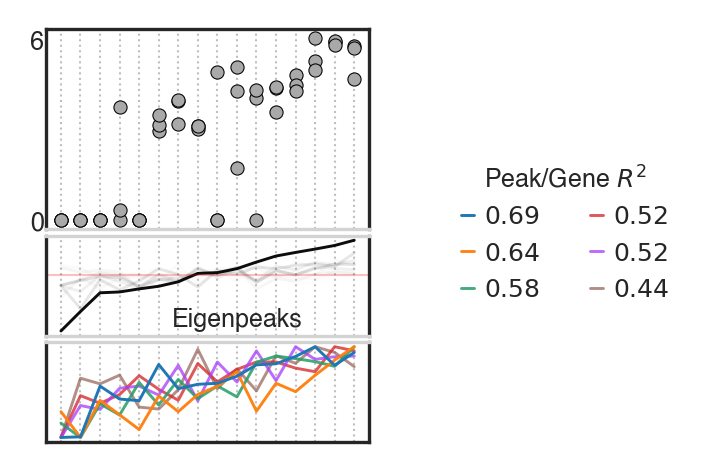

In [353]:
pgplot('KLRD1', eigen=True, cutoff=R2_sigs['KLRD1'], side_legend=True, cust_size=(60*mm, 40*mm))

In [106]:
pg_corrs['12'].loc[peaks_near('KLRD1', window=50000),'KLRD1']**2

PeakID
Interval_15283    0.048279
Interval_15297    0.688533
Interval_15289    0.518863
Interval_15290    0.189000
Interval_15299    0.517388
Interval_15294    0.091818
Interval_15296    0.639647
Interval_15292    0.175776
Interval_15291    0.259576
Interval_15285    0.444245
Interval_15298    0.187081
Interval_15295    0.576233
Interval_15284    0.274858
Name: KLRD1, dtype: float32

In [107]:
PCR_analysis('KLRD1')

PeakID         Interval_15283 Interval_15297 Interval_15289 Interval_15290  \
PeakID                                                                       
Interval_15297            0.0            1.0            0.0            0.0   
Interval_15296            0.0            0.0            0.0            0.0   
Interval_15295            0.0            0.0            0.0            0.0   
Interval_15289            0.0            0.0            1.0            0.0   
Interval_15299            0.0            0.0            0.0            0.0   
Interval_15285            0.0            0.0            0.0            0.0   
Interval_15284            0.0            0.0            0.0            0.0   
Interval_15291            0.0            0.0            0.0            0.0   
Interval_15290            0.0            0.0            0.0            1.0   
Interval_15298            0.0            0.0            0.0            0.0   
Interval_15292            0.0            0.0            0.0            0.0   
Interval_15294            0.0            0.0            0.0            0.0   
KLRD1_R              0.219724       0.829779       0.720321       0.434741   
KLRD1_Rsq            0.048279       0.688533       0.518863          0.189   
KLRD1_promoter          False           True          False          False   

PeakID         Interval_15299 Interval_15294 Interval_15296 Interval_15292  \
PeakID                                                                       
Interval_15297            0.0            0.0            0.0            0.0   
Interval_15296            0.0            0.0            1.0            0.0   
Interval_15295            0.0            0.0            0.0            0.0   
Interval_15289            0.0            0.0            0.0            0.0   
Interval_15299            1.0            0.0            0.0            0.0   
Interval_15285            0.0            0.0            0.0            0.0   
Interval_15284            0.0            0.0            0.0            0.0   
Interval_15291            0.0            0.0            0.0            0.0   
Interval_15290            0.0            0.0            0.0            0.0   
Interval_15298            0.0            0.0            0.0            0.0   
Interval_15292            0.0            0.0            0.0            1.0   
Interval_15294            0.0            1.0            0.0            0.0   
KLRD1_R              0.719297       0.303016       0.799779       0.419257   
KLRD1_Rsq            0.517388       0.091818       0.639647       0.175776   
KLRD1_promoter          False          False          False          False   

PeakID         Interval_15291 Interval_15285  ... Eigenpeak 2 Eigenpeak 3  \
PeakID                                        ...                           
Interval_15297            0.0            0.0  ...   -0.012564    0.107470   
Interval_15296            0.0            0.0  ...   -0.105767   -0.193922   
Interval_15295            0.0            0.0  ...    0.048582    0.434014   
Interval_15289            0.0            0.0  ...   -0.377862   -0.571206   
Interval_15299            0.0            0.0  ...    0.447003   -0.482522   
Interval_15285            0.0            1.0  ...    0.217647    0.155327   
Interval_15284            0.0            0.0  ...   -0.003066    0.080119   
Interval_15291            1.0            0.0  ...   -0.616560    0.242654   
Interval_15290            0.0            0.0  ...    0.462187    0.165391   
Interval_15298            0.0            0.0  ...    0.025769    0.232247   
Interval_15292            0.0            0.0  ...   -0.007941   -0.062344   
Interval_15294            0.0            0.0  ...   -0.042836    0.169605   
KLRD1_R              0.509486       0.666517  ...    0.077225   -0.123179   
KLRD1_Rsq            0.259576       0.444245  ...    0.005964    0.015173   
KLRD1_promoter          False          False  ...         NaN         NaN   

PeakID         Eigenpeak 4  Eigenpea

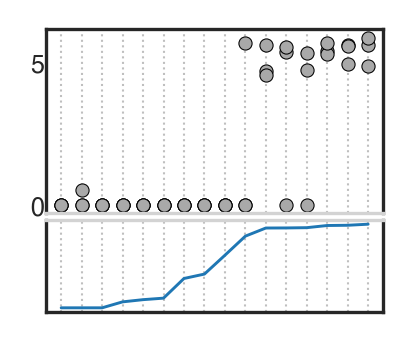

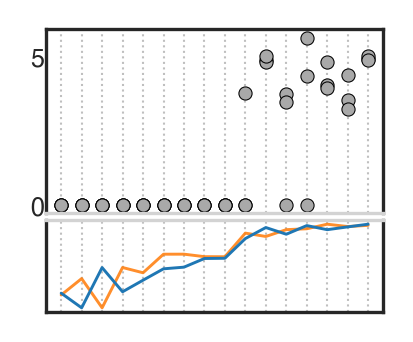

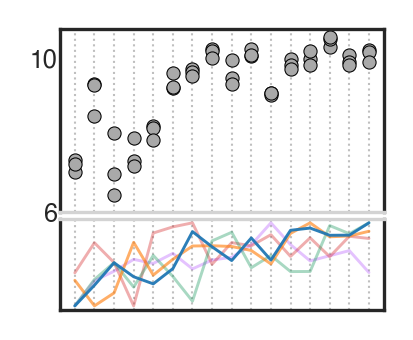

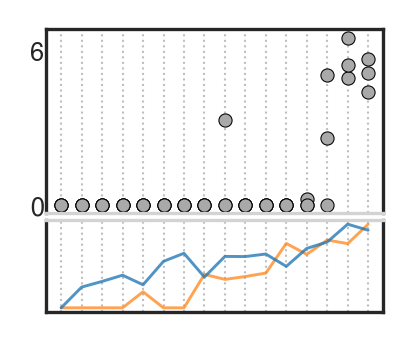

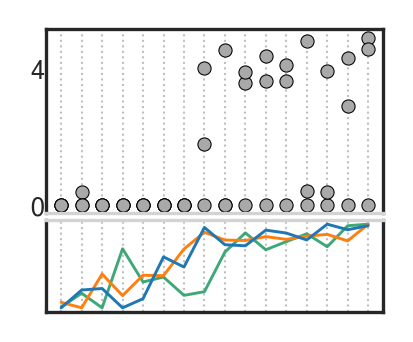

In [110]:
for gene in ['GTSF1','HPGD','GNLY', 'IL17RB', 'FAM49A']:
    pgplot(gene, plain=True)

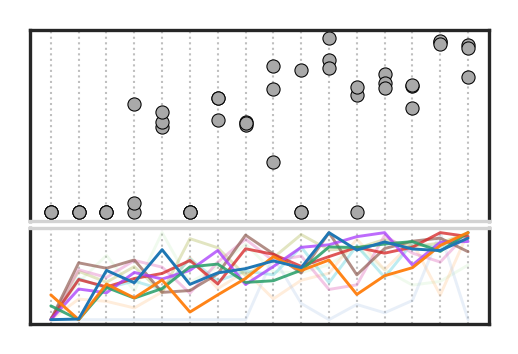

In [163]:
pgplot('KLRD1',cutoff=0.05,hide_legend=True, cust_size=(44*mm,30*mm))

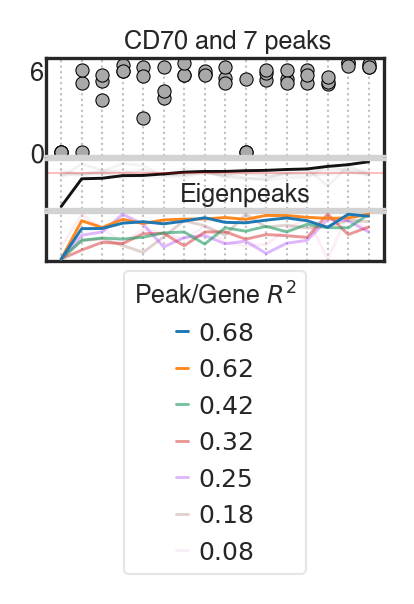

In [164]:
pgplot('CD70', eigen=True, cutoff=0.05)

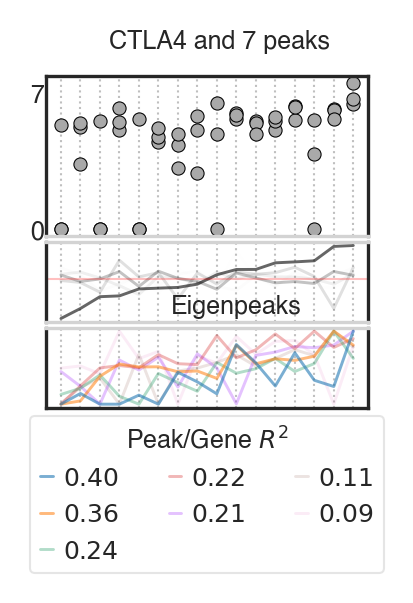

In [165]:
pgplot('CTLA4', eigen=True, cutoff=0.05)

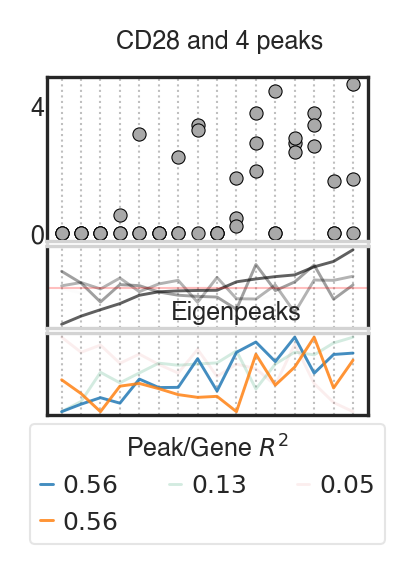

In [113]:
pgplot('CD28', eigen=True, cutoff=0.05)

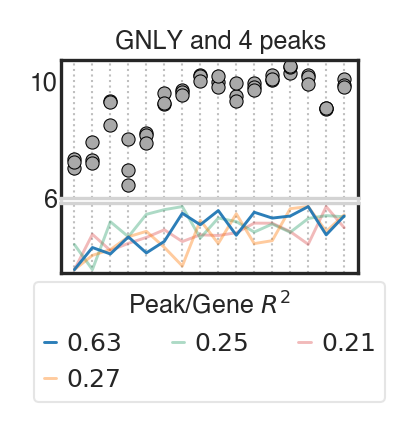

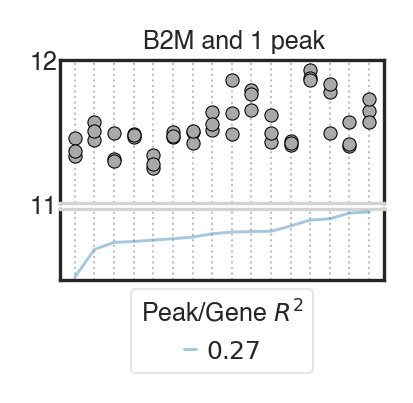

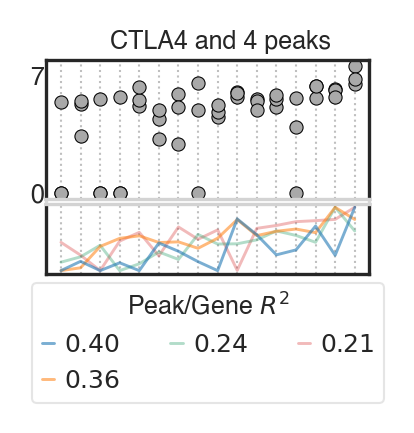

In [114]:
for gene in ['GNLY','B2M','CTLA4']:
    pgplot(gene)

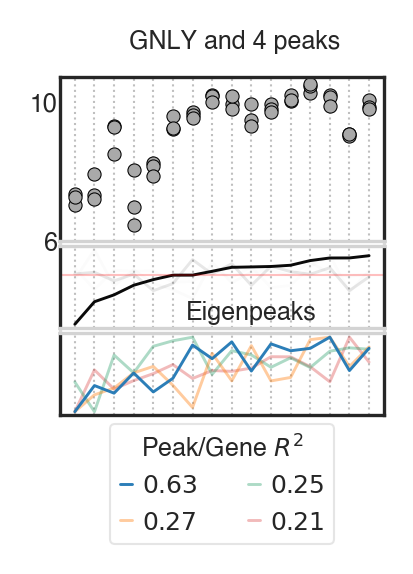

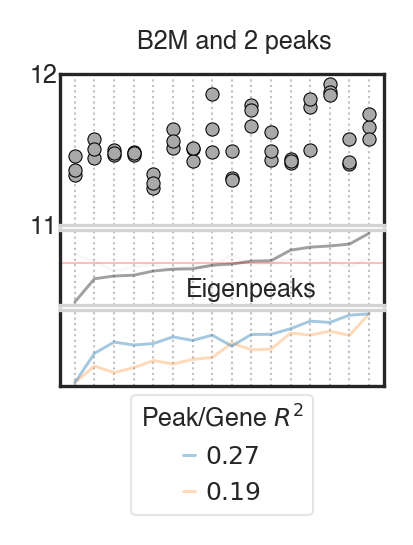

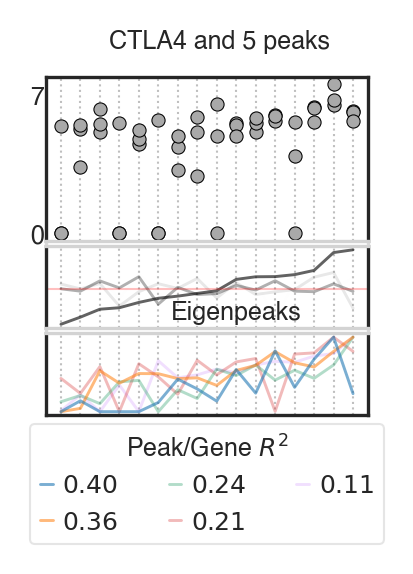

In [115]:
for gene in ['GNLY','B2M','CTLA4']:
    pgplot(gene, eigen=True, cutoff=0.05)

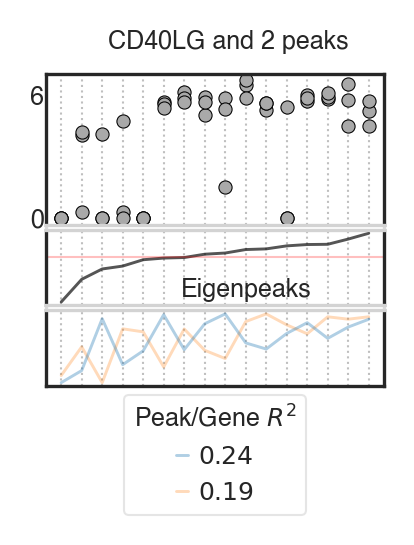

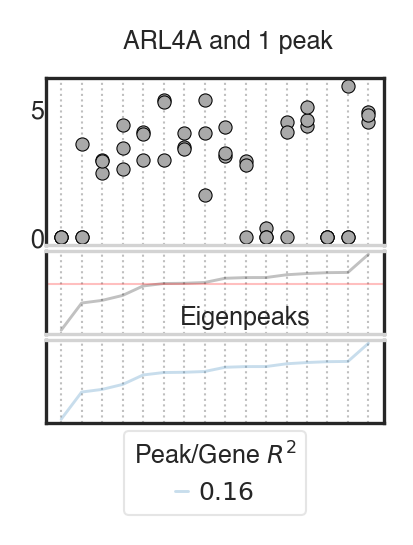

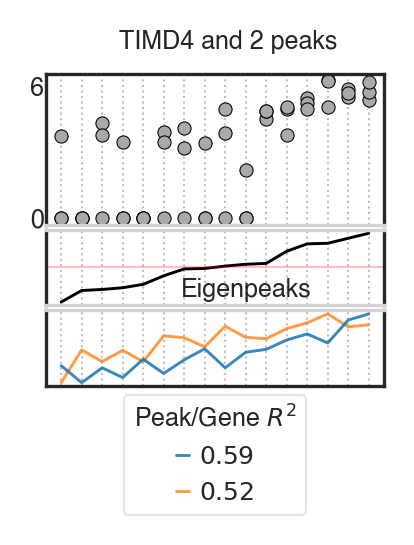

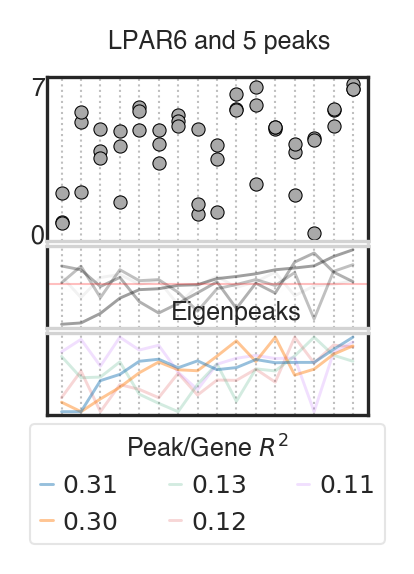

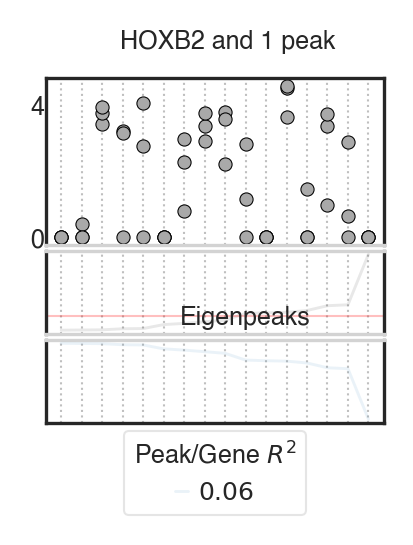

In [116]:
for gene in ['CD40LG', 'ARL4A', 'TIMD4', 'LPAR6', 'HOXB2']:
    pgplot(gene, cutoff=0.05, eigen=True)

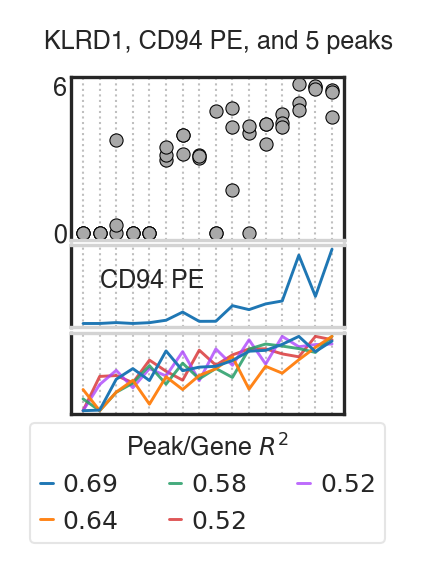

In [117]:
pgplot('KLRD1', protein='CD94 PE')

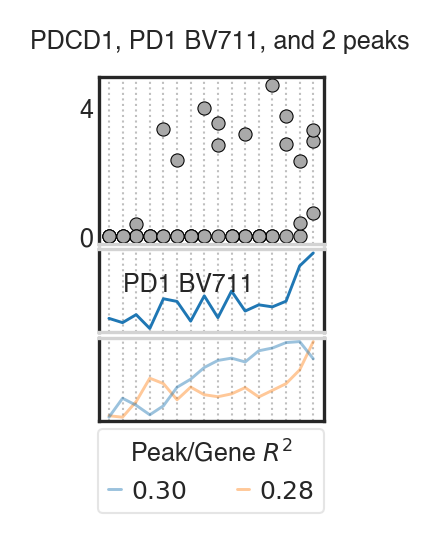

In [118]:
pgplot('PDCD1', protein='PD1 BV711')

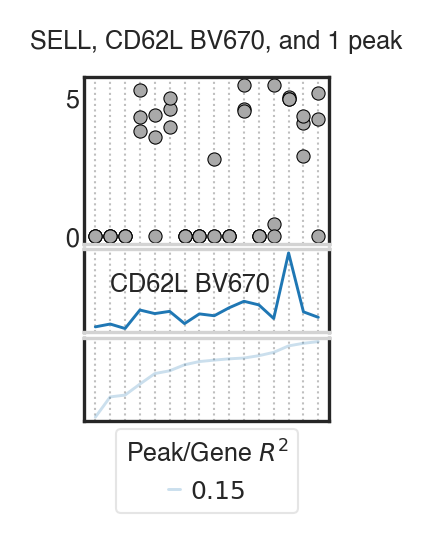

In [119]:
pgplot('SELL', protein='CD62L BV670', cutoff=0.1, window=100000)

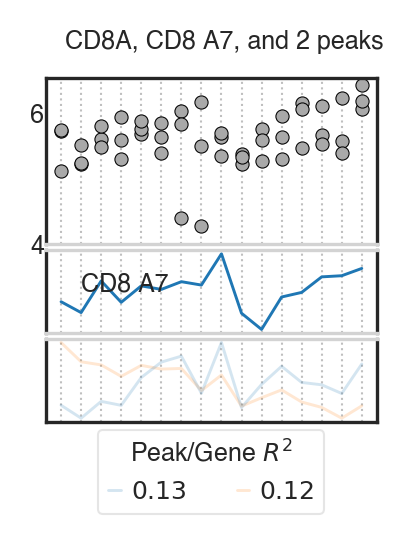

In [120]:
pgplot('CD8A', protein='CD8 A7', cutoff=0.1, window=100000)

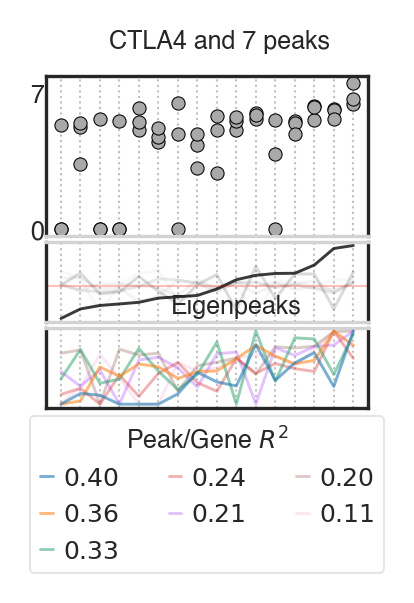

In [121]:
pgplot('CTLA4', cutoff=0.05, eigen=True, window=100000)

## Finding strong repressors

In [122]:
PCR_inter_ans = {}
for gene in PCR_ans.keys():
    PCR_a = PCR_ans[gene]
    ints = [col for col in PCR_a.columns if col[:3] == 'Int']
    PCR_inter_ans[gene] = PCR_a[ints]

We find strong repressors by looking for good peaks with negative R and R^2 > 0.5

In [123]:
repressed_genes = [gene for gene in PCR_ans.keys() if PCR_inter_ans[gene].loc[gene+'_R'].min() < -np.sqrt(0.5)]

In [124]:
len(repressed_genes)

42

Many of these genes with repressors may have high dropout, so we exclude these.

In [125]:
adata.var.loc[repressed_genes].pct_dropout_by_counts.sort_values()[:10]

gene_name
FAM103A1    12.857143
TAOK1       25.714286
PMS2P1      31.428571
CCNK        32.857143
SAE1        40.000000
RABEP1      42.857143
UBE3B       45.714286
RBM18       47.142857
MARK3       48.571429
FAM65B      52.857143
Name: pct_dropout_by_counts, dtype: float64

This should restrict our attention to genes with <50% dropout.

In [126]:
plot_genes = adata.var.loc[repressed_genes].pct_dropout_by_counts.sort_values()[:10].index
plot_genes

Index(['FAM103A1', 'TAOK1', 'PMS2P1', 'CCNK', 'SAE1', 'RABEP1', 'UBE3B',
       'RBM18', 'MARK3', 'FAM65B'],
      dtype='object', name='gene_name')

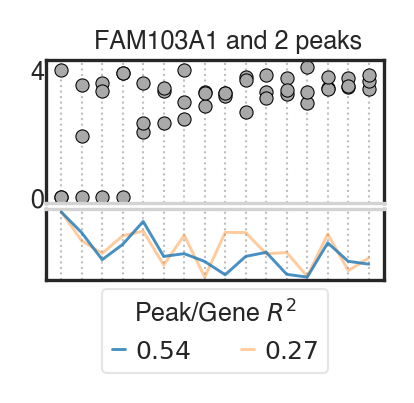

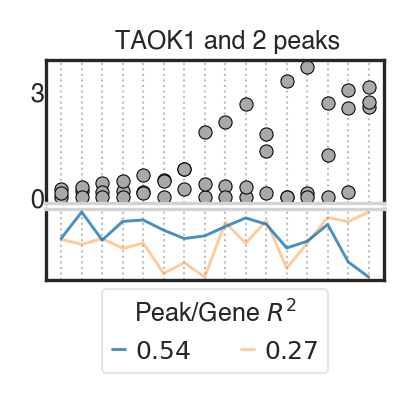

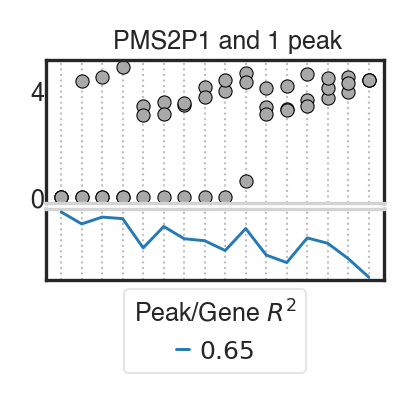

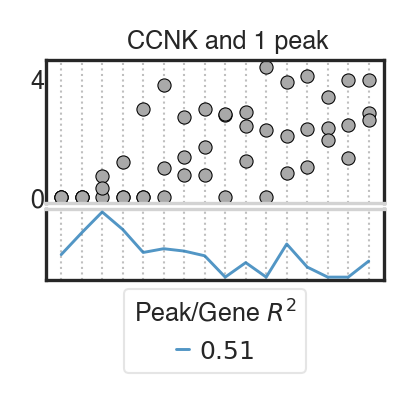

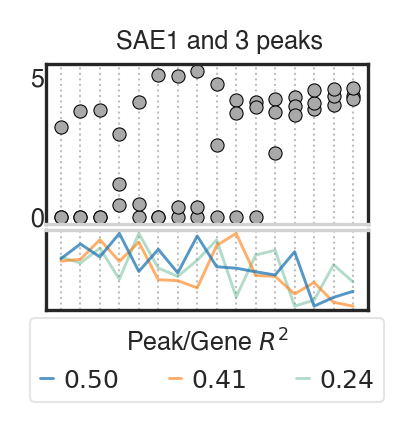

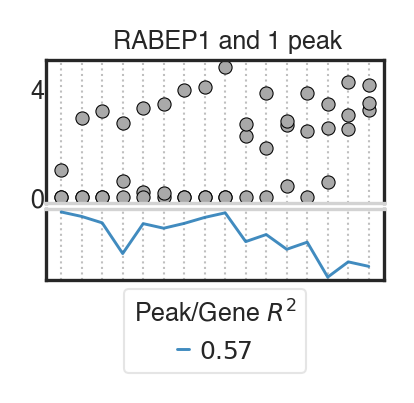

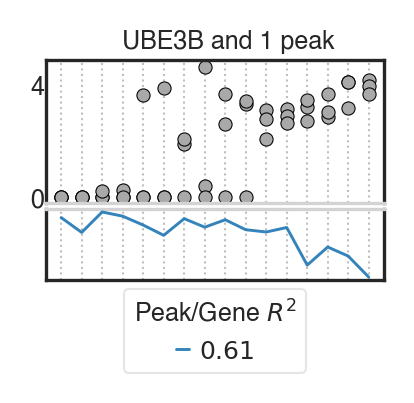

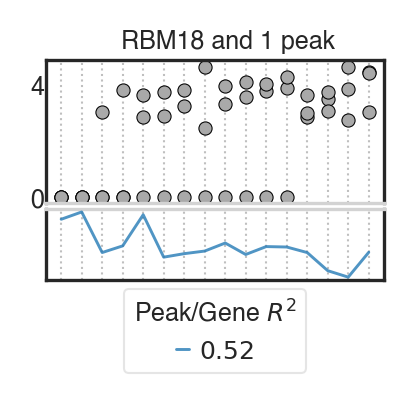

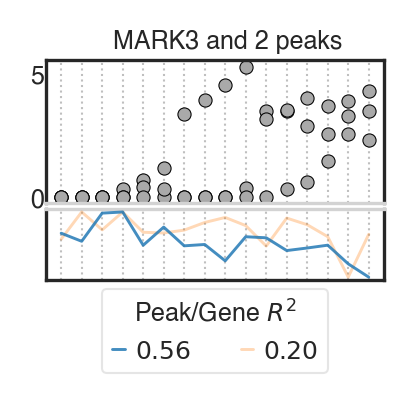

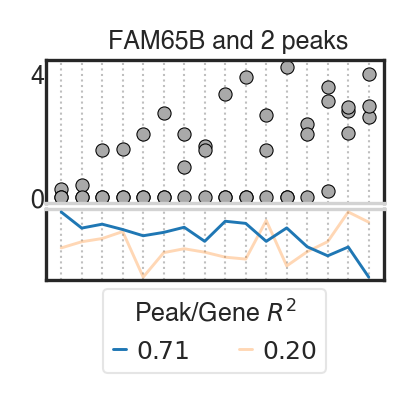

In [127]:
for gene in plot_genes:
    pgplot(gene, order='gene', file_annot='_repressor')

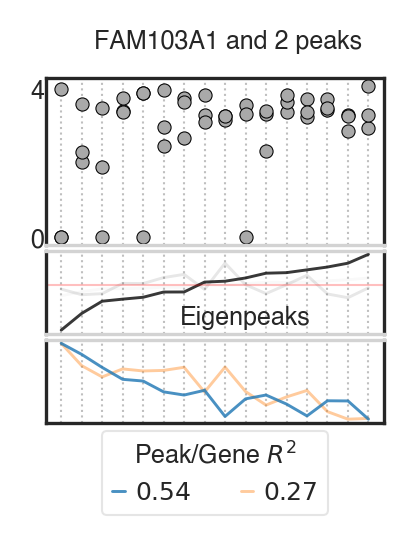

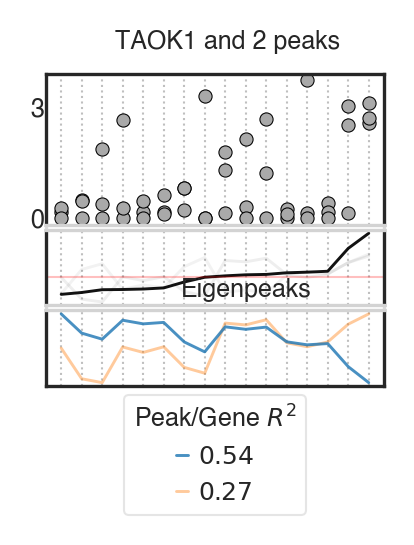

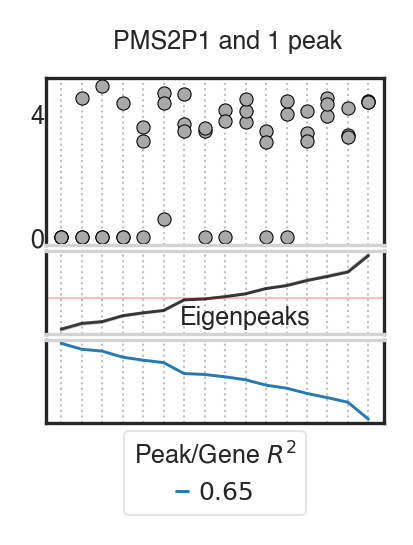

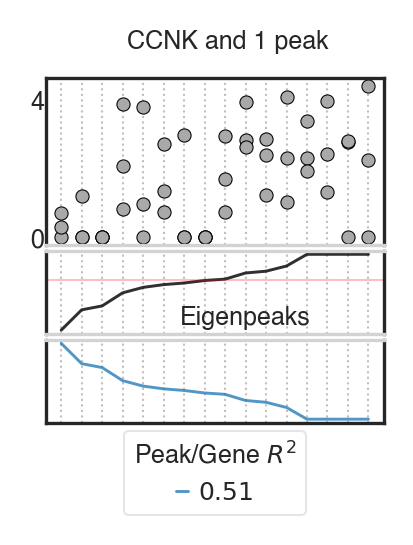

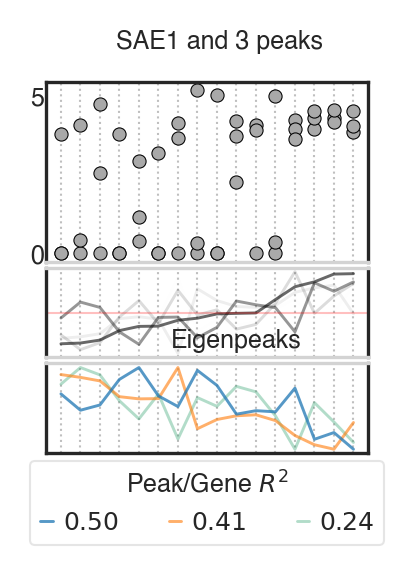

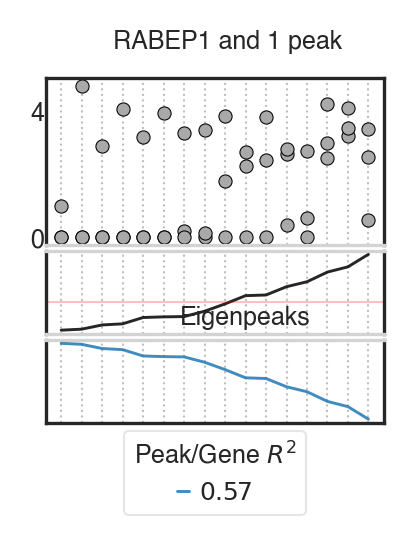

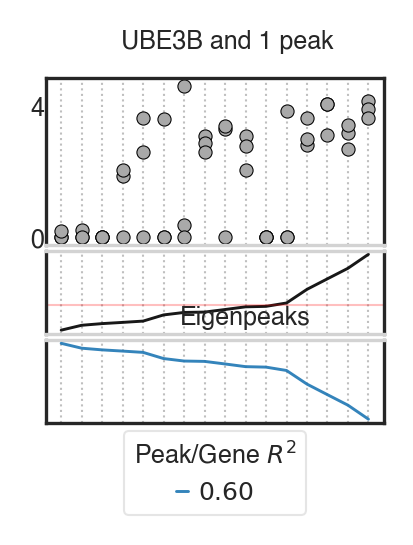

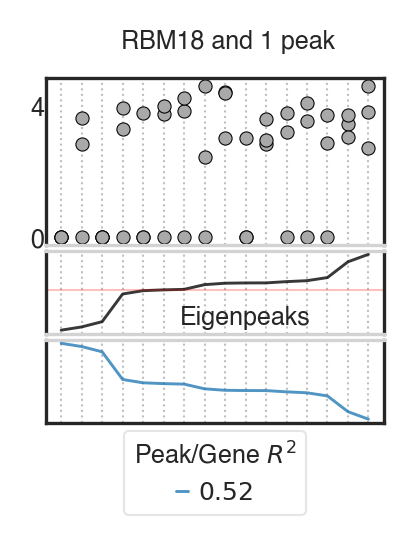

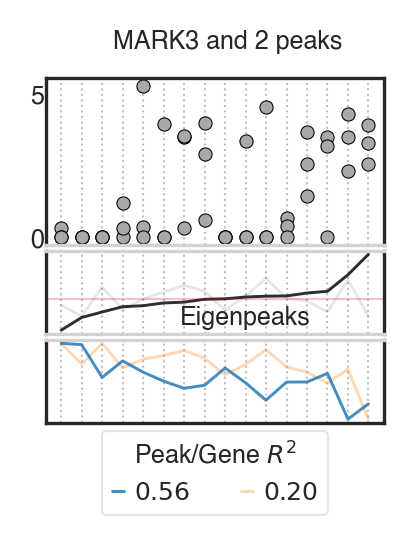

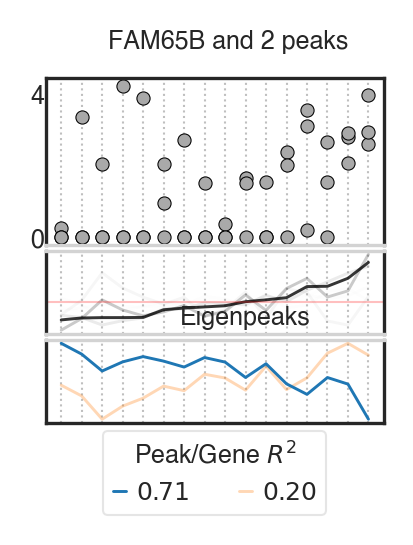

In [153]:
for gene in plot_genes:
    pgplot(gene, eigen=True, file_annot='_repressor')

# GOMP experiment

GOMPs are Genes of Many Peaks.  They are kind of like DORCs (cite!), but looking more narrowly for correlated peaks around each gene.

In [163]:
GOMP_df = pd.DataFrame(PCR_summary['num_sigpeaks'].sort_values())
GOMP_df['rank'] = range(len(GOMP_df))
GOMP_df

num_sigpeaks  rank
MTND2P28           0.0     0
GGT1               0.0     1
SNRPD3             0.0     2
GUCD1              0.0     3
CABIN1             0.0     4
...                ...   ...
HDAC9              6.0  9515
SLC4A10            7.0  9516
DOCK5              7.0  9517
APBB2              9.0  9518
PIP5K1B            9.0  9519

[9520 rows x 2 columns]

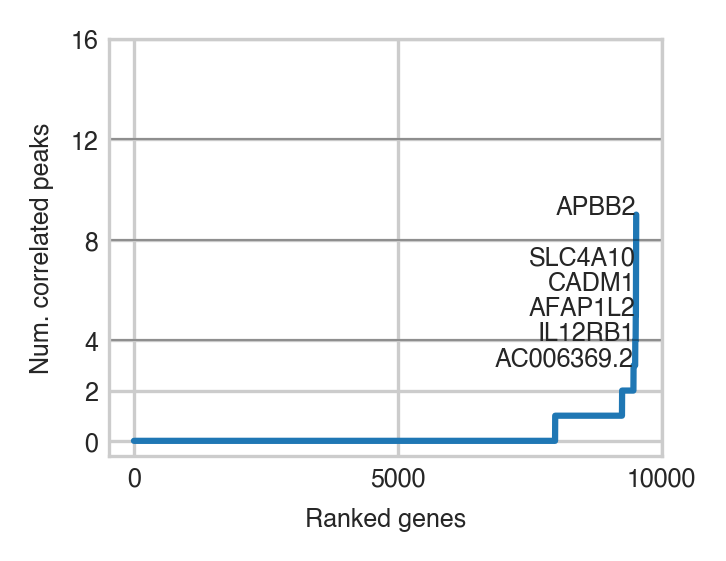

In [164]:
fig,ax = plt.subplots(1,1,figsize=(60*mm, 45*mm), dpi=300)
sns.lineplot(x='rank', y='num_sigpeaks', data=GOMP_df, ax=ax)
sns.set_style('white')
setfontsize()

for n in range(3,18):
    if n in GOMP_df.num_sigpeaks.unique():
        gene_plot = GOMP_df[GOMP_df.num_sigpeaks == n].index[0]
        ax.text(GOMP_df.loc[gene_plot,'rank'], GOMP_df.loc[gene_plot,'num_sigpeaks'], gene_plot, ha='right')

ax.axhline(4,color='k', linewidth=0.5, alpha=0.3)
ax.axhline(8,color='k', linewidth=0.5, alpha=0.3)
ax.axhline(12,color='k', linewidth=0.5, alpha=0.3)
ax.set_ylabel('Num. correlated peaks')
ax.set_xlabel('Ranked genes')

ax.set_xticks([0,5000,10000])
ax.set_yticks([0,2,4,8,12,16])

ax.tick_params(axis='both', pad=-1)

plt.show()

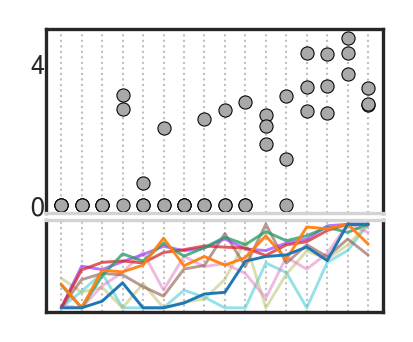

In [165]:
pgplot('APBB2', plain=True)

The "elbow" of this graph occurs with 3 or more significantly correlated peaks, so that's where we draw our line for DORCs.  Our analysis is not as detailed as the original DORC paper of course!

In [165]:
GOMPs = GOMP_df[GOMP_df.num_sigpeaks > 2].num_sigpeaks
GOMPs

AC006369.2    3.0
MFSD10        3.0
GMDS          3.0
GNLY          3.0
CPPED1        3.0
LAYN          3.0
KLRC1         3.0
RHOH          3.0
RAB3GAP1      3.0
RPL13A        3.0
ITK           3.0
AKAP5         3.0
IFNGR1        3.0
AC005083.1    3.0
PDGFRB        3.0
IFI44         3.0
RCAN1         3.0
DGKZ          3.0
HDGFRP3       3.0
KLF2          3.0
CCL4          3.0
PIK3AP1       3.0
RASA3         3.0
ADAM19        3.0
GPR132        3.0
DPP4          3.0
KIAA1217      3.0
ABCB1         3.0
MYO1D         3.0
TBC1D31       3.0
ENTPD1        3.0
ITGA1         3.0
IGFBP3        3.0
IL12RB1       4.0
CAMK1D        4.0
CD70          4.0
MACC1         4.0
CSF2          4.0
FAM49A        4.0
CD86          4.0
IL4           4.0
AOAH          4.0
AFAP1L2       5.0
DDB2          5.0
KIR2DL4       5.0
ACTB          5.0
KLRD1         5.0
CADM1         6.0
HDAC9         6.0
SLC4A10       7.0
DOCK5         7.0
APBB2         9.0
PIP5K1B       9.0
Name: num_sigpeaks, dtype: float64

In [166]:
GOMPs.to_csv('GOMPs.csv')

In [136]:
PCR_summary.loc[GOMPs.index].sort_values('num_sigpeaks')

promoter_R_sq num_eig  num_peaks  num_sigpeaks  eigen0_R_sq  \
AC006369.2             0       1        8.0           3.0     0.532993   
IGFBP3          0.383687       1        3.0           3.0     0.474883   
ITGA1                  0       1        7.0           3.0     0.621205   
ENTPD1                 0       1       15.0           3.0     0.442126   
TBC1D31         0.002214       1        9.0           3.0     0.453935   
MYO1D                  0       1       14.0           3.0     0.511911   
ABCB1           0.556117       1        3.0           3.0     0.631048   
DPP4            0.000005       1       11.0           3.0     0.589874   
GPR132                 0       1        6.0           3.0     0.450070   
ADAM19                 0       1       14.0           3.0     0.551562   
RASA3                  0       1        6.0           3.0     0.437094   
PIK3AP1         0.250485       1        6.0           3.0     0.340205   
CCL4            0.228121       1        6.0           3.0     0.396392   
KLF2                   0       1        3.0           3.0     0.354195   
HDGFRP3          0.42376       1        3.0           3.0     0.454913   
DGKZ            0.283789       1        9.0           3.0     0.523335   
KIAA1217               0       1        6.0           3.0     0.436453   
IFI44                  0       1        5.0           3.0     0.500064   
PDGFRB                 0       1        5.0           3.0     0.577914   
AC005083.1             0       1        3.0           3.0     0.524511   
IFNGR1          0.237708       1        6.0           3.0     0.562985   
AKAP5                  0       1        5.0           3.0     0.480635   
ITK             0.051039       1       22.0           3.0     0.458111   
RPL13A          0.072742       1       10.0           3.0     0.413930   
RAB3GAP1               0       1        4.0           3.0     0.588297   
RHOH            0.469033       1       10.0           3.0     0.474687   
RCAN1           0.209675       1        5.0           3.0     0.421684   
KLRC1           0.686909       1        4.0           3.0     0.635808   
LAYN            0.376845       1        4.0           3.0     0.335216   
CPPED1                 0       1        4.0           3.0     0.522450   
GNLY            0.630406       1        6.0           3.0     0.639474   
GMDS                   0       1       11.0           3.0     0.508207   
MFSD10          0.170123       1        6.0           3.0     0.568775   
AOAH                   0       1       11.0           4.0     0.553302   
CD86                   0       1       12.0           4.0     0.473404   
IL4                    0       1        6.0           4.0     0.430388   
FAM49A                 0       1        4.0           4.0     0.782364   
CAMK1D                 0       1       10.0           4.0     0.345152   
MACC1            0.30913       1        5.0           4.0     0.288590   
CD70            0.249818       1        6.0           4.0     0.616981   
IL12RB1         0.263891       1        7.0           4.0     0.390900   
CSF2            0.268171       1        8.0           4.0     0.586634   
AFAP1L2                0       1        9.0           5.0     0.556553   
DDB2            0.296176       1        6.0           5.0     0.690071   
KIR2DL4                0       1        7.0           5.0     0.535867   
ACTB            0.345648       1       13.0           5.0     0.751650   
KLRD1           0.688533       1        8.0           5.0     0.692850   
CADM1            0.54748       1        9.0           6.0     0.462869   
HDAC9           0.424023       1        9.0           6.0     0.482945   
SLC4A10         0.009596       1       16.0           7.0     0.531279   
DOCK5           0.672861       1       12.0           7.0     0.720934   
APBB2           0.624782       1       12.0           9.0     0.710304   
PIP5K1B           0.3177       1       11.0           9.0     0.375323   

            ei

In [167]:
GOMPs.index

Index(['AC006369.2', 'MFSD10', 'GMDS', 'GNLY', 'CPPED1', 'LAYN', 'KLRC1',
       'RHOH', 'RAB3GAP1', 'RPL13A', 'ITK', 'AKAP5', 'IFNGR1', 'AC005083.1',
       'PDGFRB', 'IFI44', 'RCAN1', 'DGKZ', 'HDGFRP3', 'KLF2', 'CCL4',
       'PIK3AP1', 'RASA3', 'ADAM19', 'GPR132', 'DPP4', 'KIAA1217', 'ABCB1',
       'MYO1D', 'TBC1D31', 'ENTPD1', 'ITGA1', 'IGFBP3', 'IL12RB1', 'CAMK1D',
       'CD70', 'MACC1', 'CSF2', 'FAM49A', 'CD86', 'IL4', 'AOAH', 'AFAP1L2',
       'DDB2', 'KIR2DL4', 'ACTB', 'KLRD1', 'CADM1', 'HDAC9', 'SLC4A10',
       'DOCK5', 'APBB2', 'PIP5K1B'],
      dtype='object')

In [168]:
print(', '.join(GOMPs.index))

AC006369.2, MFSD10, GMDS, GNLY, CPPED1, LAYN, KLRC1, RHOH, RAB3GAP1, RPL13A, ITK, AKAP5, IFNGR1, AC005083.1, PDGFRB, IFI44, RCAN1, DGKZ, HDGFRP3, KLF2, CCL4, PIK3AP1, RASA3, ADAM19, GPR132, DPP4, KIAA1217, ABCB1, MYO1D, TBC1D31, ENTPD1, ITGA1, IGFBP3, IL12RB1, CAMK1D, CD70, MACC1, CSF2, FAM49A, CD86, IL4, AOAH, AFAP1L2, DDB2, KIR2DL4, ACTB, KLRD1, CADM1, HDAC9, SLC4A10, DOCK5, APBB2, PIP5K1B


Now we plot the GOMPiest of GOMPs... those with 5 or more significantly correlated peaks.

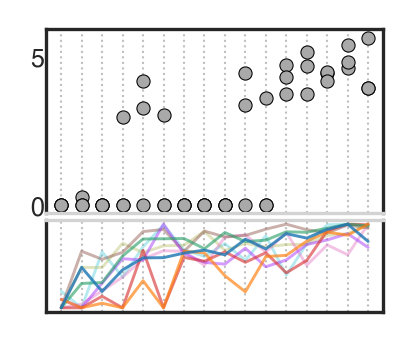

In [168]:
pgplot('CADM1', plain=True)

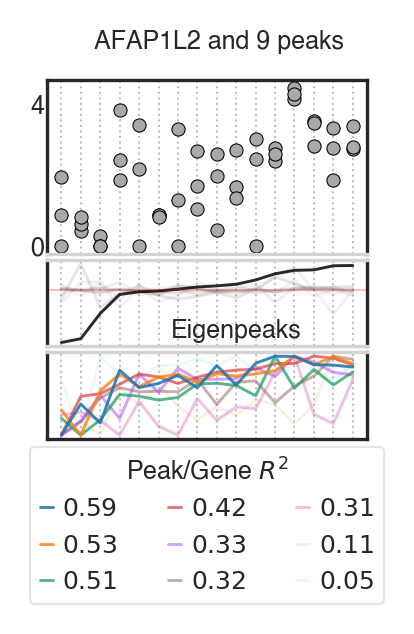

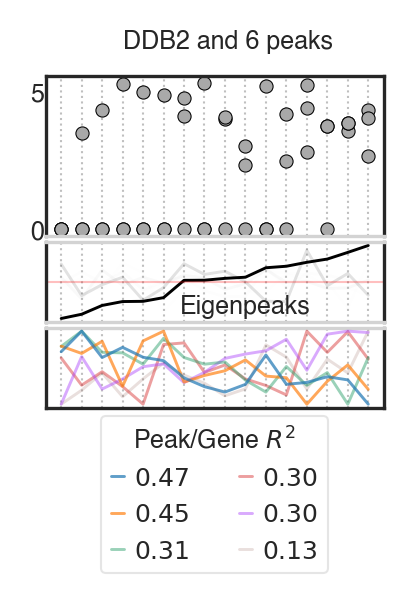

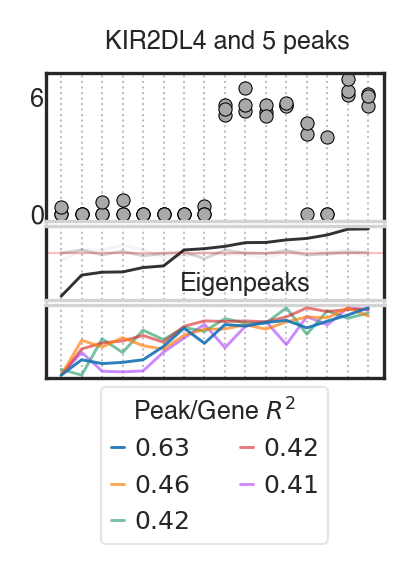

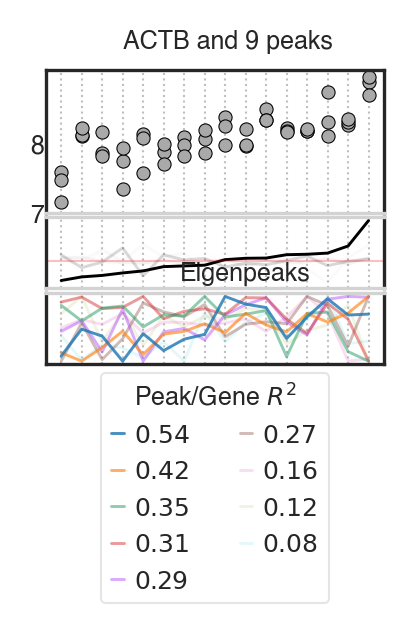

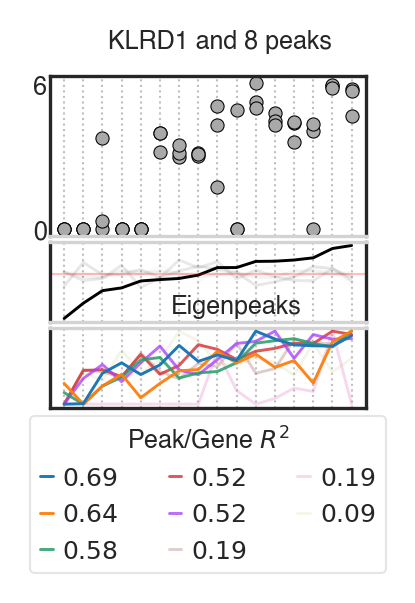

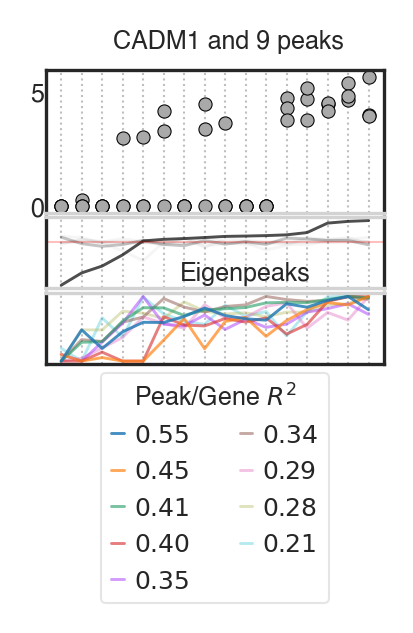

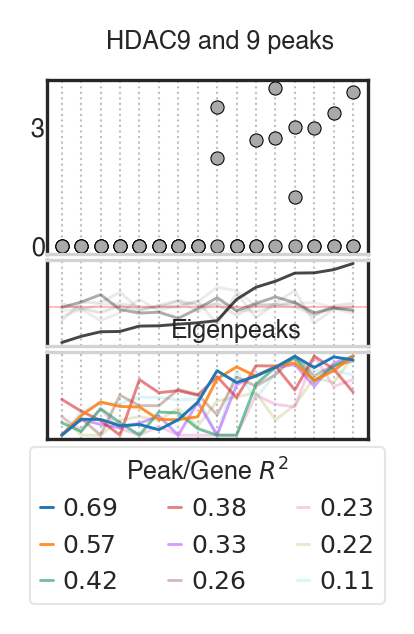

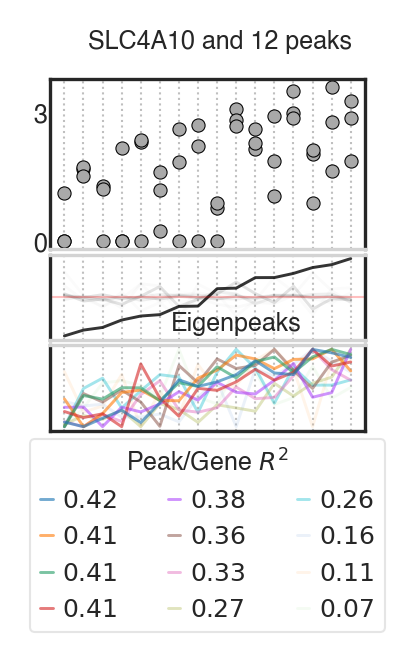

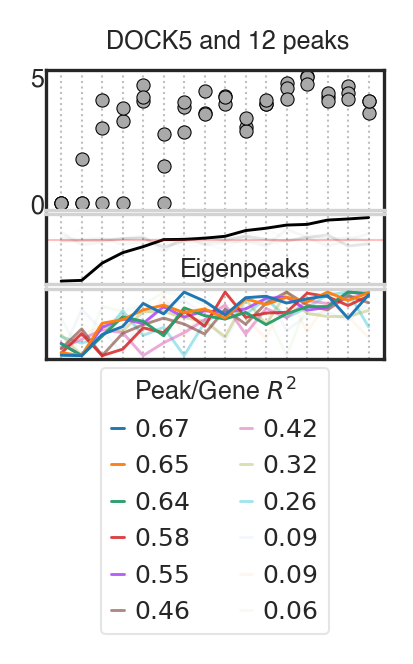

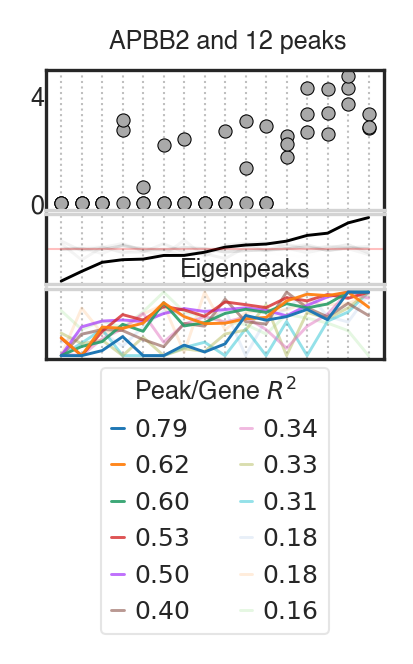

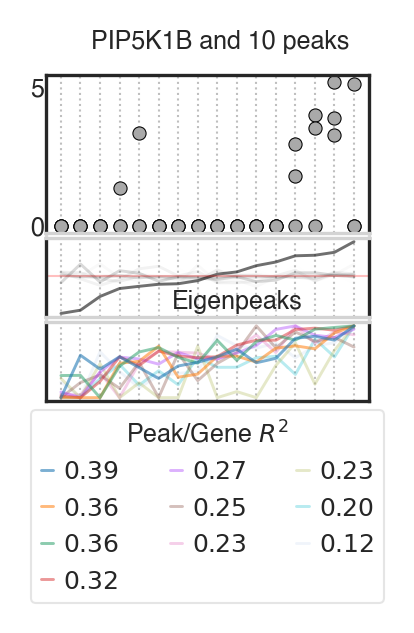

In [169]:
for gene in GOMPs[GOMPs > 4].index:
    pgplot(gene, eigen=True, cutoff=0.05)

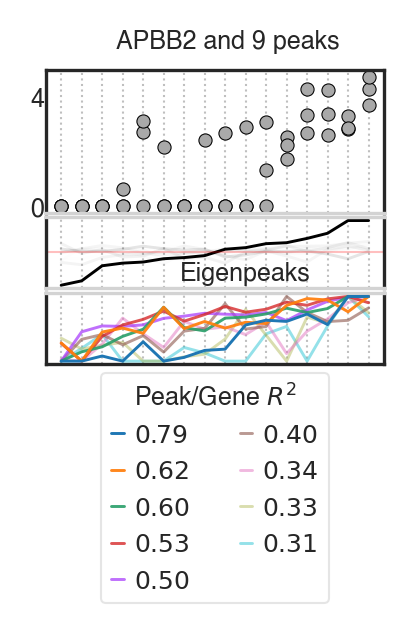

In [171]:
pgplot('APBB2', eigen=True, cutoff=0.226)

In [170]:
R2_sigs['APBB2']

0.22604174166917793

In [141]:
(adata.var.loc[GOMPs.index].F_pval < 0.01).sum() / len(adata.var.loc[GOMPs.index])

0.4716981132075472

In [142]:
(adata.var.F_pval < 0.01).sum() / len(adata.var)

0.0931644509578143

Note that about 8.3% of genes exhibit clonal expression patterns, according to F-statistic.  But 41.5% of DORC genes do!

# Eigenpeak schematic plots

In [143]:
def eigdata(gene, window=50000, verbose=False, save=False):
    edata = {}
    
    PCR_a = PCR_analysis(gene, window=window)
    peaklist = [row for row in PCR_a.index if row[:3] == 'Int']
    pplot_df = peak_clonal[peaklist].copy()
    
    if verbose:
        print('The clonal peak averages are below')
        display(pplot_df)
    
    edata['peak_clonal'] = pplot_df
    
    eig_cols = [col for col in PCR_a.columns if col[:3] == 'Eig']
    eig_weights = PCR_a.loc[peaklist, eig_cols]
    
    realpeaks = pplot_df
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    
    edata['peak_z'] = normpeaks
    
    edata['eig_weights'] = eig_weights
    
    edata['peak_corr'] = normpeaks.corr()
    
    eig_df = normpeaks.dot(eig_weights)

    edata['eigenpeaks'] = eig_df
    
    eigR2 = PCR_a.loc[gene+'_Rsq',eig_cols].astype(float)
    edata['eigR2'] = eigR2
    
    edata['peak_meta'] = ATACR_data.var.loc[peaklist][['chr','start','mid','end','in_gene','itype']]
    
    if save:
        outdir = './eigendata/{}/'.format(gene)
        if not os.path.exists(outdir):
            os.makedirs(outdir)
            
        for key in edata.keys():
            outname = key+'.csv'
            fullname = os.path.join(outdir, outname)  
            edata[key].to_csv(fullname)
            
    return edata

In [144]:
import os

In [145]:
edata = eigdata('CTLA4', window=100000, save=True)

In [146]:
for gene in ['KLRD1', 'CD28', 'MAST4', 'PMS2P1']:
    eigdata(gene, save=True)

In [147]:
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize

In [148]:
def eig_weightplot(gene, window=50000, num_eig = 5, eigplot=False, xlim=None):
    
    if eigplot:
        figsize=(100*mm, num_eig * 6*mm)
        fig,ax = plt.subplots(num_eig,2,figsize=figsize, dpi=300,
                             gridspec_kw={'wspace':0.3})
    else:
        figsize=(40*mm, num_eig * 6*mm)
        fig,ax = plt.subplots(num_eig,1,figsize=figsize, dpi=300)
        
    sns.set_style('white')
    setfontsize()
    
    edata = eigdata(gene, window=window)
    peaklist = edata['peak_meta'].index
    chrome = edata['peak_meta'].chr[0]
    
    xmin, xmax = edata['peak_meta'].start.min() - 5000, edata['peak_meta'].end.max() + 5000
    
    pm = edata['peak_meta']
    TSS_locs = pm[pm.itype == 'promoter-TSS'].mid
    
    cmap = plt.cm.seismic
    norm = Normalize(vmin=-1, vmax=1)
    
    eigenpeaks = edata['eigR2'].sort_values(ascending=False)[:num_eig].index
    
    if eigplot:
        eigplot_df = edata['eigenpeaks'][eigenpeaks].copy()
        eigplot_df['Clone'] = eigplot_df.index
        eigplot_df.sort_values(by=eigenpeaks[0], inplace=True)
        eigmax = eigplot_df[eigenpeaks[0]].max()
        eigmin = eigplot_df[eigenpeaks[0]].min()
    
    display(peaklist)
    for j,epeak in enumerate(eigenpeaks):
        if eigplot:
            axx = ax[j,0]
        else:
            axx = ax[j]
            
        for peak in peaklist:
            x_start = edata['peak_meta'].start[peak]
            x_end = edata['peak_meta'].end[peak]
            x_width = x_end - x_start
            wt = edata['eig_weights'].loc[peak, epeak]
            wt_color = cmap(norm(wt))
            rect = Rectangle((x_start, 0), x_width, 1, linewidth=0.5, edgecolor=wt_color, 
                             facecolor=wt_color)
            axx.add_patch(rect)
        if xlim:
            axx.set_xlim(xlim[0], xlim[1])
        else:
            axx.set_xlim(xmin, xmax)
        if j > 0:
            axx.spines['top'].set_color('lightgray')
        if j < len(eigenpeaks) - 1:
            axx.spines['bottom'].set_color('lightgray')
        axx.spines['left'].set_color('lightgray')
        axx.spines['right'].set_color('lightgray')
        axx.set_xticks(TSS_locs)
        axx.set_xticklabels(['']*len(TSS_locs))
        axx.tick_params(axis='x',pad=-1,direction='out', length=1, bottom=True, top=True, colors='green')
        axx.set_yticks([])
    
        if eigplot:
            
            sns.lineplot(x='Clone', y=epeak, data=eigplot_df, ax=ax[j,1], linewidth=0.7)
            ax[j,1].set_ylim(eigmin,eigmax)
            ax[j,1].set_xticks([])
            ax[j,1].set_yticks([])
            ax[j,1].set_xlabel('')
            ax[j,1].set_ylabel('')
            if j > 0:
                ax[j,1].spines['top'].set_color('lightgray')
            if j < len(eigenpeaks) - 1:
                ax[j,1].spines['bottom'].set_color('lightgray')
            ax[j,1].spines['left'].set_color('lightgray')
            ax[j,1].spines['right'].set_color('lightgray')
            
    set_size(fig, figsize)
    plt.savefig("Panels/{}_eigweights.pdf".format(gene), bbox_inches='tight')
    print('Chromosome {}, from {} to {}'.format(chrome, xmin, xmax))
    plt.show()

Index(['Interval_15297', 'Interval_15296', 'Interval_15295', 'Interval_15289',
       'Interval_15299', 'Interval_15290', 'Interval_15298', 'Interval_15294'],
      dtype='object', name='PeakID')

Chromosome 12, from 10396907 to 10478811


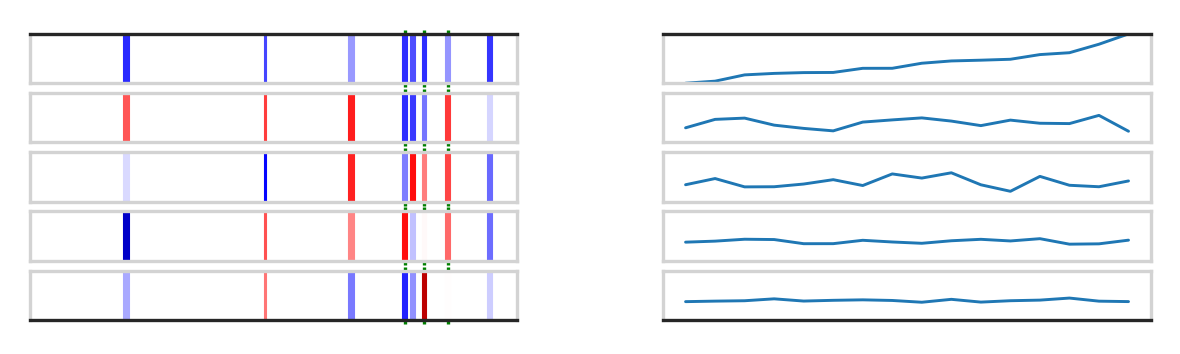

In [149]:
eig_weightplot('KLRD1', eigplot=True, xlim=(10383487,10478811))

In [150]:
PCR_analysis('KLRD1')

PeakID         Interval_15297 Interval_15289 Interval_15290 Interval_15299  \
PeakID                                                                       
Interval_15297            1.0            0.0            0.0            0.0   
Interval_15296            0.0            0.0            0.0            0.0   
Interval_15295            0.0            0.0            0.0            0.0   
Interval_15289            0.0            1.0            0.0            0.0   
Interval_15299            0.0            0.0            0.0            1.0   
Interval_15290            0.0            0.0            1.0            0.0   
Interval_15298            0.0            0.0            0.0            0.0   
Interval_15294            0.0            0.0            0.0            0.0   
KLRD1_R              0.829779       0.720321       0.434741       0.719297   
KLRD1_Rsq            0.688533       0.518863          0.189       0.517388   
KLRD1_promoter           True          False          False          False   

PeakID         Interval_15294 Interval_15296 Interval_15298 Interval_15295  \
PeakID                                                                       
Interval_15297            0.0            0.0            0.0            0.0   
Interval_15296            0.0            1.0            0.0            0.0   
Interval_15295            0.0            0.0            0.0            1.0   
Interval_15289            0.0            0.0            0.0            0.0   
Interval_15299            0.0            0.0            0.0            0.0   
Interval_15290            0.0            0.0            0.0            0.0   
Interval_15298            0.0            0.0            1.0            0.0   
Interval_15294            1.0            0.0            0.0            0.0   
KLRD1_R              0.303016       0.799779       0.432529         0.7591   
KLRD1_Rsq            0.091818       0.639647       0.187081       0.576233   
KLRD1_promoter          False          False           True           True   

PeakID          Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  Eigenpeak 3  \
PeakID                                                               
Interval_15297     0.761761     0.014733    -0.227677     0.113750   
Interval_15296    -0.216165    -0.124234     0.413334    -0.465630   
Interval_15295    -0.437410     0.474231    -0.421500     0.065481   
Interval_15289    -0.170573    -0.651711    -0.464730    -0.184104   
Interval_15299    -0.094211    -0.282263     0.525305     0.617249   
Interval_15290     0.270930     0.340489     0.293400    -0.455293   
Interval_15298     0.005733     0.289588    -0.092537     0.377019   
Interval_15294    -0.265064     0.235076     0.114413     0.040451   
KLRD1_R           -0.123147    -0.178881    -0.036231     0.102555   
KLRD1_Rsq          0.015165     0.031998     0.001313     0.010517   
KLRD1_promoter          NaN          NaN          NaN          NaN   

PeakID          Eigenpeak 4  Eigenpeak 5  Eigenpeak 6  Eigenpeak 7  
PeakID                                                              
Interval_15297    -0.265724     0.255557     0.219916    -0.412851  
Interval_15296    -0.389877     0.471416    -0.239510    -0.344355  
Interval_15295    -0.411478    -0.254441     0.047943    -0.406785  
Interval_15289     0.334614    -0.077374    -0.045406    -0.419874  
Interval_15299    -0.084299    -0.293779     0.066158    -0.395881  
Interval_15290     0.380166    -0.484472    -0.080593    -0.362705  
Interval_15298     0.382906     0.360582    -0.668789    -0.203676  
Interval_15294     0.444810     0.436682     0.657085    -0.198609  
KLRD1_R           -0.252720     0.237872    -0.074535    -0.832376  
KLRD1_Rsq          0.063867     0.056583     0.005555     0.692850  
KLRD1_promoter          NaN          NaN          NaN          NaN

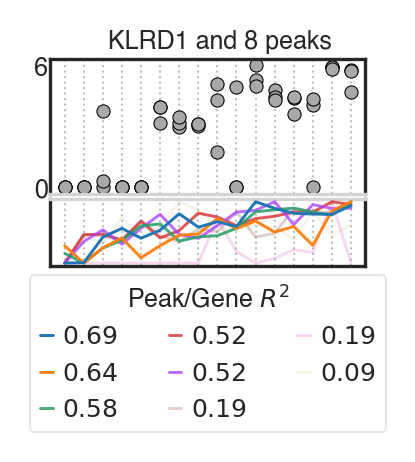

In [151]:
pgplot('KLRD1', cutoff=0.05)

# Cross-experiment check

In [202]:
topbottom = (ATAC_good.to_df().max() - ATAC_good.to_df().min()) / ATAC_good.var['replicate_foldchange']
topbottom.sort_values() # A measure of peak variability.

PeakID
Interval_27510    0.175502
Interval_57312    0.184238
Interval_68877    0.187235
Interval_58196    0.192014
Interval_66138    0.196035
                    ...   
Interval_31669    4.321584
Interval_71146    4.339211
Interval_80129    4.347736
Interval_15946    4.438138
Interval_71334    4.508862
Length: 39858, dtype: float64

In [255]:
dist_mat = {}
dist_mask = {}
var_near = {}
for chrome in chromes:
    gene_TSSs = adata.var[adata.var['chr'] == chrome].TSS.sort_values()
    peak_mids = ATAC_good.var[ATAC_good.var['chr'] == chrome].mid.sort_values()
    dist_mat[chrome] = pd.DataFrame(np.abs(np.subtract.outer(gene_TSSs.values, peak_mids.values)),
                                    index=gene_TSSs.index, columns=peak_mids.index)

    dist_mask[chrome] = (dist_mat[chrome] <= 50000)
    tb = topbottom.loc[peak_mids.index]
    tb_near = dist_mask[chrome].multiply(tb)
    var_near[chrome] = tb_near.sum(axis=1)

In [256]:
peakvar_near = pd.concat([var_near[chrome] for chrome in chromes])
peakvar_near.sort_values()

gene_name
MTND2P28          0.000000
SMN1              0.000000
SMN2              0.000000
RP11-98J23.2      0.000000
PDE4D             0.000000
                   ...    
RP11-473M20.7    17.298140
IL32             17.298140
EPS15L1          17.639088
CSF2             18.391062
CTD-3094K11.1    18.945872
Length: 9520, dtype: float64

In [257]:
adata.var['nearby_peakvar'] = 0
adata.var['nearby_peakvar'] = peakvar_near
adata.var['log_F_pval'] = -np.log10(adata.var['F_pval'])
adata.var.head()

ENSG    F_pval  GC_content     TSS chr  dir     end  \
gene_name                                                                       
MTND2P28       ENSG00000225630  0.500309       43.10  565020   1    1  566063   
hsa-mir-6723   ENSG00000237973  0.021218       45.76  566454   1    1  567996   
MTATP6P1       ENSG00000248527  0.000096       43.91  569076   1    1  569756   
RP11-206L10.9  ENSG00000237491  0.704243       40.42  714150   1    1  745440   
LINC01128      ENSG00000228794  0.667158       46.34  762988   1    1  794826   

                   gene_name  highly_variable  highly_variable_rank  ...  \
gene_name                                                            ...   
MTND2P28            MTND2P28                0                   NaN  ...   
hsa-mir-6723    hsa-mir-6723                0                   NaN  ...   
MTATP6P1            MTATP6P1                0                   NaN  ...   
RP11-206L10.9  RP11-206L10.9                0                   NaN  ...   
LINC01128          LINC01128                0                   NaN  ...   

               n_cells_by_counts  pct_dropout_by_counts   start  total_counts  \
gene_name                                                                       
MTND2P28                      67               4.285714  565020    203.999100   
hsa-mir-6723                  63              10.000000  566454    107.062729   
MTATP6P1                      69               1.428571  569076    380.220612   
RP11-206L10.9                  5              92.857143  714150     12.996776   
LINC01128                      4              94.285714  762988     12.210242   

               transcript_length     variances  variances_norm  Expressed  \
gene_name                                                                   
MTND2P28             1044.000000    388.754658        0.069281       True   
hsa-mir-6723         1543.000000    137.753416        0.087108       True   
MTATP6P1              681.000000  25071.186128        0.411845       True   
RP11-206L10.9         704.000000     34.765217        0.635988       True   
LINC01128            1197.363636    114.340373        0.837090       True   

               nearby_peakvar  log_F_pval  
gene_name                                  
MTND2P28             0.000000    0.300762  
hsa-mir-6723         0.000000    1.673288  
MTATP6P1             0.000000    4.017030  
RP11-206L10.9        1.061346    0.152277  
LINC01128            2.094601    0.175771  

[5 rows x 25 columns]

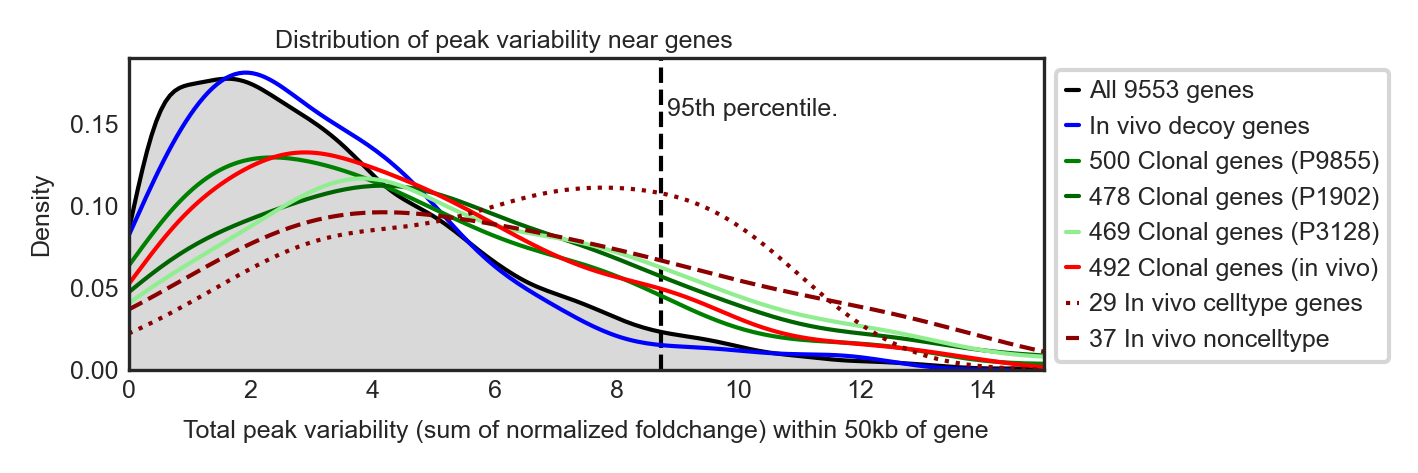

In [356]:
figsize=(120*mm, 40*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
sns.set_style('whitegrid')
sns.kdeplot(adata.var['nearby_peakvar'], label='All {} genes'.format(len(adata.var)), clip=(0,15), ax=ax, linewidth=1,
           color='black')

sns.kdeplot(adata.var['nearby_peakvar'], clip=(0,15), ax=ax, linewidth=0,
           color='black', fill=True, alpha=0.15)

vcut = adata.var['nearby_peakvar'].quantile(0.95)
ax.axvline(vcut, linewidth=1, linestyle='--', color='k')
ax.text(vcut+0.1,0.155,'95th percentile.')

sns.kdeplot(adata.var.loc[D_genes]['nearby_peakvar'], 
             label='In vivo decoy genes', clip=(0,15), ax=ax, color='blue', linewidth=1)

#sns.distplot(adata.var[adata.var['F_pval'] < 0.01]['nearby_peakvar'], label='Clonal genes')

P9855_genes = adata.var.F_pval.sort_values()[:500].index
sns.kdeplot(adata.var.loc[P9855_genes]['nearby_peakvar'], 
             label='{} Clonal genes (P9855)'.format(len(P9855_genes)), 
            clip=(0,15), ax=ax, linewidth=1, color='green')

sns.kdeplot(adata.var.loc[P1902_genes]['nearby_peakvar'], 
             label='{} Clonal genes (P1902)'.format(len(P1902_genes)), 
            clip=(0,15), ax=ax, linewidth=1, color='darkgreen')

sns.kdeplot(adata.var.loc[P3128_genes]['nearby_peakvar'], 
             label='{} Clonal genes (P3128)'.format(len(P3128_genes)), 
            clip=(0,15), ax=ax, linewidth=1, color='lightgreen')

sns.kdeplot(adata.var.loc[W_genes]['nearby_peakvar'], 
             label='{} Clonal genes (in vivo)'.format(len(W_genes)), 
            clip=(0,15), ax=ax, linewidth=1, color='red')

sns.kdeplot(adata.var.loc[genes_ct]['nearby_peakvar'], 
             label='{} In vivo celltype genes'.format(len(genes_ct)), clip=(0,15), ax=ax, linewidth=1, 
            color='darkred', linestyle=':')

sns.kdeplot(adata.var.loc[genes_nct]['nearby_peakvar'], 
             label='{} In vivo noncelltype'.format(len(genes_nct)), clip=(0,15), ax=ax, linewidth=1, 
            color='darkred', linestyle='--')

ax.set_xlim(0,15)
ax.set_xlabel('Total peak variability (sum of normalized foldchange) within 50kb of gene')
ax.tick_params(axis='both', pad=-1)
ax.legend(bbox_to_anchor = (1.0,1.0))
plt.suptitle('Distribution of peak variability near genes')
set_size(fig, figsize)
plt.savefig("Panels/Crossexp_peakvar.pdf".format(gene), bbox_inches='tight')

plt.show()

In [250]:
len(W_genes)

492

In [238]:
invivo_genes = pd.read_csv('../Data/Invivo_genes.csv', index_col = 0)
invivo_genes = invivo_genes.loc[ [gene for gene in invivo_genes.index if gene in adata.var_names]]
genes_ct = invivo_genes[invivo_genes.celltype].index
genes_nct = invivo_genes[~invivo_genes.celltype].index
invivo_genes

celltype
GZMH          True
NKG7          True
FGFBP2        True
GZMB          True
GPR56         True
...            ...
CTSW         False
LY6E         False
IL2RB        False
TMSB4XP8     False
CD300A       False

[66 rows x 1 columns]

In [248]:
W_genes = pd.read_csv('../Data/w_genes.csv', index_col = 0)['0'].values
W_genes = [gene for gene in W_genes if gene in adata.var_names]

In [266]:
D_genes = pd.read_csv('../Data/decoy_genes.csv', index_col = 0)['0'].values
D_genes = [gene for gene in D_genes if gene in adata.var_names]

In [354]:
P1902_genes = pd.read_csv('../Data/P1902_sigs.csv', index_col = 0)['gene_name'].values
P1902_genes = [gene for gene in P1902_genes if gene in adata.var_names]
len(P1902_genes)

478

In [355]:
P3128_genes = pd.read_csv('../Data/P3128_sigs.csv', index_col = 0)['gene_name'].values
P3128_genes = [gene for gene in P3128_genes if gene in adata.var_names]
len(P3128_genes)

469

In [263]:
ATAC_data.var[ATAC_data.var['itype'] == 'promoter-TSS'].to_csv('ATAC_promoters_clonality.csv')

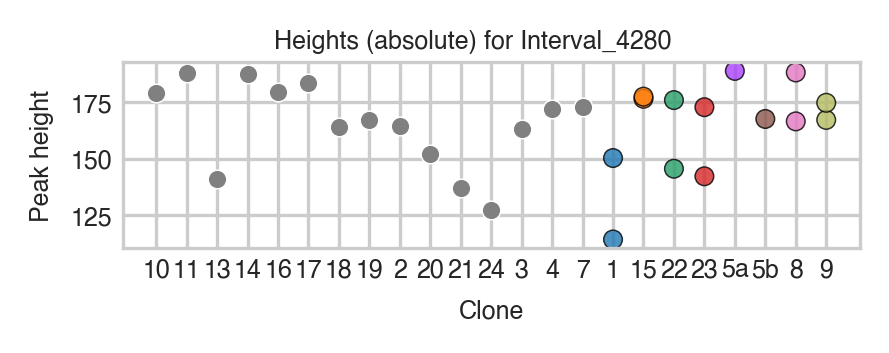

In [262]:
ATAC_plot('Interval_4280')

# Different kinds of peaks and genes

In [176]:
dist_mat = {}
pro_peaks_dict = {}
enh_peaks_dict = {}
pro_corrs_dict = {}
enh_corrs_dict = {}
pro_score_dict = {}
enh_score_dict = {}
for chrome in chromes:
    gene_TSSs = adata.var[adata.var['chr'] == chrome].TSS.sort_values()
    peak_mids = ATAC_data.var[ATAC_data.var['chr'] == chrome].mid.sort_values()
    dist_mat[chrome] = pd.DataFrame(np.abs(np.subtract.outer(gene_TSSs.values, peak_mids.values)),
                                    index=gene_TSSs.index, columns=peak_mids.index)
    pp = (dist_mat[chrome] <= 1000).any()
    pro_peaks_dict[chrome] = pp[pp].index
    
    ee = (dist_mat[chrome] <= 50000).any() & (~(dist_mat[chrome] <= 1000).any())
    enh_peaks_dict[chrome] = ee[ee].index
    
    enh_corrs_dict[chrome] = pg_corrs[chrome].where((dist_mat[chrome].T <= 50000) & ~(dist_mat[chrome].T <= 1000)).T
    
    pro_corrs_dict[chrome] = pg_corrs[chrome].where((dist_mat[chrome].T <= 1000)).T
    
    e_ss = enh_corrs_dict[chrome]**2
    p_ss = pro_corrs_dict[chrome]**2
    enh_score_dict[chrome] = (e_ss).sum(axis=1)
    pro_score_dict[chrome] = (p_ss).sum(axis=1)
    
    e_num = (e_ss > 0).sum(axis=1)
    p_num = (p_ss > 0).sum(axis=1)
    e_adj = e_num * R2_sigs.loc[e_num.index]
    p_adj = p_num * R2_sigs.loc[e_num.index]
    enh_score_dict[chrome] -= e_adj
    pro_score_dict[chrome] -= p_adj
    
pro_peaks = [peak for chrome in chromes for peak in pro_peaks_dict[chrome]]
enh_peaks = [peak for chrome in chromes for peak in enh_peaks_dict[chrome]]

enh_scores = pd.concat([enh_score_dict[chrome] for chrome in chromes]).dropna()
pro_scores = pd.concat([pro_score_dict[chrome] for chrome in chromes]).dropna()

array(['RGCC', 'MIR320E', 'C19orf25', 'TMEM140', 'AC004967.7', 'KLF16',
       'NAGK', 'LMTK2', 'SNHG7', 'TDRD3', 'MYCBP', 'CANX', 'RNF19A',
       'EFCAB14', 'SNX5', 'LIN54', 'MSRB1', 'TMEM261', 'NEDD8', 'NAA10-1',
       'INTS10', 'GIPR', 'C8orf33', 'NCBP2-AS2', 'AMFR', 'COX5B',
       'ZNF740', 'RBM18', 'NADSYN1', 'SMIM13', 'EPS15', 'PRDM10',
       'N4BP2L2', 'CDC5L', 'MMADHC', 'HDHD1', 'TRIM38', 'MAD2L2',
       'CTD-2325M2.1', 'LINC00984', 'ANXA2', 'TLK1', 'RHOC', 'RALGAPA1',
       'TRIM28', 'LRRC57', 'HSPA8', 'ATAD2B', 'ERCC4', 'SAMD8', 'ECH1',
       'MXD1', 'EMD-1', 'SAFB', 'CYCS', 'SPIRE1', 'GTPBP8', 'PXN-AS1',
       'PSIP1', 'CYLD', 'SCARNA2', 'FOXJ3', 'CUTC', 'NCALD', 'CEP85',
       'NCR3', 'KDM2B', 'SLC11A2', 'PUM2', 'RNY4', 'ARL1', 'PLOD3',
       'RP5-886K2.3', 'RUNX3', 'TEP1', 'SIRT3', 'SCFD1', 'PPIP5K2',
       'CAND1', 'ELOF1', 'IFT52', 'KIAA0430', 'HIST3H2A', 'KLHL42',
       'DEGS1', 'AL136419.6', 'ZNF155', 'CD80', 'ARHGDIB', 'PAK1IP1',
       'ARRDC2', 'TPT1-AS1

In [228]:
enh_genes = list(enh_scores.sort_values(ascending=False)[:200].index)
pro_genes = list(pro_scores.sort_values(ascending=False)[:200].index)
rando_genes= list(np.random.choice(pro_scores.index, 200))
print('Enhancer-scoring genes are:  {}'.format(', '.join(enh_genes)))
print('Promoter-scoring genes are:  {}'.format(', '.join(pro_genes)))

Enhancer-scoring genes are:  APBB2, FAM49A, SPRY2, AC005083.1, HLA-DPA1, CSF2, RCAN1, KLRC1, LSM7, HPGD, HDGFRP3, AC092580.4, ZNF251, CTSL, AC079325.6, PLS3-1, S1PR1, AFAP1L2, IGFBP3, DEK, CPPED1, TVP23C, PHF20L1, IKZF2, RP11-319G6.1, GLUD1, IQCG, B3GNT5, LSM1, TCEAL4, CCDC141, UVRAG, GIMAP7, POLR3C, SNHG14, MARK3, KIR2DL4, MIR4458HG, TPD52, EGFL6, ITGA1, AC092574.2, ZNF57, RP11-301O19.1, LILRP2, NR3C1, NRP1, ELAC2, RPL37, PDGFRB, PRKAG2, CTBP2, ZHX1, POLR3D, TP53BP1, CADM1, KNOP1, SIRPG, RBM43, CCDC94, ZNF181, ELMO2, TESK2, YPEL2, CD70, ZNF561, ANKRD32, PCM1, RP11-15E18.5, SCO1, HLA-DPB1, FRG1, RAB3GAP1, ST7, C11orf58, MANBA, ZCCHC4, TMEM14A, STXBP3, PCED1B, PDE7B, SBDSP1, DCAF10, RNA5SP151, SEPT7, VAMP4, MED23, SESN1, SERPINE2, SMARCAD1, RAB21, SNX13, METTL16, RNU6-1152P, ALG6, TIMMDC1, TNIK, MRPS16, KLF2, FAM126B, RPL9, AC016747.3, TSR2, DUS3L, RNU6-946P, JRK, POMC, RASA3, CDK19, HEG1, CCNDBP1, SKIL, PARP4, PRKRIR, PABPN1, BTG3, FBXO4, KDM5C-1, SEL1L3, SOCS4, UPF2, PPWD1, REG4, NCOA

In [229]:
adata_z = adata.copy()
adata_z.X = (adata.to_df() - adata.to_df().mean()) / adata.to_df().std()

In [230]:
enh_genes = list(adata_z.to_df()[enh_genes].groupby(adata.obs.Clone_ID).mean().idxmax().sort_values().index)
pro_genes = list(adata_z.to_df()[pro_genes].groupby(adata.obs.Clone_ID).mean().idxmax().sort_values().index)
rando_genes = list(adata_z.to_df()[rando_genes].groupby(adata.obs.Clone_ID).mean().idxmax().sort_values().index)

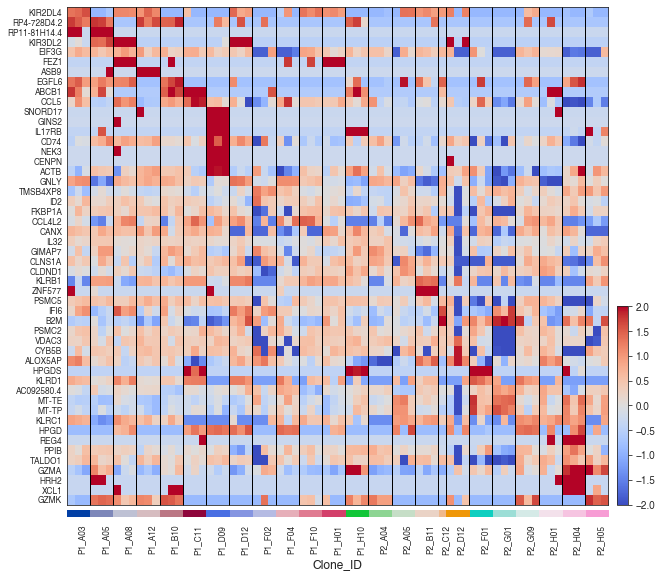

In [319]:
sig_genes = adata.var.F_pval.sort_values()[:50].index
sig_genes = list(adata_z.to_df()[sig_genes].groupby(adata.obs.Clone_ID).mean().idxmax().sort_values().index)

desetfontsize()
sc.pl.heatmap(adata_z, sig_genes, 'Clone_ID', swap_axes=True, cmap='coolwarm', vmin=-2, vmax=2)

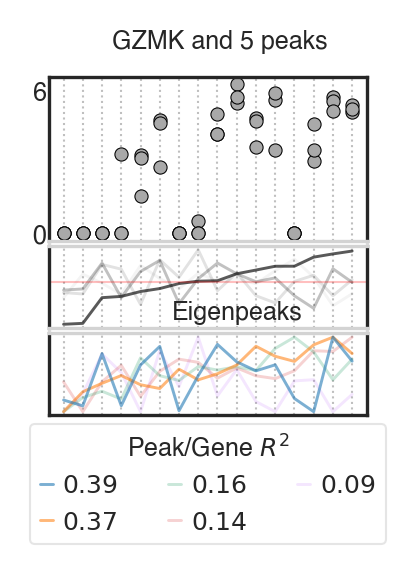

In [333]:
pgplot('GZMK', eigen=True, cutoff=0.05)

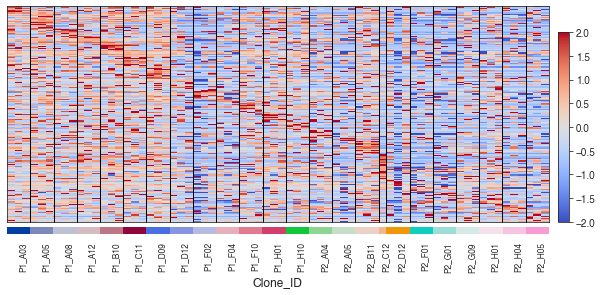

In [231]:
desetfontsize()

sc.pl.heatmap(adata_z, rando_genes, 'Clone_ID', swap_axes=True, cmap='coolwarm', vmin=-2, vmax=2)

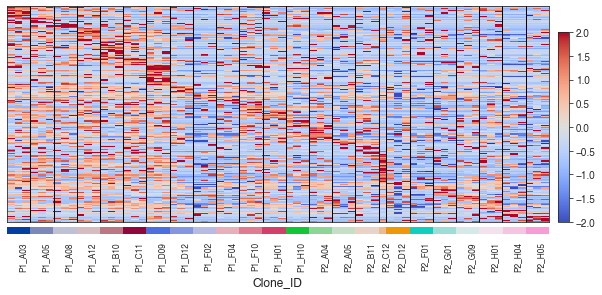

In [218]:
sc.pl.heatmap(adata_z, pro_genes, 'Clone_ID', swap_axes=True, cmap='coolwarm', vmin=-2, vmax=2)

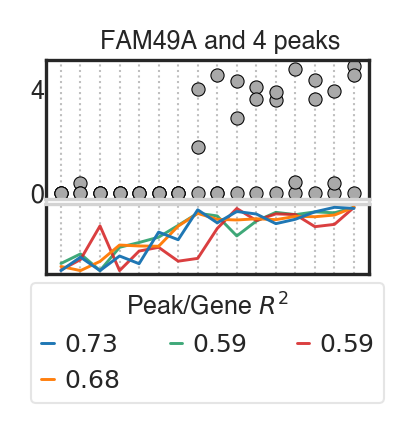

In [167]:
pgplot('FAM49A', window=100000)

In [168]:
np.exp(4) - 1

53.598150033144236

In [169]:
', '.join(pro_scores.sort_values()[-25:].index)

'AC093818.1, CLEC7A, SKAP2, GZMK, UGDH, HSPA9, FAM8A1, HPGD, DOCK5, KLRC4, LINC00861, SLC35B3, AC005083.1, KIR2DL4, RP11-392P7.6, ZBED2, NXPE3, RP11-81H14.4, CCDC152, AMICA1, PLS3-1, GTSF1, SRIP3, AC010970.2, RNA5-8SP6'

In [235]:
len(pro_peaks)

6903

In [236]:
len(enh_peaks)

17122

In [239]:
pro_data = ATAC_data.var.loc[pro_peaks]
enh_data = ATAC_data.var.loc[enh_peaks]
all_data = ATAC_data.var

In [240]:
for df in [pro_data, enh_data, all_data]:
    print(len(df[df.quality_p > 0.1]))
    print(len(df[(df.quality_p > 0.1) & df.clonal_p < 0.01]))
    hrule()

4291
2612
13017
4105
30228
10380


In [269]:
adata.var[adata.var['chr'] == '1'].TSS

gene_name
MTND2P28             565020
hsa-mir-6723         566454
MTATP6P1             569076
RP11-206L10.9        714150
LINC01128            762988
                    ...    
ZNF124            247335307
RP11-488L18.10    247351828
MIR3916           247372795
ZNF692            249152912
PGBD2             249200395
Name: TSS, Length: 1009, dtype: int64

In [286]:
chromes

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 'X',
 'Y']

PeakID      Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
ATAC_clone                                                                   
10_R1             2.928915        2.287843        1.691356        5.560565   
11_R1             2.987230        1.853198        2.670728        5.436592   
13_R1             1.913421        2.070839        2.070839        5.550882   
14_R1             1.827373        1.499256        2.436685        5.567874   
15_R1             2.335525        2.683983        2.465641        5.688357   
15_R2             2.405284        3.251001        2.472925        5.707511   
16_R1             2.246812        0.000000        2.714423        5.558466   
17_R1             2.549848        1.439738        2.006760        5.445604   
18_R1             2.501409        2.734340        2.282356        5.545929   
19_R1             1.948509        2.775430        2.623850        5.629741   
1_R1              2.220971        2.315422        2.116660        5.671244   
1_R2              2.574305        2.743844        2.183737        5.564601   
20_R1             2.707259        2.128885        1.243721        5.444118   
21_R1             1.740334        2.142275        2.142275        5.506553   
22_R1             2.244406        1.836056        1.836056        5.708737   
22_R2             3.193007        2.102691        2.843361        5.701477   
23_R1             1.966361        1.506567        1.684364        5.644652   
23_R2             2.089187        2.495113        2.207124        5.422726   
24_R1             2.262876        2.009289        2.009289        5.711665   
2_R1              2.717578        1.972389        2.088377        5.437860   
3_R1              2.225148        2.426444        2.426444        5.683740   
4_R1              2.464640        3.449496        2.299183        5.493403   
5a_R1             2.751107        2.591159        1.970270        5.644123   
5b_R1             2.779974        2.937437        2.224246        5.609965   
7_R1              2.149178        2.824024        2.065458        5.619921   
8_R1              2.349192        1.845438        2.404186        5.449306   
8_R2              2.764788        1.938780        2.645507        5.587162   
9_R1              2.610464        2.833161        2.774429        5.439472   
9_R2              1.911073        2.905863        2.621405        5.426267   

PeakID      Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
ATAC_clone                                                                  
10_R1             2.287843        3.709698        3.762476       5.194549   
11_R1             2.205004        3.504991        3.114438       5.243369   
13_R1             1.913421        3.751593        3.182416       4.955405   
14_R1             1.499256        3.670255        0.000000       5.240854   
15_R1             1.796163        3.665038        0.890413       5.179786   
15_R2             2.536280        3.984053        0.574085       5.185097   
16_R1             2.246812        4.033247        3.964330       5.195662   
17_R1             2.006760        3.782548        3.326111       5.217739   
18_R1             1.757833        3.732867        2.624641       5.105916   
19_R1             1.707229        3.436920        2.986031       5.123996   
1_R1              2.401717        3.377605        3.313264       4.745931   
1_R2              1.533994        3.179393        3.153849       5.019365   
20_R1             1.243721        3.869145        2.991982       5.031900   
21_R1             2.142275        3.272452        2.885766       4.928832   
22_R1             2.244406        3.383287        1.836056       5.176583   
22_R2             1.986456        3.479647        1.307133       4.987438   
23_R1             1.290173        3.610647        0.000000       4.964272   
23_R2             1.618351        3.594341        1.106046       5.158560   
24_R1             1.668714        2.90259

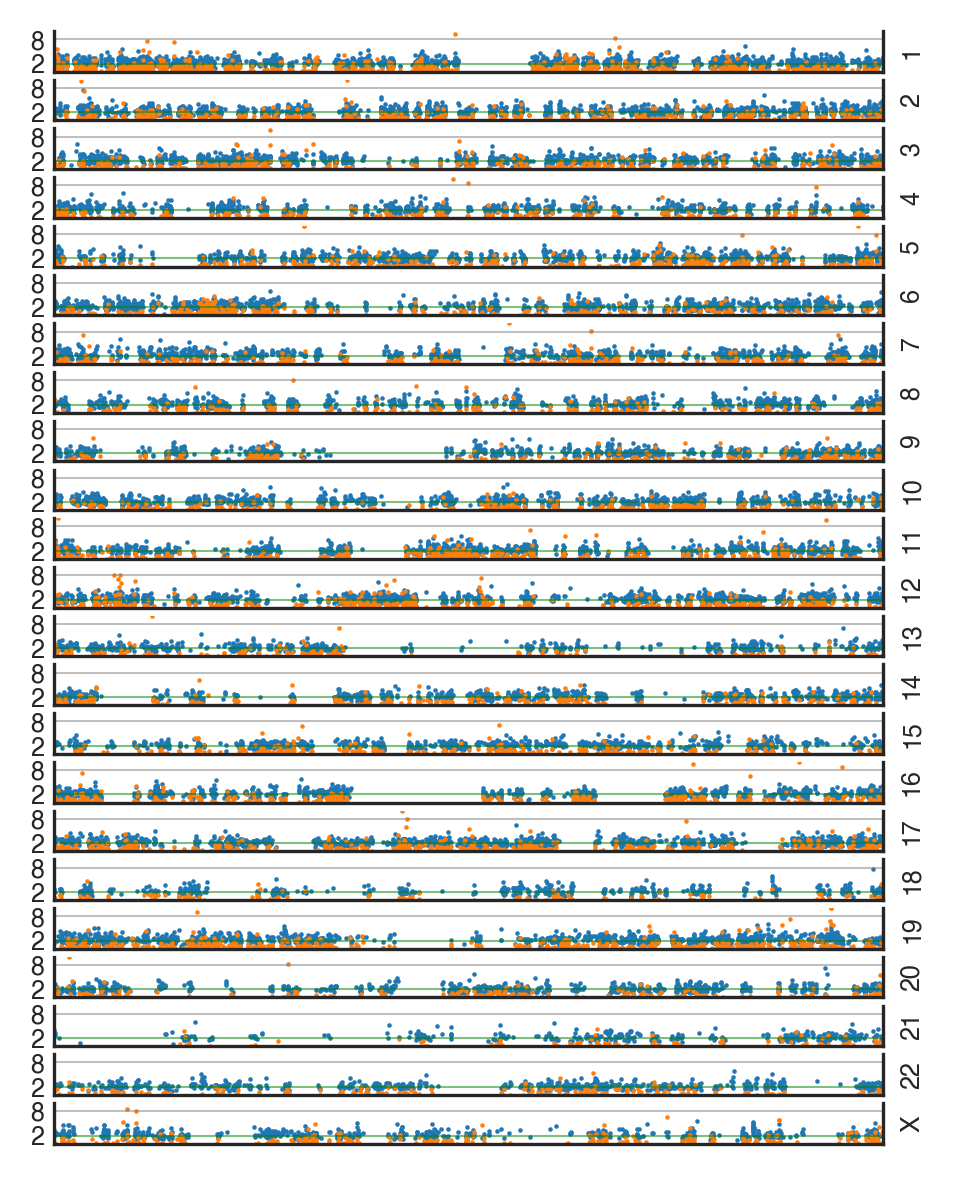

In [310]:
sns.set_style('white')
setfontsize()

fig,ax = plt.subplots(len(chromes)-1,1,figsize=(90*mm, 120*mm), dpi=300)


for j,chrome in enumerate(chromes[:-1]):
    
    ax[j].axhline(2, linewidth=0.5, color='green', alpha=0.5)
    ax[j].axhline(8, linewidth=0.5, color='gray', alpha=0.5)
    
    ad_df = ATAC_data.var[ATAC_data.var['chr'] == chrome]
    ad_df = ad_df[ad_df.quality_p > 0.1]
    x_min = ad_df.start.min()
    x_max = ad_df.end.max()
    #ad_df = ad_df[ad_df.clonal_p < 0.1]
    plot_df = pd.DataFrame(index=ad_df.index)
    plot_df['x'] = ad_df['mid']
    plot_df['y'] = ad_df['adj_fcs'] / np.log(2) # -np.log10(ad_df.clonal_p)
    sns.scatterplot(x='x', y='y', data=plot_df, ax=ax[j], s=1, edgecolor=None)

    
    g_df = adata.var[adata.var['chr'] == chrome]
    #g_df = g_df[g_df.F_pval < 0.01]
    gplot_df = pd.DataFrame(index=g_df.index)
    gplot_df['x'] = g_df['TSS']
    gplot_df['y'] = np.clip(-np.log10(g_df.F_pval),0,10)
    sns.scatterplot(x='x', y='y', data=gplot_df, ax=ax[j], s=1, edgecolor=None)
    y_max= gplot_df['y'].max()
    ax[j].set_xlim(x_min, x_max)
    ax[j].set_ylim(0,10)
    ax[j].set_yticks([2,8])
    ax[j].set_xticks([])
    ax[j].set_ylabel(chrome)
    ax[j].set_xlabel('')
    
    ax[j].tick_params(axis='both', pad=-1)
    #ax[j].yaxis.tick_right()
    ax[j].yaxis.set_label_position("right")
    #if j < len(chromes)-1:
    #    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    
plt.show()

In [243]:
ATAC_data.var[]

PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_77062  Interval_77062   9  115080094  ENSG00000119314      PTBP3   
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_33832  Interval_33832  19    1672563             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_48454  Interval_48454   3   27493603  ENSG00000033867     SLC4A7   
...                        ...  ..        ...              ...        ...   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_58433  Interval_58433   5   54298635  ENSG00000164283       ESM1   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   
Interval_17712  Interval_17712  12   96890243  ENSG00000188596   C12orf55   

                       itype          mid      start  quality_p  clonal_p  \
PeakID                                                                      
Interval_77062        intron  115079731.5  115079369   0.152552  0.045662   
Interval_51938      Intergen  156852750.0  156852601   0.028703  0.000815   
Interval_33832      Intergen    1672247.0    1671931   0.029762  0.115377   
Interval_13433  promoter-TSS   82997180.5   82996620   0.010913  0.010109   
Interval_48454        intron   27493042.5   27492482   0.673157  0.540247   
...                      ...          ...        ...        ...       ...   
Interval_28417  promoter-TSS   88729670.5   88728987   0.032045  0.115768   
Interval_58433        intron   54298297.0   54297959   0.664901  0.145547   
Interval_45676          exon   35310572.5   35310208   0.064673  0.006693   
Interval_8387   promoter-TSS   33623619.5   33622581   0.067399  0.000257   
Interval_17712        intron   96889859.5   96889476   0.062587  0.136735   

                max_height  
PeakID                      
Interval_77062   23.361561  
Interval_51938   30.484528  
Interval_33832   16.173389  
Interval_13433  301.374023  
Interval_48454   21.518496  
...                    ...  
Interval_28417  136.937500  
Interval_58433   24.210867  
Interval_45676   34.971249  
Interval_8387   118.396477  
Interval_17712   16.138868  

[40608 rows x 11 columns]

In [314]:
', '.join(adata.var.F_pval.sort_values()[:50].index)

'KIR3DL2, CENPN, GNLY, FKBP1A, GZMK, KIR2DL4, ABCB1, CCL5, HRH2, GZMA, TALDO1, MT-TE, ALOX5AP, IL17RB, AC092580.4, CYB5B, FEZ1, TMSB4XP8, EIF3G, REG4, GINS2, HPGDS, EGFL6, SNORD17, XCL1, KLRC1, ASB9, KLRB1, PSMC2, CCL4L2, VDAC3, CD74, CANX, HPGD, IFI6, PSMC5, RP4-728D4.2, RP11-81H14.4, IL32, ZNF577, ACTB, PPIB, GIMAP7, ID2, NEK3, CLDND1, CLNS1A, KLRD1, MT-TP, B2M'

# Interactive plots with plotly

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
clone_order = list(gene_clonal['GNLY'].sort_values().index)
GNLY_df = pd.DataFrame(adata[adata.obs.Clone_ID.isin(clone_order)].to_df()['GNLY'])
GNLY_df['Clone'] = adata.obs.Clone_ID
GNLY_df['CloneNo'] = GNLY_df['Clone'].apply(lambda cl : clone_order.index(cl))
GNLY_df = GNLY_df.sort_values(by = 'CloneNo')
GNLY_df['Obs'] = GNLY_df.index
GNLY_df.to_csv('GNLY.csv')

In [ ]:
GNLY_df.head()

In [ ]:
PCR_df = PCR_analysis('GNLY', window=50000)
peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
peaklist = [peak for peak in peaklist if PCR_df.loc['GNLY_Rsq',peak] > 0.2]
pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()    
pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
pplot_df

In [ ]:
pplot_df = pplot_df.melt(ignore_index = False)

In [ ]:
pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
pplot_df['CloneNo'] = pplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
pplot_df.head()
pplot_df

In [ ]:
pplot_df['R'] = pplot_df['PeakID'].map(PCR_ans['GNLY'].loc['GNLY_R'])
pplot_df['R_sq'] = pplot_df['R']**2
pplot_df['Peak location'] = pplot_df['PeakID'].map(ATAC_data.var.loc[peaklist,'mid'])
#pplot_df['end'] = pplot_df['PeakID'].map(ATAC_data.var.loc[peaklist,'end'])
pplot_df = pplot_df.sort_values(by=['CloneNo','R_sq'])
pplot_df

In [ ]:
import altair as alt
gene_chart = alt.Chart(GNLY_df).mark_circle(size=100).encode(
    x={"field": "Clone",
      "type": "ordinal",
       "sort" : clone_order,
       "axis" : alt.Axis(labels=False, title=" ")},
    y='GNLY',
    color='Clone',
    tooltip=['Clone', 'Obs', 'GNLY']
).interactive().properties(
    width=400,
    height=200
)

highlight = alt.selection(type='single', on='mouseover',
                          fields=['PeakID'], nearest=True)

TSS = adata.var.loc['GNLY','TSS']

peak_base = alt.Chart(pplot_df).encode(
    x={"field": "Clone",
               "type": "ordinal",
               "sort" : clone_order},
    y={"field" : "value",
       "type": "quantitative",
       "axis" : alt.Axis(labels=False, title="Peak height")},
    color=alt.Color("PeakID")
)

# interval selection in the bar chart
pts = alt.selection_multi(encodings=["x"])

points = peak_base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=400
)

peak_chart = peak_base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)), #,
    opacity=alt.Opacity("R_sq", legend=None),
    tooltip=['Clone', 'PeakID', 'value']#,
    ).transform_filter(pts).interactive().properties(
    width=400,
    height=100
)

peak_chart = points + peak_chart


peakR_chart = alt.Chart(pplot_df).mark_bar().encode(
    x={"field":"Peak location", 
       "type":"quantitative",
       "axis":alt.Axis(values=[TSS-50000, TSS, TSS+50000])},
    y="R",
    text="PeakID",
    color="PeakID",
    opacity=alt.condition(~highlight, alt.value(0.1), alt.value(1.0)),
    tooltip=['PeakID','R','R_sq']
    #color=alt.condition(
    #    alt.datum.R > 0,
    #    alt.value("steelblue"),  # The positive color
    #    alt.value("orange")  # The negative color
    #)
).interactive().properties(
    width=300,
    height=50).add_selection(pts)



TSS_line = alt.Chart(pd.DataFrame({'TSS': [TSS]})).mark_rule().encode(
    x=alt.X('TSS'))

peakR_chart = peakR_chart + TSS_line

#peakR_chart = peakR_chart + peakR_text

#peaks_chart = alt.hconcat(peak_chart, peakR_chart)

chart = alt.vconcat(gene_chart, peak_chart, peakR_chart).resolve_scale(
    color='independent')

chart

In [ ]:
chart.save('GNLY.json')

In [ ]:
def pgplotly(gene, protein = None, cutoff=0.2, window=50000):
    if protein:
        num_rows = 3
        specs=[[{"type": "scatter"}],
               [{"type": "line"}],
               [{"type": "line"}]]
    else:
        num_rows = 2
        specs=[[{"type": "scatter"}],
               [{"type": "scatter"}]]
        
    #fig, ax = plt.subplots(num_rows,1,figsize=(2.5,0.75*num_rows), dpi=300, sharex=True,
    #                       gridspec_kw = {'hspace':0.05, 'height_ratios':hr})            
    #
    #plt.rcParams['text.usetex'] = False
    #setfontsize()

    fig = make_subplots(
        rows=num_rows, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        specs=specs
    )




    PCR_df = PCR_analysis(gene, window=window)
    clone_order = list(gene_clonal[gene].sort_values().index)
    
    gplot_df = pd.DataFrame(columns=[gene,'Clone'])
    gplot_df[gene] = adata.to_df()[gene]
    
    
    gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
    gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
    clone_order = [clone for clone in clone_order if clone in pg_clones]
    gplot_df['CloneNo'] = gplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
    gplot_df = gplot_df.sort_values(by='CloneNo')
    gplot_df['Text'] = ''
    for row in gplot_df.index:
        expr = gplot_df.loc[row,gene]
        cl = gplot_df.loc[row,'Clone']
        gplot_df.loc[row,'Text'] = '{} expression {:1.3f} in Clone {}.'.format(gene,expr,cl)
    col_range = list(range(len(gplot_df)))
    #for clone in clone_order:
    #    for row in range(num_rows):
    #        ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
    # GENE EXPRESSION PLOT
    fig.add_trace(
        go.Scatter(
            x=gplot_df['Clone'],
            y=gplot_df[gene],
            mode="markers",
            marker=dict(size=16, 
                        color=gplot_df['CloneNo'], 
                        colorscale=px.colors.qualitative.Dark24),
            text=gplot_df['Text'],
            name="{} expression".format(gene)
        ),
        row=1, col=1)
    
    #sns.scatterplot(x='Clone', y=gene, hue='Clone', data=gplot_df, ax=ax[0], legend=False)
    #gene_ticks = [gplot_df[gene].min(), gplot_df[gene].mean(), gplot_df[gene].max()]
    #ax[0].set_yticks(gene_ticks)
    #ax[0].set_yticklabels(gene_ticks, x=0.03)
    #ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #ax[0].set_ylabel(gene)
    #ax[0].yaxis.set_label_position("right")
    
    # ATAC PLOT
    peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
    peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > cutoff]
    pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()
    pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
    pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
    
    pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
    pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
    pplot_df['CloneNo'] = pplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
    pplot_df = pplot_df.sort_values(by='CloneNo')
    #
    no_peaks = 0
    for peak in peaklist:
        peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
        if peak_Rsq > 0.05:
            peak_label = '${:1.2f}$'.format(peak_Rsq)
            no_peaks += 1
        else:
            peak_label = None
        fig.add_trace(
            go.Scatter(
                x=pplot_df['Clone'],
                y=pplot_df[peak],
                mode="lines",
                #text=gplot_df['Text'],
                name=peak
            ),
            row=2, col=1)
        
    
    
    # PROTEIN PLOT
    #if protein:
    #    proplot_df = pd.DataFrame(prot_clonal[protein], columns=[protein])
    #    proplot_df[protein] = proplot_df[protein] - proplot_df[protein].min()
    #    proplot_df[protein] = proplot_df[protein] / proplot_df[protein].max()
    #    proplot_df['Clone'] = proplot_df.index
    #    sns.lineplot(x='Clone', y=protein, data=proplot_df, ax=ax[1], linewidth=0.7)
    #    ax[1].text(1,0.5,protein, ha='left')
    #    ax[1].set_ylabel('Prot')
    #    ax[1].yaxis.set_label_position("right")
    #    ax[1].set_yticks([])
    #    ax[1].set_xlabel('')
    #    ax[1].spines['top'].set_color('lightgray')
    #    ax[1].spines['bottom'].set_color('lightgray')
    

    if protein:
        title = '{}, {}, and {} peaks.'.format(gene, protein, len(peaklist))
    else:
        title = '{} and {} peaks.'.format(gene, len(peaklist))
    #plt.suptitle(title, y=1.02)
    
    # Plot legend
    #if no_peaks <= 6:
    #    ncol = no_peaks
    #else:
    #    ncol = (no_peaks + 1)//2
    #lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
    #                  loc=9, ncol=ncol, framealpha=0.5)
    #lgnd.get_frame().set_linewidth(0.5)
    
    # Save and show figure.
    #set_size(fig, (2.5, 1.5))
    #plt.savefig("Panels/MultiPlots/{}_multi.pdf".format(gene), bbox_inches='tight')
    #plt.show()
    fig.show()
    fig.write_html("Plotly/{}_plotly.html".format(gene), include_plotlyjs=False)
    

In [ ]:
pgplotly('GNLY')